# 基于集成算法融合模型的国美电商订单异常检测

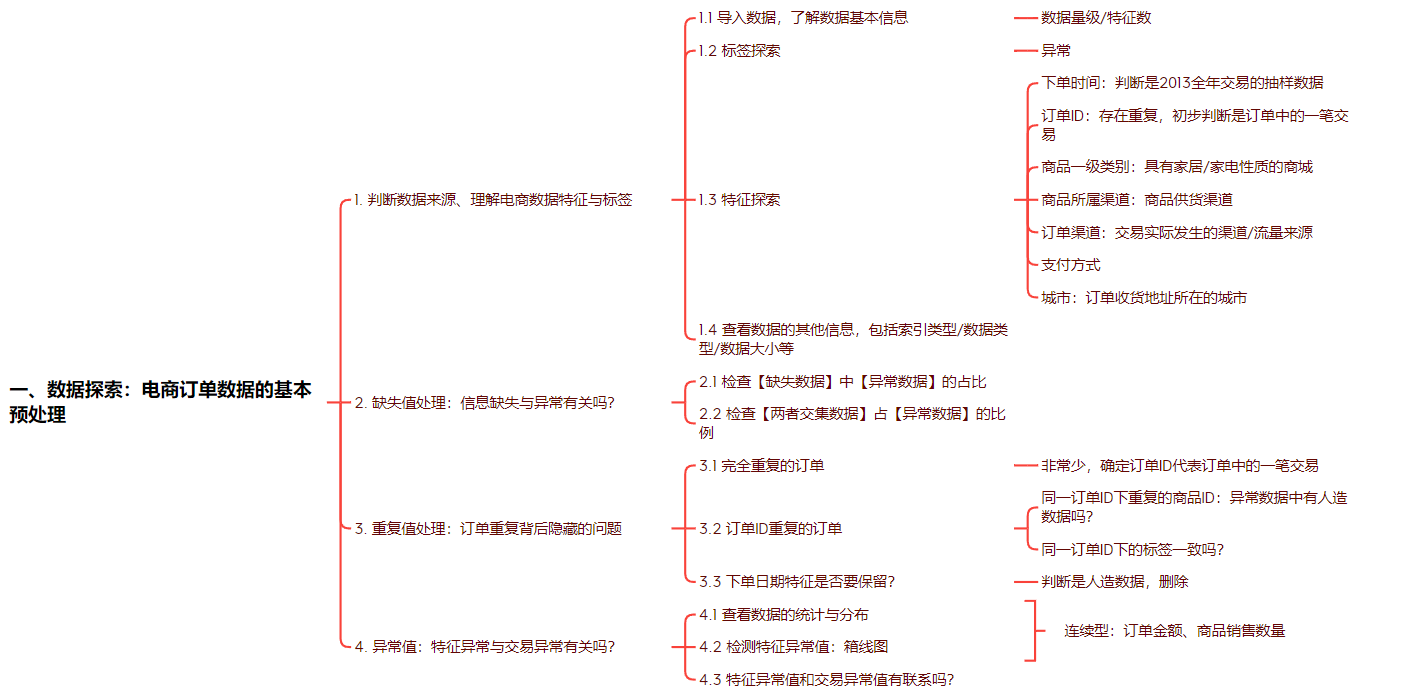
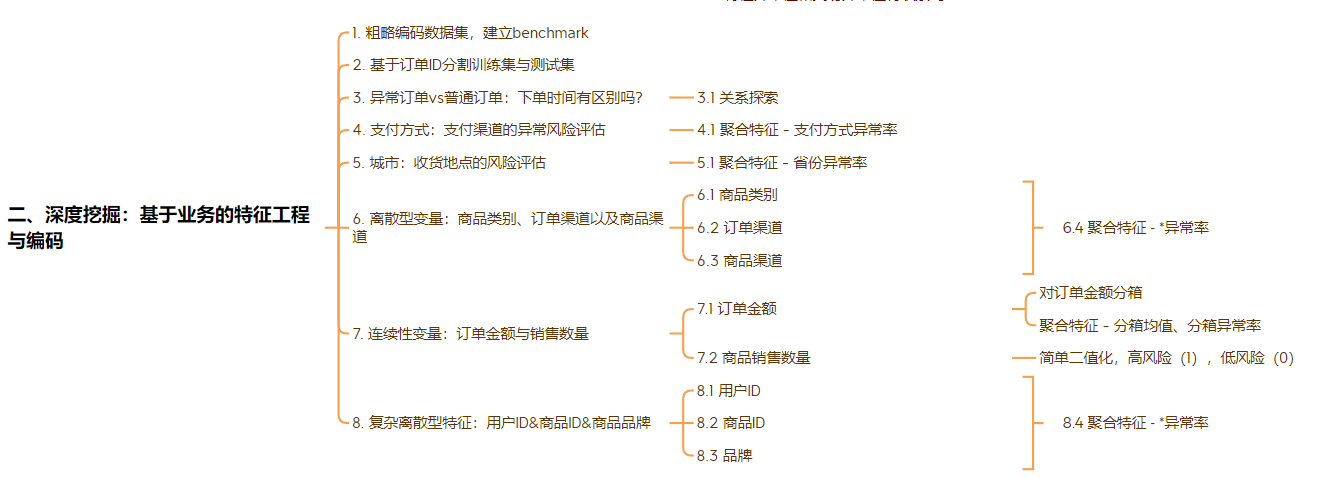
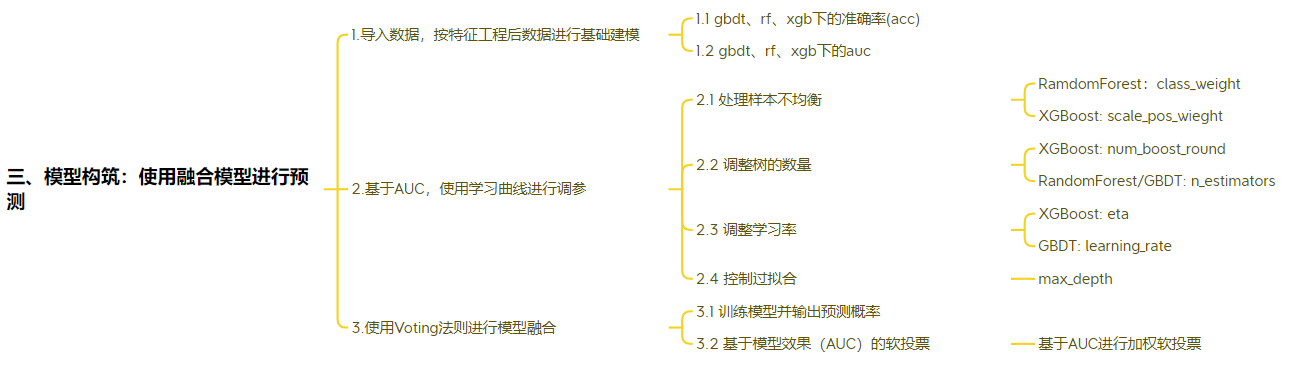

## 一、数据探索：电商订单数据的基本预处理

### 1. 判断数据来源、理解电商数据特征与标签

#### 1.1 导入数据，了解数据基本信息

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['font.sans-serif']=['Simhei'] 
plt.rcParams['axes.unicode_minus']=False
import time
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
data = pd.read_csv(r"abnormal_orders.txt")

In [3]:
# 查看数据的大致内容
data.head() 

,order_id,order_date,order_time,cat,attribution,pro_id,pro_brand,total_money,total_quantity,order_source,pay_type,user_id,city,abnormal_label
0,4277880103,2013-10-17,13:09:16,NaN,GO,8000001215,NaN,1000.0,1000,游戏站点,当当支付,murongchun,北京市,0
1,4283851335,2013-09-23,14:09:49,手机摄影数码,POP,8002042497,三星,766000.0,200,主站,合并支付,dakehu_zy,上海市,1
2,4277700101,2013-08-27,14:26:38,NaN,GO,7000000960,国之美艺术品,8000.0,160,do.site_id,在线支付,1391175862,NaN,1
3,4276537082,2013-09-11,14:16:47,电视冰箱洗衣机空调,POP,8001992420,樱花,19900.0,100,主站,合并支付,qq-3be293b,泉州市,1
4,4281111595,2013-04-10,10:44:46,家具建材,POP,8002199518,纬度空间,100.0,100,主站,合并支付,nonscorpio,广州市,1


In [4]:
data.columns

Index(['order_id', 'order_date', 'order_time', 'cat', 'attribution', 'pro_id',
       'pro_brand', 'total_money', 'total_quantity', 'order_source',
       'pay_type', 'user_id', 'city', 'abnormal_label'],
      dtype='object')

**查看数据量/特征数**

In [5]:
data.shape

(134190, 14)

**更换列名为中文**

In [6]:
data.columns = ["订单ID","下单日期","下单时间","商品一级类别","商品所属渠道","商品ID","品牌","订单金额","商品销售数量","订单渠道","支付方式","下单用户ID","城市","异常"]

In [7]:
data.columns.tolist()

['订单ID',
 '下单日期',
 '下单时间',
 '商品一级类别',
 '商品所属渠道',
 '商品ID',
 '品牌',
 '订单金额',
 '商品销售数量',
 '订单渠道',
 '支付方式',
 '下单用户ID',
 '城市',
 '异常']

In [8]:
data.head(5)

,订单ID,下单日期,下单时间,商品一级类别,商品所属渠道,商品ID,品牌,订单金额,商品销售数量,订单渠道,支付方式,下单用户ID,城市,异常
0,4277880103,2013-10-17,13:09:16,NaN,GO,8000001215,NaN,1000.0,1000,游戏站点,当当支付,murongchun,北京市,0
1,4283851335,2013-09-23,14:09:49,手机摄影数码,POP,8002042497,三星,766000.0,200,主站,合并支付,dakehu_zy,上海市,1
2,4277700101,2013-08-27,14:26:38,NaN,GO,7000000960,国之美艺术品,8000.0,160,do.site_id,在线支付,1391175862,NaN,1
3,4276537082,2013-09-11,14:16:47,电视冰箱洗衣机空调,POP,8001992420,樱花,19900.0,100,主站,合并支付,qq-3be293b,泉州市,1
4,4281111595,2013-04-10,10:44:46,家具建材,POP,8002199518,纬度空间,100.0,100,主站,合并支付,nonscorpio,广州市,1


#### 1.2 标签探索

In [9]:
(data["异常"] == 1).sum()

28457

In [10]:
# 样本不均衡，但是不均衡的程度较轻
(data["异常"] == 1).sum()/data.shape[0] 

0.2120649824875177

<div class="alert alert-block alert-success">
    
- 虽然标签定义被定义为交易异常，但我们其实并不了解这里“异常”的具体含义。在实际业务工作中，我们将询问业务人员“异常”的定义，但现在我们无法得知其真实情况。如果可能的画，我们将在数据探索过程重努力挖掘交易异常的真实定义，力求获得更加深入的业务理解。

</div>

#### 1.3 特征探索

**下单时间**

In [11]:
data["下单日期"].value_counts()

2013-10-31    690
2013-03-21    429
2013-11-01    426
2013-01-24    422
2013-03-23    416
             ... 
2013-07-31     17
2013-08-31     14
2013-05-31      2
2013-03-31      2
2013-01-31      2
Name: 下单日期, Length: 364, dtype: int64

<div class="alert alert-block alert-success">
    
- 有364个类别，初步判断应该是覆盖2013年中每一天。如果是较大的电商平台，不太可能出现一天之内圈平台只有2单交易的情况，因此判断**该数据应该是全年交易数据的抽样数据。**

</div>

**订单ID：订单号码**

In [12]:
# 订单数据的ID一般不会有重复值，我们先确认一下ID是否是唯一ID
data["订单ID"].duplicated().sum()

19212

<div class="alert alert-block alert-warning">
 
**思考：**     
1. 订单ID存在重复值，这对于我们的预测来说不是一个很好的消息。订单ID在电商系统中是不会复用的，一定是一单一号，因此重复的订单ID可能说明什么呢？
    
</div>

<div class="alert alert-block alert-success">
    
- 数据中存在大量重复样本，需要删除；
- 每条数据并不是订单，反而可能是这个订单中的一个商品/一笔交易，因此标签中的异常实际上可能是“这笔交易的异常”，而非整个订单的异常情况（如果是这种情况，在数据预处理时将给我们带来无穷无尽的麻烦；**标签很可能是交易异常，而非订单异常**
- 如果一条数据代表一个订单（订单ID是唯一值），那作为序号是可以删除的，但如果不是，同一个订单ID下的商品/交易可能存在一定联系，此时的订单ID就相当于一个用于分类的离散型变量，不应删除。
</div>

**商品一级类别**

In [13]:
data["商品一级类别"].value_counts()

手机摄影数码       20612
生活电器厨卫电器     19281
家纺寝居         18679
电脑办公打印文仪     11405
家居日用         10642
电视冰箱洗衣机空调     9067
美妆个护          9043
汽车用品          6490
家具建材          4941
食品酒水          4669
健康医疗          4252
服饰鞋帽          4067
运动户外          3934
母婴用品玩具        2664
箱包奢品          1962
钟表首饰           860
图书音像           232
Name: 商品一级类别, dtype: int64

<div class="alert alert-block alert-success">
    
- 高位的是电子产品、小型家电以及家纺，整个类别明显是带有部分家居/家电性质的商城的类别
</div>

**商品所属渠道**

In [14]:
# 从value_counts的结果来看商品所属渠道是商品供货/售卖的渠道
data["商品所属渠道"].value_counts()

GO     91170
POP    43020
Name: 商品所属渠道, dtype: int64

In [15]:
(data["商品所属渠道"] == "GO").sum()/data.shape[0]

0.6794097920858484

<div class="alert alert-block alert-success">
    
- POP(Platform Open Plan)，平台开放计划 - 价值链整合模式中入驻的第三方/个人商家，货物来自第三方商家自己的供应商

- GO(无法判断是何含义)，但从订单占比来看，判断可能是价值链整合模式中的自营商家的品牌。这部分货物来自自营商家自己的供应商/厂房/工厂
</div>

**订单渠道**

In [16]:
data["订单渠道"].value_counts()

主站            96894
抢购            16256
手机站点           7098
团购             6294
手机抢购           3095
do.site_id     2394
手机团购           1074
充值              703
当当              377
游戏站点              5
Name: 订单渠道, dtype: int64

<div class="alert alert-block alert-warning">
 
**思考：**     
1. do.site_id，当当，充值，这三个渠道是什么？
    
</div>

<div class="alert alert-block alert-success">
    
交易实际发生的渠道/流量来源 - 不确定是可以在站外交易还是站外渠道引向主站进行交易。<br>
**大部分实际电商平台的订单是必须在平台内发生的**，渠道只是流量的渠道。<br>
大部分渠道看起来都简单明了，需要说明的是，渠道中的“手机站点”、“手机抢购”、“手机团购”等渠道都是指向移动端APP的营销方式，只不过当时还没有“移动端”这种名称。在渠道中，有三个渠道可以特别说明一下——<br>

**do.site_id**：在对外推广吸引流量时，每个推广位/媒体/推广者会有对应的ID，这个ID会方便渠道方管理自己的渠道，也会有利于推广者记录渠道的类型。

在淘宝的体系中，推广ID涉及到三部分：Memberid（推广者ID），Siteid（媒体ID），Adzoneid（广告位ID），一个推广者可以在多个媒体上投放广告，而每个媒体也会有不同的广告位。

在这里，site_id应该指的就是对外推广的媒体ID，通常来说这个媒体可以包括短信推广、SEO推广、桌面弹窗广告、客户端内嵌广告、视频网站广告、其他站点广告等。通常来说这个id应该对应某个数字，但在这组数据中，**site_id被用来指向外部媒体推广这种流量渠道**。

**当当**：这两个渠道可能给我们一些关于数据来源的线索。当当与刚做电商时的亚马逊高度类似，一直以售卖图书闻名，在家电、家居、电子产品方面并无太多名声，为什么订单渠道中会有当当呢？

**充值**：充值是一个很特殊的业务，可能包括话费充值、QQ会员充值、游戏充值、点卡充值等等。今天，微信无缝接入手机话费充值业务，游戏基本都是F2P、APP内充值，我们很难从直觉上想到有许多充值业务的电商。但曾经有电商在2012、13年左右大规模提供过线上充值业务，那就是**国美电器**。

- 国美有充值业务的基因
> - 国美电器是家电零售连锁企业，早年在小家电、手机数码方面有很好的口碑。<br>
> - 在移动互联网全面兴起之前，手机充值业务基本由线下营业厅和线下售卖店包揽。<br>
> - 国美作为在手机数码方面有大量线下店的企业，天生就有手机充值业务的基因。因此当国美决定“上线”之后，线上充值业务也成为一块关键业务，顺带也上线了一些游戏充值业务。<br>
> - 时至今日，国美还有自己的线上游戏充值、手机充值中心。

- 国美与当当有合作历史
> - 2012年初，当当正面临京东的极速扩张，国美刚杀入电商领域，正是需要强强联合的时候。<br>
> - 同年4月，两家公司宣布合作，国美电器入驻当当商城，形成店中店，国美借用当当在互联网领域的流量，当当借用国美自带的生产供应链，试图通过线上线下结合的方式形成与京东抗衡的力量。<br>
> - 当然，这种策略在当时就不被市场看好，毕竟光靠拓展一个不以家电闻名的渠道，其实并不能提高太多的效率。同时，在合作过程中双方都没有展现出开放的心态和魄力，导致这种合作停留在了浅尝辄止的阶段。<br>
> - 时至今日，当当依然在售卖部分3C产品，但国美与当当的合作已有些“名存实亡”之感。<br>

大量充值业务以及作为渠道的“当当”不禁让我们推测，**这份数据是国美线上店2013年全年交易数据的抽样**，那刚才商品所属渠道中无法理解的“GO”就能解释得通了，作为价值链整合模式中的自营商家的品牌，GO是国美GOME的简称。
</div>

**支付方式**

In [17]:
data["支付方式"].value_counts()

合并支付    104274
货到付款     26785
当当支付      2511
在线支付       421
账户余额       199
Name: 支付方式, dtype: int64

<div class="alert alert-block alert-success">
    
- 合并支付 - 购物车支付
- 货到付款 - 许多价值链整合模式的平台会对自营店开放货到付款服务，京东在早期就提供大量的货到付款服务
- 在线支付 - 可能覆盖支付宝、微信等其他支付方式
</div>

**城市**

In [18]:
data["城市"].value_counts()

北京市        14554
上海市         6637
广州市         6033
深圳市         5468
天津市         3393
           ...  
神农架林区          1
昌都地区           1
山西省其他城市        1
果洛州            1
四川省其他城市        1
Name: 城市, Length: 365, dtype: int64

<div class="alert alert-block alert-success">
    
- 由于数据是平台提供的，很可能是商品发货的城市，但从北上广深为订单最多的前四名城市来看，该城市**更可能是订单的收货地址所在的城市**，或下单IP所在城市。可以说，直到拼多多诞生之前，大部分电商平台服务的核心用户还是一线城市及一线城市周边的城市群。
</div>

#### 1.4 查看数据的其他信息，包括索引类型/数据类型/数据大小等

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134190 entries, 0 to 134189
Data columns (total 14 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   订单ID    134190 non-null  int64  
 1   下单日期    134190 non-null  object 
 2   下单时间    134190 non-null  object 
 3   商品一级类别  132800 non-null  object 
 4   商品所属渠道  134190 non-null  object 
 5   商品ID    134190 non-null  int64  
 6   品牌      133418 non-null  object 
 7   订单金额    134189 non-null  float64
 8   商品销售数量  134190 non-null  int64  
 9   订单渠道    134190 non-null  object 
 10  支付方式    134190 non-null  object 
 11  下单用户ID  134190 non-null  object 
 12  城市      134188 non-null  object 
 13  异常      134190 non-null  int64  
dtypes: float64(1), int64(4), object(9)
memory usage: 14.3+ MB


In [20]:
data.select_dtypes(include="int64").head()

,订单ID,商品ID,商品销售数量,异常
0,4277880103,8000001215,1000,0
1,4283851335,8002042497,200,1
2,4277700101,7000000960,160,1
3,4276537082,8001992420,100,1
4,4281111595,8002199518,100,1


<div class="alert alert-block alert-success">
    
- 数据量为13w，是有一定规模的数据，但大部分计算机运行应该没问题
- 粗略看来，部分特征存在缺失值
- 几乎所有有效特征都是object类型，有较大的数据预处理空间
- 唯一的浮点数类型特征是订单金额，整数型特征基本没用
</div>

<div class="alert alert-block alert-success">
    
- 异常订单是标签，订单ID与商品ID原则上都是离散型变量，不能以数值方式直接带入进行建模，商品销售数量虽然原则上是离散型变量，实际却可以当做连续型来处理。
</div>

### 2. 缺失值处理：信息缺失与异常有关吗？

In [21]:
data.isnull().sum()

订单ID         0
下单日期         0
下单时间         0
商品一级类别    1390
商品所属渠道       0
商品ID         0
品牌         772
订单金额         1
商品销售数量       0
订单渠道         0
支付方式         0
下单用户ID       0
城市           2
异常           0
dtype: int64

In [22]:
data.isnull().sum()*100/data.shape[0]

订单ID      0.000000
下单日期      0.000000
下单时间      0.000000
商品一级类别    1.035845
商品所属渠道    0.000000
商品ID      0.000000
品牌        0.575304
订单金额      0.000745
商品销售数量    0.000000
订单渠道      0.000000
支付方式      0.000000
下单用户ID    0.000000
城市        0.001490
异常        0.000000
dtype: float64

<div class="alert alert-block alert-warning">
 
**思考：**     
1. 有缺失值，但缺失值比例非常小，其中**城市**与**订单金额**分别有1、2个缺失，完全可以忽略不计。
2. 在商品质量参差不齐的电商领域，**品牌**信息缺失并不值得注意，稍微调查一下**“商品一级类别”**中缺失的情况即可。
3. “商品一级类别”缺失了1.03%。通常来说这个比例的缺失数据都可以直接删除，但考虑到电商行业在业务上对“异常”的定义，关键信息的缺失或许与“交易异常”有联系。
4. 如何判断缺失与交易异常的之间的联系呢？

    
</div>

<div class="alert alert-block alert-success">
    
- 判断**“缺失”**与**“异常”**的联系：
    1. 检查【缺失数据】中【异常数据】的占比：
        - 该比例高说明数据更可能因为缺失（某一特征）而被判断为异常，两者联系很强。
    2. 检查【两者交集数据】占【异常数据】的比例：
        - 该比例高则说明【缺失数据】基本都是【异常数据】，两者联系很强。
</div>

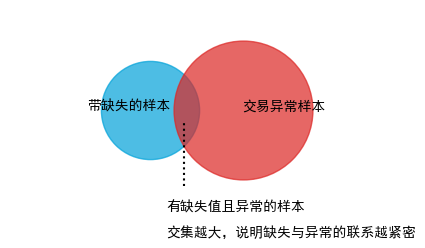

In [23]:
plt.rcParams['font.sans-serif']=['Simhei'] #让jupyter中的图画上的中文都显示出来
plt.rcParams['axes.unicode_minus']=False

plt.figure(figsize=(5,3), dpi=100)
plt.scatter(2.8,5,s=5000,c="#01a2d9",alpha=0.7,label="带缺失的样本")
plt.scatter(4,5,s=10000,c="#dc2624",alpha=0.7,label="交易异常样本")
plt.xlim(1,6)
plt.ylim(2.5,7)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.text(2,5,s="带缺失的样本",fontsize=10)
plt.text(4,5,s="交易异常样本",fontsize=10)
plt.vlines(3.25,3.5,4.8,colors="k",linestyles="dotted")
plt.text(3.015,3,s="有缺失值且异常的样本",fontsize=10)
plt.text(3.015,2.5,s="交集越大，说明缺失与异常的联系越紧密",fontsize=10)
plt.xticks([])
plt.yticks([])
plt.show()

#### 2.1 检查【缺失数据】中【异常数据】的占比

In [24]:
for i in ["商品一级类别","品牌"]:
    ratio1 = 100*data.loc[data[i].isnull(),"异常"].sum()/data[i].isnull().sum()
    print("缺少（{}）的样本中异常样本占比为{:.3f}%".format(i,ratio1))

缺少（商品一级类别）的样本中异常样本占比为11.727%
缺少（品牌）的样本中异常样本占比为20.984%


<div class="alert alert-block alert-success">
    
- 该数值说明，**商品并不会因为缺少品牌信息或缺少商品信息就被判断为交易异常**。缺失与交易异常的联系并不大。
</div>

#### 2.2 检查【两者交集数据】占【异常数据】的比例

In [25]:
for i in ["商品一级类别","品牌"]:
    ratio2 = 100*data.loc[data[i].isnull(),"异常"].sum()/(data["异常"]==1).sum()
    print("全部交易异常样本中，缺少（{}）的异常样本占比为{:.3f}%".format(i,ratio2))

全部交易异常样本中，缺少（商品一级类别）的异常样本占比为0.573%
全部交易异常样本中，缺少（品牌）的异常样本占比为0.569%


<div class="alert alert-block alert-success">
    
- 该数值说明，**全部交易异常样本中，缺失样本的占比非常小**，可以直接删除处理。
</div>

In [26]:
data.dropna(how="any",inplace=True)

In [27]:
# 不再具有任何缺失值
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 132761 entries, 1 to 134189
Data columns (total 14 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   订单ID    132761 non-null  int64  
 1   下单日期    132761 non-null  object 
 2   下单时间    132761 non-null  object 
 3   商品一级类别  132761 non-null  object 
 4   商品所属渠道  132761 non-null  object 
 5   商品ID    132761 non-null  int64  
 6   品牌      132761 non-null  object 
 7   订单金额    132761 non-null  float64
 8   商品销售数量  132761 non-null  int64  
 9   订单渠道    132761 non-null  object 
 10  支付方式    132761 non-null  object 
 11  下单用户ID  132761 non-null  object 
 12  城市      132761 non-null  object 
 13  异常      132761 non-null  int64  
dtypes: float64(1), int64(4), object(9)
memory usage: 15.2+ MB


In [28]:
# 删除样本后，需重新整理索引
data.index = range(data.shape[0])

In [29]:
# 确认现在的样本数量与异常订单数量：
data.shape[0]

132761

In [30]:
# 28457 ——> 28284 ：少了差不多200个异常数据，影响不大
(data["异常"] == 1).sum()

28284

In [31]:
# 0.212 ——> 0.213 
(data["异常"] == 1).sum()/data.shape[0] 

0.21304449348829851

### 3. 重复值处理：订单重复背后隐藏的问题

In [32]:
data["订单ID"].duplicated().sum()

18554

<div class="alert alert-block alert-warning">
 
**思考：**     
1. 之前查看过“订单ID”，发现订单ID是有重复的，因此整个数据集中含有重复数据的可能性很高，并且每条数据很可能代表的不是订单，而是订单中的一个商品、一次交易。
2. 如何能更好地证实这一点呢？
    
</div>

<div class="alert alert-block alert-success">
    
- 查看完全重复的数据有多少，如果不多的话，就可以在一定程度上证实了数据集中不存在大量重复订单。
</div>

#### 3.1 完全重复的订单

In [33]:
# 只有8条重复样本，直接删除
data.duplicated().sum() 

8

In [34]:
data.drop_duplicates(inplace=True)

In [35]:
data.shape

(132753, 14)

<div class="alert alert-block alert-success">
    
- 现在来看，每个样本大概率是订单中的不同商品。
</div>

#### 3.2 订单ID重复的订单

In [36]:
data["订单ID"].value_counts()

4279118253    32
4269390206    23
4271884108    20
4275856215    20
4279551124    19
              ..
4197744419     1
4285399129     1
4276101928     1
4280584543     1
4272687103     1
Name: 订单ID, Length: 114207, dtype: int64

In [37]:
# 随机选择一个重复订单，进行查看
data[data["订单ID"] == 4279118253].head(10)

,订单ID,下单日期,下单时间,商品一级类别,商品所属渠道,商品ID,品牌,订单金额,商品销售数量,订单渠道,支付方式,下单用户ID,城市,异常
95213,4279118253,2013-07-23,23:22:21,家具建材,GO,1000147804,西门子,10.6,1,主站,合并支付,cxh0111,湛江市,0
95214,4279118253,2013-11-08,23:22:21,家具建材,GO,1000147804,西门子,10.6,1,主站,合并支付,cxh0111,湛江市,0
95215,4279118253,2013-01-26,23:22:21,家具建材,GO,1000147606,西门子,20.6,1,主站,合并支付,cxh0111,湛江市,0
95216,4279118253,2013-02-03,23:22:21,家具建材,GO,1000147606,西门子,20.6,1,主站,合并支付,cxh0111,湛江市,0
95217,4279118253,2013-07-06,23:22:21,家具建材,GO,1000147606,西门子,20.6,1,主站,合并支付,cxh0111,湛江市,0
95218,4279118253,2013-04-28,23:22:21,家具建材,GO,1000147826,西门子,10.6,1,主站,合并支付,cxh0111,湛江市,0
95219,4279118253,2013-10-04,23:22:21,家具建材,GO,1000147826,西门子,10.6,1,主站,合并支付,cxh0111,湛江市,0
95220,4279118253,2013-02-21,23:22:21,家具建材,GO,1000147826,西门子,10.6,1,主站,合并支付,cxh0111,湛江市,0
95221,4279118253,2013-06-18,23:22:21,家具建材,GO,1000147826,西门子,10.6,1,主站,合并支付,cxh0111,湛江市,0
95222,4279118253,2013-09-25,23:22:21,家具建材,GO,1000147826,西门子,10.6,1,主站,合并支付,cxh0111,湛江市,0


In [38]:
data[data["订单ID"] == 4269390206].head(10)

,订单ID,下单日期,下单时间,商品一级类别,商品所属渠道,商品ID,品牌,订单金额,商品销售数量,订单渠道,支付方式,下单用户ID,城市,异常
76916,4269390206,2013-09-26,02:11:10,电视冰箱洗衣机空调,GO,1000324051,夏普,2588.0,1,主站,合并支付,1390109546,西安市,0
76917,4269390206,2013-03-09,02:11:10,电视冰箱洗衣机空调,POP,8002267703,夏普,14999.0,1,主站,合并支付,1390109546,西安市,0
76918,4269390206,2013-09-21,02:11:10,电视冰箱洗衣机空调,GO,1000324052,夏普,3888.0,1,主站,合并支付,1390109546,西安市,0
76919,4269390206,2013-01-23,02:11:10,家居日用,GO,1000174960,伟经,275.0,1,主站,合并支付,1390109546,西安市,0
76920,4269390206,2013-11-12,02:11:10,电脑办公打印文仪,GO,1000315933,中亿,738.0,1,主站,合并支付,1390109546,西安市,0
76921,4269390206,2013-05-03,02:11:10,生活电器厨卫电器,GO,1000320932,凯伍德,1690.0,1,主站,合并支付,1390109546,西安市,0
76922,4269390206,2013-05-02,02:11:10,家居日用,GO,1000336076,康宁,439.0,1,主站,合并支付,1390109546,西安市,0
76923,4269390206,2013-12-19,02:11:10,家居日用,GO,1000192284,国研联合,158.0,1,主站,合并支付,1390109546,西安市,0
76924,4269390206,2013-10-28,02:11:10,家居日用,GO,1000104751,苏泊尔,459.0,1,主站,合并支付,1390109546,西安市,0
76925,4269390206,2013-12-05,02:11:10,家居日用,GO,1000104746,苏泊尔,229.0,1,主站,合并支付,1390109546,西安市,0


<div class="alert alert-block alert-warning">
 
**思考：**     
1. 诡异的事情发生了，**同一个订单ID下有相同的产品，并且全部是同一个用户、同一个地址在不同日期的同一时间下单的商品。**同一订单下有相同的产品可以理解为购买了多件该产品、且每件都被记为了一个样本，但一个用户在不同日期的同一时间下单，还形成了同样的订单ID，这明显是人为捏造的交易或数据有误。通常来说，即便是设置好规律的自动下单（企业采购时可能会有如此情况），也不太可能实现交易时间在时分秒上完全一致，何况这些交易的金额非常小，完全不像企业订单。
    
</div>

<div class="alert alert-block alert-success">
    
- 基本可以判断，其中许多订单是人为加上日期再捏造的，有人复制了订单或商品交易信息，再赋予不同的日期，对数据进行伪造。这有可能是为了算法建模而做的数据增强，因此我们需要进一步查看，这些人造信息是否大量覆盖了交易异常的订单。
</div>

**同一订单ID下重复的商品ID：异常数据中有人造数据吗？**

In [39]:
# 找出重复订单的索引
DupOrder = data["订单ID"].value_counts().index

In [40]:
# 查看重复订单ID下，异常订单的情况
for i in DupOrder[:30]:
    AbOrder = (data.loc[data["订单ID"] == i,"异常"]==1).sum()
    print(i,":",AbOrder)

4279118253 : 0
4269390206 : 0
4271884108 : 20
4275856215 : 20
4279551124 : 0
4265415474 : 0
4283874688 : 0
4283874524 : 0
4283339890 : 0
4283874209 : 0
4283873946 : 0
4283339603 : 0
4283336310 : 0
4283339774 : 0
4283874398 : 0
4283873538 : 0
4276167340 : 0
4282842230 : 0
4282842193 : 0
4193043860 : 16
4282842151 : 0
4282512627 : 0
4282561933 : 0
4282842130 : 0
4272509367 : 0
4282513764 : 0
4282513806 : 0
4282513732 : 0
4282513855 : 0
4282841509 : 0


In [41]:
data[data["订单ID"] == 4271884108].head()

,订单ID,下单日期,下单时间,商品一级类别,商品所属渠道,商品ID,品牌,订单金额,商品销售数量,订单渠道,支付方式,下单用户ID,城市,异常
3980,4271884108,2013-04-30,09:41:31,服饰鞋帽,POP,8002089657,PPZ,178.0,2,手机站点,合并支付,gome_taozx,广州市,1
3981,4271884108,2013-10-09,09:41:31,服饰鞋帽,POP,8000345913,漫路,176.0,2,手机站点,合并支付,gome_taozx,广州市,1
15817,4271884108,2013-09-06,09:41:31,服饰鞋帽,POP,8002287340,jstfe,49.0,1,手机站点,合并支付,gome_taozx,广州市,1
15818,4271884108,2013-09-30,09:41:31,服饰鞋帽,POP,8002287341,jstfe,49.0,1,手机站点,合并支付,gome_taozx,广州市,1
15819,4271884108,2013-09-16,09:41:31,服饰鞋帽,POP,8002206973,梵利玛,109.0,1,手机站点,合并支付,gome_taozx,广州市,1


In [42]:
# 一个订单ID下的商品ID有重复吗？
data.loc[data["订单ID"] == 4271884108,"商品ID"].duplicated().sum()

0

In [43]:
data[data["订单ID"] == 4193043860].head()

,订单ID,下单日期,下单时间,商品一级类别,商品所属渠道,商品ID,品牌,订单金额,商品销售数量,订单渠道,支付方式,下单用户ID,城市,异常
1118,4193043860,2013-06-23,22:50:54,生活电器厨卫电器,POP,8000325989,飞利浦,690.0,5,主站,合并支付,ye519888,惠州市,1
3794,4193043860,2013-07-19,22:50:54,生活电器厨卫电器,GO,1000365248,飞利浦,334.0,2,主站,合并支付,ye519888,惠州市,1
11939,4193043860,2013-01-05,22:50:54,手机摄影数码,GO,1000366925,华为,2288.0,1,主站,合并支付,ye519888,惠州市,1
11940,4193043860,2013-02-02,22:50:54,生活电器厨卫电器,GO,1000308290,奔腾,68.0,1,主站,合并支付,ye519888,惠州市,1
11941,4193043860,2013-08-27,22:50:54,生活电器厨卫电器,GO,1000310218,飞利浦,228.0,1,主站,合并支付,ye519888,惠州市,1


In [44]:
# 再次，一个订单ID下的商品重复情况
data.loc[data["订单ID"] == 4193043860,"商品ID"].duplicated().sum()

0

<div class="alert alert-block alert-success">

- 我们可以发现：
    - 同一订单ID下总是出现“不同日期同一时间”下单的情况，许多样本的“日期”特征很都是伪造的
    - 对异常样本来说，订单下的商品ID都是不同的，并没有出现同一个订单下出现了相同商品的情况。这说明异常数据的下单时间虽然也是伪造的，但是数据本身并没有被伪造。
- 从建模角度来说，这种方式增加样本权重意义不大，因此我们需要剔除“下单日期”这个特征后再进行去重。同一订单下ID下，只要商品/价格有任意的区别，我们都可以认为样本是真实的交易，而不是人造的数据。**如果去重之后，异常数据的数量没有变化，就说明异常数据中并没有人造数据。**
</div>

In [45]:
# 去重之前的异常订单数量
(data["异常"] == 1).sum()

28284

In [46]:
data2 = data.drop(columns="下单日期")

In [47]:
# 去除“下单日期”后重复值数量很少，说明人造的数据并不太多
data2.duplicated().sum() 

1471

In [48]:
# 取出重复值的索引，按索引进行删除
data.drop(index=data[data2.duplicated()].index,inplace=True)

In [49]:
data["订单ID"].value_counts()

4269390206    23
4271884108    20
4275856215    20
4265415474    19
4283339603    18
              ..
4119457425     1
4285079183     1
4282726026     1
3670355593     1
4272687103     1
Name: 订单ID, Length: 114207, dtype: int64

<div class="alert alert-block alert-success">

- 此时，已经没有同一订单下有相同商品ID的情况了。
</div>

In [50]:
# 删除样本后，需重新整理索引
data.index = range(data.shape[0])

In [51]:
# 确认剩余的异常订单的数量
(data["异常"] == 1).sum()

28284

<div class="alert alert-block alert-warning">
 
**思考：**     
1. 还存在一个现象是,**任意订单ID下,每条数据的标签是一致的**,需要验证一下
    
</div>

**同一订单ID下的标签一致吗？**

In [52]:
# 有异常的订单
data.loc[data["异常"]==1,"订单ID"].value_counts()

4275856215    20
4271884108    20
4193043860    16
4272902282    15
4263198458    14
              ..
4279211175     1
4284423334     1
4280539566     1
4275244196     1
4245325823     1
Name: 订单ID, Length: 25107, dtype: int64

In [53]:
data.loc[data["订单ID"] == 4263198458,"异常"]

1560     1
3931     1
3932     1
14800    1
14801    1
14802    1
14803    1
14804    1
14805    1
14806    1
14807    1
14808    1
14809    1
14810    1
Name: 异常, dtype: int64

In [54]:
# 无异常的订单
data.loc[data["异常"]!=1,"订单ID"].value_counts()

4269390206    23
4265415474    19
4283873946    18
4283339890    18
4283874688    18
              ..
4276204704     1
4276404309     1
4278213789     1
4262876316     1
4272687103     1
Name: 订单ID, Length: 89105, dtype: int64

In [55]:
data.loc[data["订单ID"] == 4269390206,"异常"].sum()

0

<div class="alert alert-block alert-success">

- 仅仅查看几条不足以证明任意订单ID下,每条数据的标签是一致的
- 因此,我们可以在整个数据集上验证一下这一点，**对每个含有异常的订单ID,计算【该ID下异常数据量】占【该ID下全部数据量】的比例**
</div>

In [56]:
# 所有含有异常数据的订单ID，及该订单ID下异常数据的数量
label_1 = data.loc[data["异常"]==1,"订单ID"].value_counts()

In [57]:
df = pd.DataFrame()
for idx,i in enumerate(label_1.index):
    ratio = label_1[i]/data[data["订单ID"] == i].shape[0]
    df.loc[idx,"订单ID"] = i
    df.loc[idx,"该ID下交易异常样本占所有样本的比例"] = ratio

In [58]:
df["该ID下交易异常样本占所有样本的比例"].value_counts()

1.0    25102
0.5        5
Name: 该ID下交易异常样本占所有样本的比例, dtype: int64

<div class="alert alert-block alert-success">

- 我们的观察几乎是正确的，这**说明一个订单ID下的所有数据的标签几乎是一致的**。在之后进行预测时我们可以利用这一点修正预测标签。
</div>

#### 3.3 下单日期特征是否要保留？

<div class="alert alert-block alert-warning">
 
**思考：**     
1. 在之前的探索中，我们注意到下单日期这个特征很可能是被捏造的，在进行建模时，我们不能让不符合业务逻辑的被带入模型，因此我们必须修正该特征。
2. 现在的问题是：所有的下单日期都是人造的吗，还是只有相同订单ID下的不同日期是人造的？
</div>

<div class="alert alert-block alert-success">

查看下单日期的月份分布
</div>

In [59]:
# 每个月的交易量分布
OrderMonth = data["下单日期"].apply(lambda x: x[5:7])
OrderMonth.value_counts()

10    11651
06    11201
09    11124
03    11113
07    11011
01    10959
04    10912
05    10888
12    10842
08    10837
11    10723
02    10021
Name: 下单日期, dtype: int64

<div class="alert alert-block alert-success">

- 从业务角度考虑，**整个下单日期特征都是人造的，主要是因为下单日期的分布过于均匀**
- 通常来说，当一个订单被拆分成多比交易、且交易的日期各不相同时，这个订单的实际下单日期很可能该订单ID下所有交易日期中最早的那个日期。因为订单至少要在某一个日期实际发生，当人为在一个订单上制造日期时，通常不会倾向于去制造一个比实际交易日期还早的日期。

- 因此，在一部分订单日期是真实的、另一部分订单日期是人为制造的情况下，越往后的月份订单交易量会倾向于越多，而不会像现在看到的一样分布均匀。唯一的可能就是整个下单日期特征都是人造的，并且是故意制造成均匀分布在1-12月的状态。通常来说，异常与否都与交易时间没有太大的关联，现在我们还高度怀疑下单日期这个特征的数据可靠性，**因此我们可以直接删除“下单日期”这个特征**。
</div>

In [60]:
data.drop(columns="下单日期",inplace=True)

### 4. 异常值：特征异常与交易异常有关吗？

<div class="alert alert-block alert-warning">
 
- 为避免混淆，特征中存在异常值统称为**“特征异常”**，标签上标注为异常则成为**“交易异常”**
</div>

**4.1 查看数据的统计与分布**

In [61]:
data.columns

Index(['订单ID', '下单时间', '商品一级类别', '商品所属渠道', '商品ID', '品牌', '订单金额', '商品销售数量',
       '订单渠道', '支付方式', '下单用户ID', '城市', '异常'],
      dtype='object')

<div class="alert alert-block alert-success">

- 现在的数据中有且只有**交易金额、交易数量**这两个连续型特征，且许多离散型特征的“分布”对当下的预测并无太大意义（如品牌、商品一级类别、城市），因此我们只对两个连续型特征做统计。
</div>

In [62]:
# 确认没有小于0的业务上不该出现的异常值，从分布来看两个连续型变量都可能出现大量的异常
data.loc[:,["订单金额","商品销售数量"]].describe()

,订单金额,商品销售数量
count,131282.000000,131282.000000
mean,667.187834,1.188975
std,2930.730828,1.684653
min,0.500000,1.000000
25%,29.000000,1.000000
50%,98.000000,1.000000
75%,379.000000,1.000000
max,766000.000000,200.000000


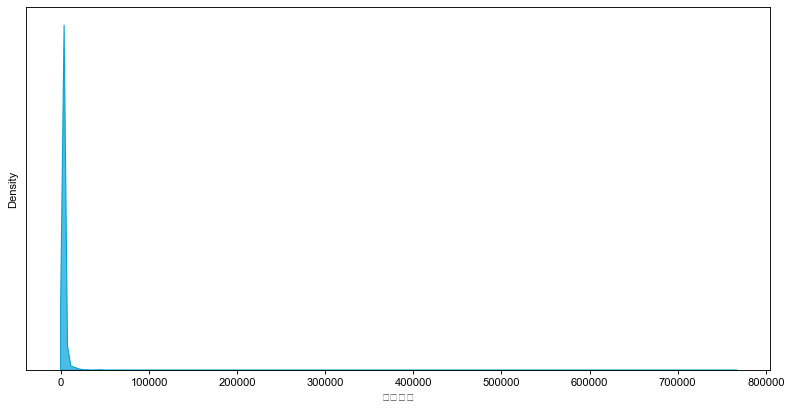

In [63]:
# 订单金额分布图 - range（:）
plt.rcParams['font.sans-serif']=['Simhei']
plt.rcParams['axes.unicode_minus']=False
plt.figure(figsize=(12, 6), dpi=80)
# 绘图
sns.kdeplot(data.loc[:, "订单金额"],
            shade=True,
            color="#01a2d9",
            label="订单金额",
            alpha=.7)
sns.set(style="whitegrid",font="simhei", font_scale=1.1)
# plt.title("订单金额概率密度分布图",fontsize=18)
plt.yticks([])
plt.show()

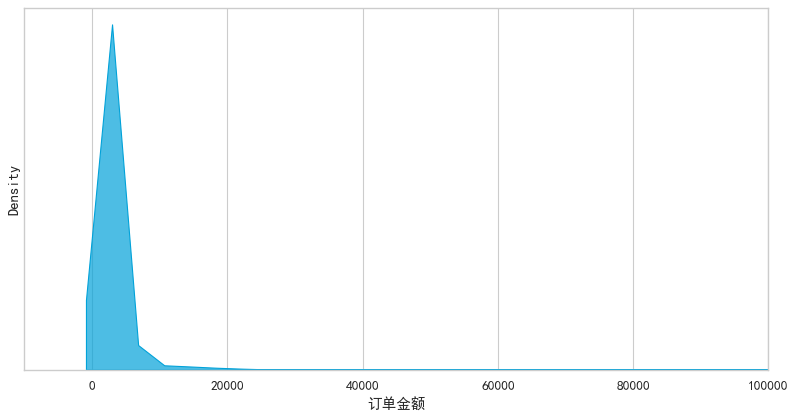

In [64]:
# 订单金额分布图 - range(-10000,100000)
import seaborn as sns
plt.rcParams['font.sans-serif']=['Simhei']
plt.rcParams['axes.unicode_minus']=False
plt.figure(figsize=(12, 6), dpi=80)
# 绘图
sns.kdeplot(data.loc[:, "订单金额"],
            shade=True,
            color="#01a2d9",
            label="订单金额",
            alpha=.7)
sns.set(style="whitegrid",font="simhei", font_scale=1.1)
# plt.title("订单金额概率密度分布图",fontsize=18)
plt.xlim((-10000,100000))
plt.yticks([])
plt.show()

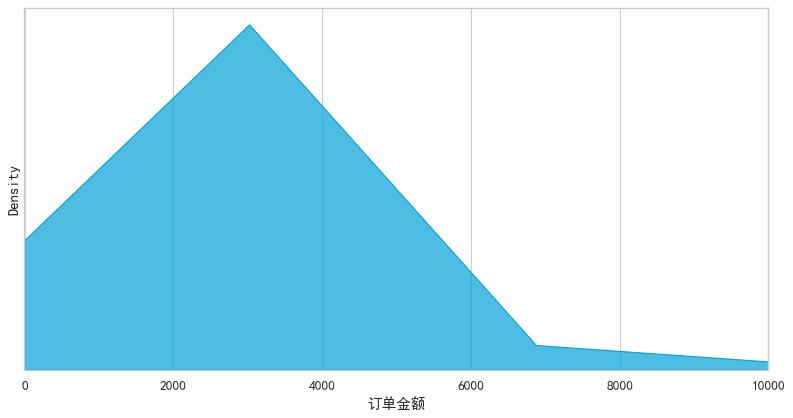

In [65]:
# 订单金额分布图 - range(-1,10000)
import seaborn as sns
plt.rcParams['font.sans-serif']=['Simhei']
plt.rcParams['axes.unicode_minus']=False
plt.figure(figsize=(12, 6), dpi=80)
# 绘图
sns.kdeplot(data.loc[:, "订单金额"],
            shade=True,
            color="#01a2d9",
            label="订单金额",
            alpha=.7)
sns.set(style="whitegrid",font="simhei", font_scale=1.1)
# plt.title("订单金额概率密度分布图",fontsize=18)
plt.xlim((-1,10000))
plt.yticks([])
plt.show()

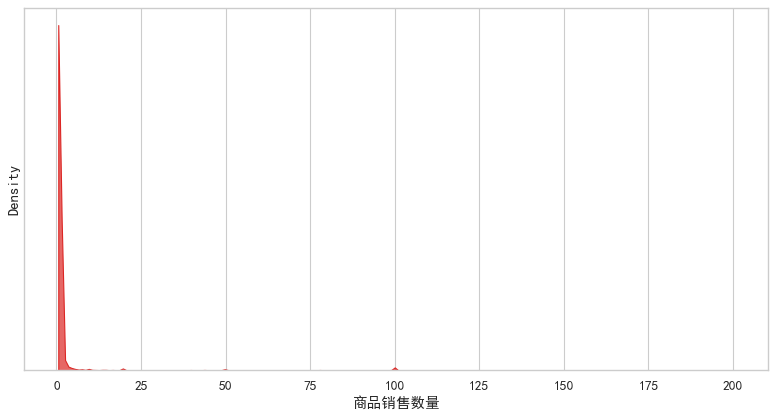

In [66]:
# 商品销售数量分布图 - range(:)
plt.figure(figsize=(12, 6), dpi=80)
sns.kdeplot(data.loc[:, "商品销售数量"],
            shade=True,
            color="#dc2624",
            label="商品销售数量",
            alpha=.7)
sns.set(style="whitegrid",font="simhei", font_scale=1.1)
# plt.title("商品销售数量概率密度分布图",fontsize=18)
plt.yticks([])
plt.show()

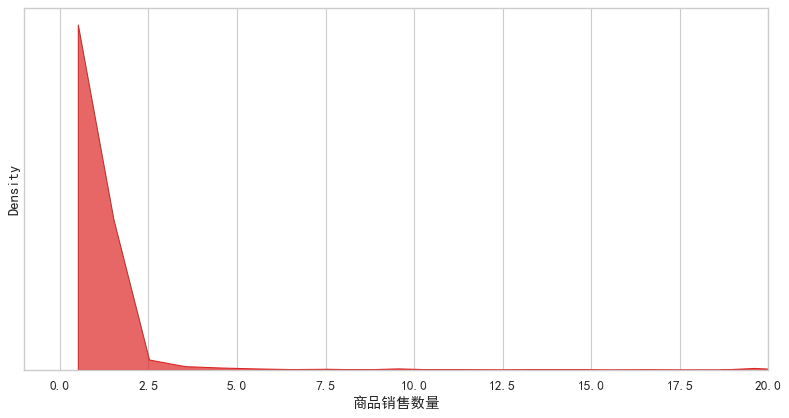

In [67]:
# 商品销售数量分布图 - range(-1,20)
plt.figure(figsize=(12, 6), dpi=80)
sns.kdeplot(data.loc[:, "商品销售数量"],
            shade=True,
            color="#dc2624",
            label="商品销售数量",
            alpha=.7)
sns.set(style="whitegrid",font="simhei", font_scale=1.1)
# plt.title("商品销售数量概率密度分布图",fontsize=18)
plt.xlim((-1,20))
plt.yticks([])
plt.show()

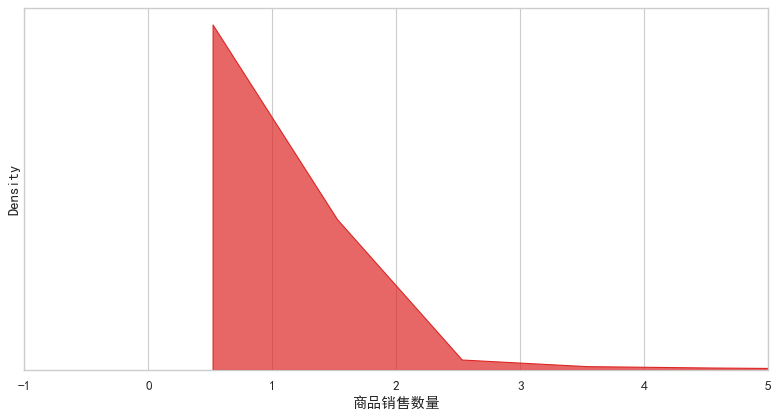

In [68]:
# 商品销售数量分布图 - range(-1,5)
plt.figure(figsize=(12, 6), dpi=80)
sns.kdeplot(data.loc[:, "商品销售数量"],
            shade=True,
            color="#dc2624",
            label="商品销售数量",
            alpha=.7)
sns.set(style="whitegrid",font="simhei", font_scale=1.1)
# plt.title("商品销售数量概率密度分布图",fontsize=18)
plt.xlim((-1,5))
plt.yticks([])
plt.show()

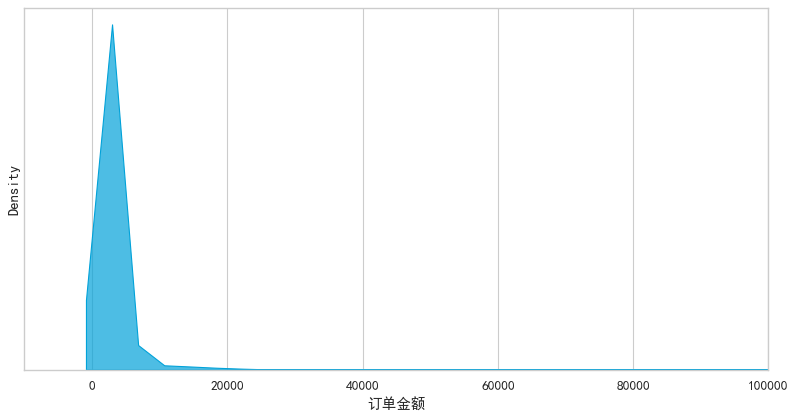

In [69]:
# 使用seaborn绘制分布图 - range(-10000,100000)
import seaborn as sns
plt.rcParams['font.sans-serif']=['Simhei']
plt.rcParams['axes.unicode_minus']=False
plt.figure(figsize=(12, 6), dpi=80)
# 绘图
sns.kdeplot(data.loc[:, "订单金额"],
            shade=True,
            color="#01a2d9",
            label="订单金额",
            alpha=.7)
sns.set(style="whitegrid",font="simhei", font_scale=1.1)
# plt.title("订单金额概率密度分布图",fontsize=18)
plt.xlim((-10000,100000))
plt.yticks([])
plt.show()

<div class="alert alert-block alert-success">
    
- 订单金额集中在3000元上下
- 商品销售数量大部分都是1-2个
- **数据分布都是极度左偏的，特征异常的基本情况是**：
    - 一次性下单太多商品
    - 一次性支付太贵的金额
    - 虽然以上情况在电商实际业务中都是可能实现的
</div>

**4.2 检测特征异常值：箱线图**

In [70]:
# 进行异常值检测，并保存特征异常的数据的索引
NumOfSamples = data.shape[0]
DataNoAbnormal = data.copy()
# 列表：用于保存特征异常的样本的索引
BoxAbnormalIdx = [] 
for idx,column in enumerate(["订单金额","商品销售数量"]):
    feature = data.loc[:,column]
    QL = np.quantile(feature,0.25)
    QU = np.quantile(feature,0.75)
    IQR = QU - QL
    # 过小或过大的都属于特征异常值
    error = feature[((feature < (QL - 1.5*IQR)).astype(int) + (feature > (QU + 1.5*IQR)).astype(int)) != 0]
    BoxAbnormalIdx.extend(error.index)

In [71]:
# 特征异常值数量（未去重）
len(BoxAbnormalIdx)

31266

In [72]:
# 利用集合对筛选出的数据索引进行去重
BoxAbnormalIdx = set(BoxAbnormalIdx) 

In [73]:
# 没有太多重复，这说明大部分数据只有一个特征存在异常
len(BoxAbnormalIdx) 

29949

In [74]:
# 占总体样本的比例太高，无法直接删除
len(BoxAbnormalIdx)/data.shape[0]

0.22812723754970216

**4.3 特征异常值和交易异常值有联系吗？**

In [75]:
# 特征异常数据中，有多少被标记为交易异常？
(data.loc[BoxAbnormalIdx,"异常"] == 1).sum()

7368

In [76]:
# 交易异常数据在所有特征异常数据中占比近25%，比例较大不能直接删除
(data.loc[BoxAbnormalIdx,"异常"] == 1).sum()/len(BoxAbnormalIdx) 

0.24601823099268758

<div class="alert alert-block alert-warning">
 
**思考：**     
1. 考虑到特征异常数据占总体数据的比例很高，且交易异常数据占特征异常数据的比例也很高，因此直接删除特征异常数据是不可行的。
2. 但同时，特征异常和交易异常应该无太直接的关系。如何验证呢？
</div>

<div class="alert alert-block alert-success">
    
- 可以按“是否有特征异常”构建新特征，计算该特征与标签的相关性。
</div>

In [77]:
df = pd.DataFrame(index=data.index)

In [78]:
df["特征异常"] = 0

In [79]:
df.loc[BoxAbnormalIdx,"特征异常"] = 1

In [80]:
pd.concat([df["特征异常"],data["异常"]],axis=1).corr()

,特征异常,异常
特征异常,1.000000,0.040428
异常,0.040428,1.000000


<div class="alert alert-block alert-success">
    
- 看起来特征异常与实际交易异常之间几乎不存在任何关系，我们可以不使用这个特征
- 从电商业务角度来看，异常基本出现在用户支付大量金额、或一次性购入大量物品的时候
- 因此我们先不处理异常值，先建模看看结果如何
</div>

## 二、深度挖掘：基于业务的特征工程与编码

In [81]:
data.columns

Index(['订单ID', '下单时间', '商品一级类别', '商品所属渠道', '商品ID', '品牌', '订单金额', '商品销售数量',
       '订单渠道', '支付方式', '下单用户ID', '城市', '异常'],
      dtype='object')

<div class="alert alert-block alert-warning">
 
**思考：**     
1. 特征工程：在进行实际的数据预处理之前，我们希望能够对特征进行详细的探索，以找到从业务上增加特征维度的契机。对于现在的数据集而言，我们建模的关键是希望能够辨别异常交易与普通交易，因此我们希望**找出能够帮我们增加异常交易与普通交易数据之间的区别的特征，或者一定程度上能够衡量数据的异常风险的特征。**
2. 特征编码：在此之前需先完成特征工程，因为编码后特征会失去业务信息。
</div>

<div class="alert alert-block alert-success">
    
- 特征工程：探索以下特征是否在交易上表现出特定性质，并基于这些性质衍生新特征。
    - 下单时间
    - 支付方式
    - 城市
    - 商品一级类别&商品ID&品牌
    - 下单用户ID
    - 订单金额&商品销售数量
    - 订单渠道&商品所属渠道
- 特征编码：离散型变量往往被认为是是容易编码的部分（通常使用sklearn中的ordinal、one-hot编码），但在实际工作中这些方法却不能适用于所有场景。
</div>

### 1. 粗略编码数据集，建立benchmark

<div class="alert alert-block alert-warning">
 
**思考：**     
1. 建模的第一步是建立benchmark。我们的数据集包含大量带有中文的离散型特征，我们必须对数据集进行编码后才能放入算法进行建模。
</div>

<div class="alert alert-block alert-success">
    
- **规范的操作是，我们先分割训练集测试集，对训练集进行学习，然后用训练集上产出的中间变量去编码/预处理测试集。**
- 但对于我们的数据集来说，精细的操作需要大量的代码，在建立benchmark的时候，我们可以简单粗暴地先使用**OrdinalEncoder**进行编码。
- 这样做简单快速，可以让我们快速掌握数据的基本情况，但存在几个缺陷：
    - 数据泄露。在预处理时使用测试集的数据，会让模型提前知道一部分测试集相关的信息和答案，因此得出的结果是虚高的，模型的泛化能力将大打折扣
    - 模型不具备编码新数据的能力，因此不能用于新数据，只能限制于当前数据
- **因此简单编码后跑benchmark是可以的，但在正式训练时我们不能这么做**。
</div>

In [82]:
data.head()

,订单ID,下单时间,商品一级类别,商品所属渠道,商品ID,品牌,订单金额,商品销售数量,订单渠道,支付方式,下单用户ID,城市,异常
0,4283851335,14:09:49,手机摄影数码,POP,8002042497,三星,766000.0,200,主站,合并支付,dakehu_zy,上海市,1
1,4276537082,14:16:47,电视冰箱洗衣机空调,POP,8001992420,樱花,19900.0,100,主站,合并支付,qq-3be293b,泉州市,1
2,4281111595,10:44:46,家具建材,POP,8002199518,纬度空间,100.0,100,主站,合并支付,nonscorpio,广州市,1
3,3977175284,23:26:19,手机摄影数码,POP,8002237611,伊斯贝,990.0,100,主站,合并支付,swt6263122,宁德市,0
4,4106833871,16:47:34,家居日用,POP,8002212182,品道天元,8800.0,100,主站,合并支付,qq-edf69d7,深圳市,0


In [83]:
from sklearn.preprocessing import OrdinalEncoder
# 帮助我们进行交叉验证计算
from sklearn.model_selection import train_test_split, cross_val_score
# 帮助我们交叉验证的具体方式
from sklearn.model_selection import KFold
# 常用随机森林分类器做benchmark
from sklearn.ensemble import RandomForestClassifier as RFC

In [84]:
# 实例化
oe = OrdinalEncoder()

In [85]:
X = data.iloc[:,1:-1]
y = data.iloc[:,-1]

In [86]:
# 转化为下单时间的小时数
X["下单时间"] = X["下单时间"].apply(lambda x:x[:2])

In [87]:
X.head()

,下单时间,商品一级类别,商品所属渠道,商品ID,品牌,订单金额,商品销售数量,订单渠道,支付方式,下单用户ID,城市
0,14,手机摄影数码,POP,8002042497,三星,766000.0,200,主站,合并支付,dakehu_zy,上海市
1,14,电视冰箱洗衣机空调,POP,8001992420,樱花,19900.0,100,主站,合并支付,qq-3be293b,泉州市
2,10,家具建材,POP,8002199518,纬度空间,100.0,100,主站,合并支付,nonscorpio,广州市
3,23,手机摄影数码,POP,8002237611,伊斯贝,990.0,100,主站,合并支付,swt6263122,宁德市
4,16,家居日用,POP,8002212182,品道天元,8800.0,100,主站,合并支付,qq-edf69d7,深圳市


In [88]:
X = pd.DataFrame(oe.fit_transform(X))

In [89]:
X.columns = data.iloc[:,1:-1].columns

In [90]:
X.head()

,下单时间,商品一级类别,商品所属渠道,商品ID,品牌,订单金额,商品销售数量,订单渠道,支付方式,下单用户ID,城市
0,14.0,5.0,1.0,15907.0,227.0,3009.0,41.0,1.0,0.0,24870.0,5.0
1,14.0,11.0,1.0,15431.0,1551.0,2970.0,40.0,1.0,0.0,50713.0,207.0
2,10.0,2.0,1.0,18402.0,2049.0,621.0,40.0,1.0,0.0,46259.0,133.0
3,23.0,5.0,1.0,19080.0,377.0,1499.0,40.0,1.0,0.0,62154.0,101.0
4,16.0,3.0,1.0,18580.0,748.0,2799.0,40.0,1.0,0.0,56469.0,223.0


In [91]:
# 常规的划分训练集和测试集
Xtrain,Xtest,Ytrain,Ytest = train_test_split(X,y,test_size=0.3,random_state=0)

In [92]:
# 使用最普通的K折交叉验证来建立benchmark
cv = KFold(n_splits=5,shuffle=True,random_state=0)

In [93]:
# 随机森林
clf = RFC(n_estimators=200,random_state=0)

In [94]:
%%time
# 准确率
acc = cross_val_score(clf,Xtrain,Ytrain,cv=cv)
acc

Wall time: 1min 20s


array([0.81153428, 0.81109902, 0.81272104, 0.81457098, 0.80853148])

In [95]:
acc.mean()

0.8116913582534734

In [96]:
acc.var()

3.942569412062227e-06

In [97]:
%%time
# AUC
auc = cross_val_score(clf,Xtrain,Ytrain,cv=cv,scoring="roc_auc")
auc

Wall time: 1min 19s


array([0.83029618, 0.82637231, 0.82721457, 0.83236152, 0.82483435])

In [98]:
auc.mean()

0.8282157880537102

In [99]:
auc.var()

7.470006547792926e-06

<div class="alert alert-block alert-success">
    
- **模型的交叉验证平均准确率81%，方差3.94\*10^6，交叉验证平均AUC0.828，方差7.47\*10^-6**，这就是我们的benchmark。
- 由于我们在预处理时直接对全数据做了预处理，也没有做任何避免数据泄露的特征工程，因此模型的效果是会虚高的，真实的状况应该比这个分数要低。
</div>

### 2. 基于订单ID分割训练集与测试集

<div class="alert alert-block alert-warning">
 
**思考：**     
1. 在开始进行特征工程之前，我们需要对训练集和测试集进行分割。
2. 对普通的数据来说训练集和测试集分割是一个很简单的步骤，但对于当前的数据来说却不是如此。
    - 在我们的数据集中，每条数据是针对单一商品的一笔交易，多笔交易构成了一个订单，且一个订单下所有数据的标签是一致的。在这种情况下，使用一个订单中的部分交易去预测相同订单中的其他交易是否异常没有意义，**我们已经很清楚，一笔交易异常，整个订单都异常。**
3. 事实上，**我们要做的是使用历史订单，预测未来的订单是否会异常**，因此在分割训练集和测试集时，我们**必须保证同一订单下的数据不会被同时分到训练集与测试集中，测试集中的订单ID一定是训练集中没有出现过的订单ID。**
</div>

<div class="alert alert-block alert-success">
    
- 为实现这个目的，我们需要**对订单ID，而非全部数据进行分割，然后再根据分割出的训练ID和测试ID构建训练集和测试集。**
    
</div>

In [100]:
data.groupby("订单ID").count().mean()[0]

1.1495092244783596

<div class="alert alert-block alert-success">
    
- 幸运的是，每个订单ID下平均只有1.15个条数据，这说明，如果训练ID与测试ID是7:3的比例，那构建出的训练集和测试集的数据比例应该也接近7:3。
    
</div>

In [101]:
orderid = data["订单ID"].unique()

In [102]:
# 一共有11.4w个订单
len(orderid) 

114207

In [103]:
# 直接从全部订单ID中，按照30%的比例，抽样出测试用的ID
import random
random.seed(0)
# 参数：需要抽样的总列表；需要抽样的比例
test_id=random.sample(orderid.tolist(),int(len(orderid)*0.3))

In [104]:
# 从总列表中剔除测试用的ID，得到训练用的ID
train_id = orderid.copy().tolist()
for i in test_id:
    train_id.remove(i)

In [105]:
len(train_id)

79945

In [106]:
len(test_id)

34262

In [107]:
# 根据分割出的订单ID,标记train/test
data["分割"] = "train"

for i in test_id:
    data.loc[data["订单ID"]==i,"分割"] = "test"
    
train = data.loc[data["分割"] == "train",:]
test = data.loc[data["分割"] == "test",:]

In [108]:
train.shape

(91831, 14)

In [109]:
test.shape

(39451, 14)

In [110]:
# 计算实际样本比例，确定样本分割比例与ID分割比例高度相似，几乎就是30%
39414/(91868+39414)

0.30022394539997865

In [111]:
# 恢复索引并删除'分割'列
for i in [train,test]:
    i.index = range(i.shape[0])
    i.drop(columns="分割",inplace=True)

In [112]:
train.shape

(91831, 13)

In [113]:
test.shape

(39451, 13)

In [114]:
train.head()

,订单ID,下单时间,商品一级类别,商品所属渠道,商品ID,品牌,订单金额,商品销售数量,订单渠道,支付方式,下单用户ID,城市,异常
0,4283851335,14:09:49,手机摄影数码,POP,8002042497,三星,766000.0,200,主站,合并支付,dakehu_zy,上海市,1
1,4281111595,10:44:46,家具建材,POP,8002199518,纬度空间,100.0,100,主站,合并支付,nonscorpio,广州市,1
2,4106833871,16:47:34,家居日用,POP,8002212182,品道天元,8800.0,100,主站,合并支付,qq-edf69d7,深圳市,0
3,4245023523,10:39:56,家具建材,POP,8002199518,纬度空间,100.0,100,主站,合并支付,nonscorpio,广州市,0
4,4253622967,21:15:59,电脑办公打印文仪,POP,8001748897,清华同方,880.0,100,主站,合并支付,benson2570,宿迁市,0


In [115]:
# 为了后续的特征工程和数据预处理方便，将标签列放到第一列
Xtrain = train.iloc[:,:-1]
Xtest = test.iloc[:,:-1]
Ytrain = train.iloc[:,-1]
Ytest = test.iloc[:,-1]

In [116]:
# 重新整合数据集（标签+特征）
train = pd.concat([Ytrain,Xtrain],axis=1)
test = pd.concat([Ytest,Xtest],axis=1)

In [117]:
train.head()

,异常,订单ID,下单时间,商品一级类别,商品所属渠道,商品ID,品牌,订单金额,商品销售数量,订单渠道,支付方式,下单用户ID,城市
0,1,4283851335,14:09:49,手机摄影数码,POP,8002042497,三星,766000.0,200,主站,合并支付,dakehu_zy,上海市
1,1,4281111595,10:44:46,家具建材,POP,8002199518,纬度空间,100.0,100,主站,合并支付,nonscorpio,广州市
2,0,4106833871,16:47:34,家居日用,POP,8002212182,品道天元,8800.0,100,主站,合并支付,qq-edf69d7,深圳市
3,0,4245023523,10:39:56,家具建材,POP,8002199518,纬度空间,100.0,100,主站,合并支付,nonscorpio,广州市
4,0,4253622967,21:15:59,电脑办公打印文仪,POP,8001748897,清华同方,880.0,100,主站,合并支付,benson2570,宿迁市


In [118]:
test.head()

,异常,订单ID,下单时间,商品一级类别,商品所属渠道,商品ID,品牌,订单金额,商品销售数量,订单渠道,支付方式,下单用户ID,城市
0,1,4276537082,14:16:47,电视冰箱洗衣机空调,POP,8001992420,樱花,19900.0,100,主站,合并支付,qq-3be293b,泉州市
1,0,3977175284,23:26:19,手机摄影数码,POP,8002237611,伊斯贝,990.0,100,主站,合并支付,swt6263122,宁德市
2,0,4281111696,10:49:28,家具建材,POP,8002199518,纬度空间,100.0,100,主站,合并支付,nonscorpio,广州市
3,0,4284735768,17:40:25,家居日用,POP,8002202146,奕辰,2028.0,52,主站,合并支付,dsjalfdsaj,安庆市
4,0,3675453285,17:07:34,家居日用,POP,8002202147,奕辰,1950.0,50,主站,合并支付,xdlkliukai,绍兴市


In [119]:
# 将训练集与测试集单独保存
train.to_csv(r'train_bf.csv')
test.to_csv(r'test_bf.csv')

<div class="alert alert-block alert-success">
    
- 现在可以开始进行特征工程与建模了。
- 此时，我们将不再了解测试集的任何信息，只针对训练集进行探索，且只使用训练集上提取的信息对测试集进行处理（客观特征，如时间等除外）。
    
</div>

### 3. 异常订单vs普通订单：下单时间有区别吗？

In [120]:
train = pd.read_csv(r'train_bf.csv',index_col=0)
test = pd.read_csv(r'test_bf.csv',index_col=0)

In [121]:
train.head()

,异常,订单ID,下单时间,商品一级类别,商品所属渠道,商品ID,品牌,订单金额,商品销售数量,订单渠道,支付方式,下单用户ID,城市
0,1,4283851335,14:09:49,手机摄影数码,POP,8002042497,三星,766000.0,200,主站,合并支付,dakehu_zy,上海市
1,1,4281111595,10:44:46,家具建材,POP,8002199518,纬度空间,100.0,100,主站,合并支付,nonscorpio,广州市
2,0,4106833871,16:47:34,家居日用,POP,8002212182,品道天元,8800.0,100,主站,合并支付,qq-edf69d7,深圳市
3,0,4245023523,10:39:56,家具建材,POP,8002199518,纬度空间,100.0,100,主站,合并支付,nonscorpio,广州市
4,0,4253622967,21:15:59,电脑办公打印文仪,POP,8001748897,清华同方,880.0,100,主站,合并支付,benson2570,宿迁市


**3.1 关系探索**

In [122]:
import time
import datetime
import seaborn as sns

In [123]:
# 将时间字符串按小时数提取为单独的Series
train["下单时间"][0][:2]

'14'

In [124]:
Hour = train.loc[:,"下单时间"].apply(lambda x: int(x[:2]))

In [125]:
# 计算每个小时内的交易数量
OrderTime_ab = Hour[train["异常"] == 1].value_counts()
OrderTime_normal = Hour[train["异常"] == 0].value_counts()

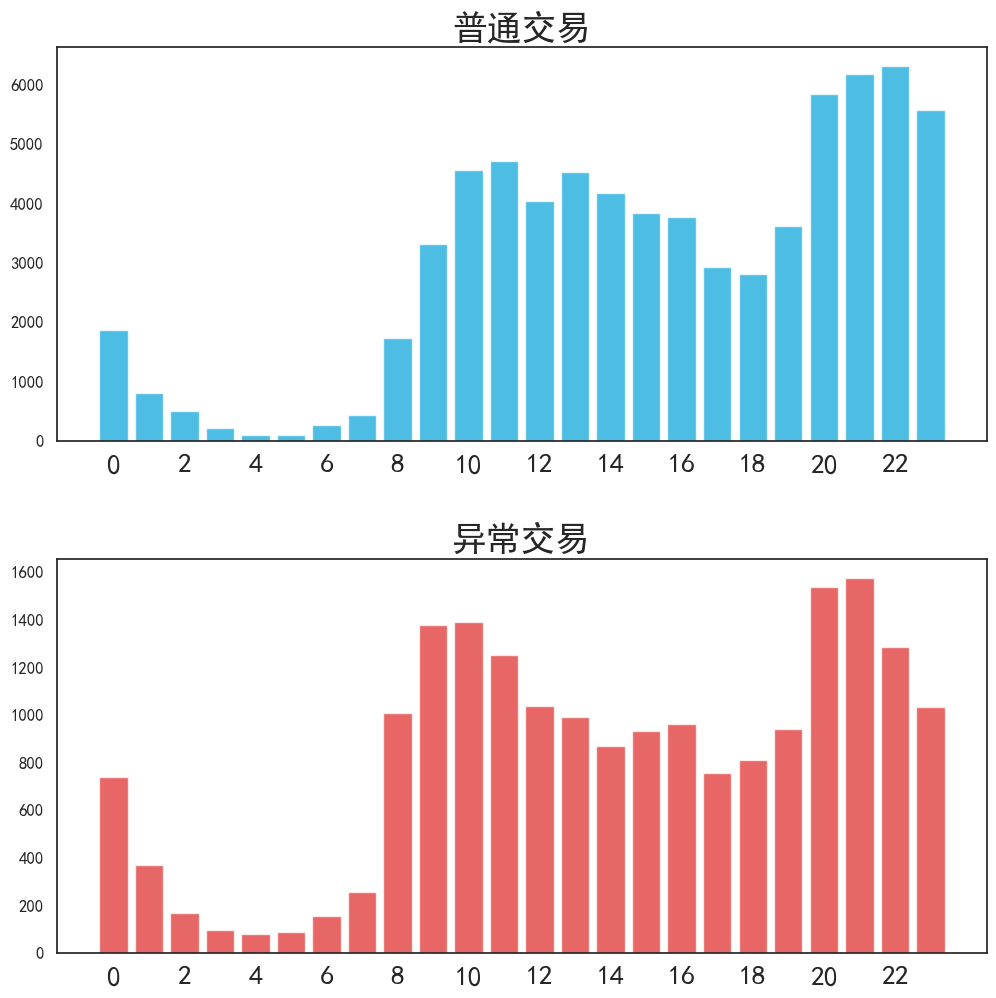

In [126]:
plt.figure(figsize=(12,12),dpi=100)
sns.set(style="white",font="Simhei", font_scale=1.1)
# 绘制两个坐标轴不一样的图像

# 上
plt.subplot(211)
plt.bar(OrderTime_normal.index,OrderTime_normal.values,color="#01a2d9",alpha=0.7)
plt.title("普通交易",fontsize=25)
plt.xticks(ticks = range(0,24,2),fontsize=20)

# 下
plt.subplot(212)
plt.bar(OrderTime_ab.index,OrderTime_ab.values,color="#dc2624",alpha=0.7)
plt.title("异常交易",fontsize=25)
plt.xticks(ticks = range(0,24,2),fontsize=20)

plt.subplots_adjust(hspace=0.3)
plt.show()

<div class="alert alert-block alert-success">
    
- 如果两种类型的订单下单时间有区别，那异常交易一般倾向于发生在半夜、凌晨或是其他不常见的时间。但很明显，**异常交易与普通订单的下单时间并无显著差异，下单时间很可能与交易是否异常无关。**
- 但由于本身的特征数量很少，我们保留这个特征，并**将其转化为小时和分钟**。其中小时按24小时进行编码，分钟按前半小时、后半小时分别编码为0与1。
    - 这是由于电商行业中，经常会有一些定时活动大促，前后半小时会有不同
    
</div>

**3.2 特征编码**

In [127]:
train["下单时间"]

0        14:09:49
1        10:44:46
2        16:47:34
3        10:39:56
4        21:15:59
           ...   
91826    23:56:01
91827    23:57:24
91828    23:54:34
91829    23:55:06
91830    23:58:59
Name: 下单时间, Length: 91831, dtype: object

<div class="alert alert-block alert-warning">
 
**思考：**     
1. 时间是一个很特殊的特征，由于训练集与测试集中都是按照完全客观的规则（小时和分钟）进行编码，且编码方式与训练集中的具体数值并无关系，因此不存在泄露问题。
</div>

<div class="alert alert-block alert-success">
    
- 因此，我们可以采用最直接简单的方式：也就是用lambda进行编码。
    
</div>

In [128]:
# 本函数用于转化分钟 
def encodeM(column,train,test,newcolumn="下单分钟"):
    dic = {}
    feature = train.loc[:,column].apply(lambda x: (int(x[3:5]) > 30))
    unique_ = np.sort(feature.unique())
    for code, category in enumerate(unique_):
        dic[category] = code
        
    # 如果需要，重建用于覆盖的特征
    train[newcolumn] = feature
    train[newcolumn] = train[newcolumn].map(dic)
    
    # 使用训练集上生成的字典转化测试集
    test[newcolumn] = test.loc[:,column].apply(lambda x: (int(x[3:5]) > 30))
    test[newcolumn] = test[newcolumn].map(dic)
    
    return train,test

In [129]:
# 本函数用于转化小时
def encodeH(column,train,test,newcolumn="下单小时"):
    dic = {}
    feature = train.loc[:,column].apply(lambda x: x[:2])
    unique_ = np.sort(feature.unique())
    for code, category in enumerate(unique_):
        dic[category] = code
        
    # 如果需要，重建用于覆盖的特征
    train[newcolumn] = feature
    train[newcolumn] = train[newcolumn].map(dic)
    
    # 使用训练集上生成的字典转化测试集
    test[newcolumn] = test.loc[:,column].apply(lambda x: x[:2])
    test[newcolumn] = test[newcolumn].map(dic)
    
    return train,test

In [130]:
train,test = encodeM("下单时间",train,test)
train,test = encodeH("下单时间",train,test)

In [131]:
# 删除原先的下单时间
train.drop(columns="下单时间",inplace=True)
test.drop(columns="下单时间",inplace=True)

In [132]:
train.head()

,异常,订单ID,商品一级类别,商品所属渠道,商品ID,品牌,订单金额,商品销售数量,订单渠道,支付方式,下单用户ID,城市,下单分钟,下单小时
0,1,4283851335,手机摄影数码,POP,8002042497,三星,766000.0,200,主站,合并支付,dakehu_zy,上海市,0,14
1,1,4281111595,家具建材,POP,8002199518,纬度空间,100.0,100,主站,合并支付,nonscorpio,广州市,1,10
2,0,4106833871,家居日用,POP,8002212182,品道天元,8800.0,100,主站,合并支付,qq-edf69d7,深圳市,1,16
3,0,4245023523,家具建材,POP,8002199518,纬度空间,100.0,100,主站,合并支付,nonscorpio,广州市,1,10
4,0,4253622967,电脑办公打印文仪,POP,8001748897,清华同方,880.0,100,主站,合并支付,benson2570,宿迁市,0,21


In [133]:
# 将处理后的数据单独保存
train.to_csv(r'train.csv')
test.to_csv(r'test.csv')

### 4. 支付方式：支付渠道的异常风险评估

In [134]:
train = pd.read_csv(r'train.csv',index_col=0)
test = pd.read_csv(r'test.csv',index_col=0)

In [135]:
train["支付方式"].value_counts()

合并支付    71938
货到付款    18238
当当支付     1237
在线支付      289
账户余额      129
Name: 支付方式, dtype: int64

<div class="alert alert-block alert-warning">
 
**思考：**     
1. 在数据集中，共有五大类支付方式，而五大类支付方式下的订单异常风险不同。
    - 有的支付方式可能有很高的风险，例如**合并支付**。如果商家进行刷单，或者竞争对手恶意刷单，那他们应该会倾向于使用简单明了的合并支付或在线支付方式。
    - 同时，**货到付款**时一个异常风险很低的方式，因为平台的“货到付款”功能往往只开放给极度受信任、或信用评级很高的用户，因此很少会出现恶意订单。相对的，货到付款的主要异常风险在于物流风险。
</div>

<div class="alert alert-block alert-success">
    
- 异常风险的关键评估指标：异常率
- **异常率是指异常交易/全部交易的比例，异常率越高则说明异常风险越高。**
- 对于每个特征，我们都可以计算其不同类别下的异常率，以确定特定特征/特定类别与异常风险的关系。
    
</div>

**4.1 聚合特征 - 支付方式异常率**

In [136]:
# 每个支付方式的订单异常率
train.groupby("支付方式")["异常"].mean()

支付方式
合并支付    0.272234
在线支付    0.242215
当当支付    0.042846
账户余额    0.023256
货到付款    0.000000
Name: 异常, dtype: float64

<div class="alert alert-block alert-success">
    
- 果然，合并支付与在线支付两种方式的异常率很高，占了该支付方式下全部样本的25%以上，剩下的支付方式风险很小。
- 我们可以将该**支付方式异常率**作为聚合特征放入特征矩阵。
</div>

<div class="alert alert-block alert-warning">
 
**思考：**     
1. 聚合特征是使用groupby函数对离散型变量进行聚合后获得的新特征，该新特征中每一个类别对应一个值，该值对于该类别具有某种业务意义。
2. 在实际应用中，大量增加聚合特征可以极大诚度地提升树及集成模型的表现。所以理论上来说，只要有业务意义，我们可以按照支付支付方式对任意特征进行聚合。
3. 在这里，我们**对异常特征聚合求解异常率并作为特征放入特征矩阵**作为例子。
</div>

In [137]:
# 计算聚合异常率并放入特征矩阵的函数
def GroupByFeature(column,train,test,newcolumn):
    
    #使用训练集数据创建字典
    dic = dict(train.groupby(column)["异常"].mean())
    
    #建立新特征
    train[newcolumn] = train[column].map(dic)
    test[newcolumn] = test[column].map(dic)
    
    return train, test

In [138]:
train,test = GroupByFeature("支付方式",train,test,"支付方式异常率")

In [139]:
train.head()

,异常,订单ID,商品一级类别,商品所属渠道,商品ID,品牌,订单金额,商品销售数量,订单渠道,支付方式,下单用户ID,城市,下单分钟,下单小时,支付方式异常率
0,1,4283851335,手机摄影数码,POP,8002042497,三星,766000.0,200,主站,合并支付,dakehu_zy,上海市,0,14,0.272234
1,1,4281111595,家具建材,POP,8002199518,纬度空间,100.0,100,主站,合并支付,nonscorpio,广州市,1,10,0.272234
2,0,4106833871,家居日用,POP,8002212182,品道天元,8800.0,100,主站,合并支付,qq-edf69d7,深圳市,1,16,0.272234
3,0,4245023523,家具建材,POP,8002199518,纬度空间,100.0,100,主站,合并支付,nonscorpio,广州市,1,10,0.272234
4,0,4253622967,电脑办公打印文仪,POP,8001748897,清华同方,880.0,100,主站,合并支付,benson2570,宿迁市,0,21,0.272234


In [140]:
test.head()

,异常,订单ID,商品一级类别,商品所属渠道,商品ID,品牌,订单金额,商品销售数量,订单渠道,支付方式,下单用户ID,城市,下单分钟,下单小时,支付方式异常率
0,1,4276537082,电视冰箱洗衣机空调,POP,8001992420,樱花,19900.0,100,主站,合并支付,qq-3be293b,泉州市,0,14,0.272234
1,0,3977175284,手机摄影数码,POP,8002237611,伊斯贝,990.0,100,主站,合并支付,swt6263122,宁德市,0,23,0.272234
2,0,4281111696,家具建材,POP,8002199518,纬度空间,100.0,100,主站,合并支付,nonscorpio,广州市,1,10,0.272234
3,0,4284735768,家居日用,POP,8002202146,奕辰,2028.0,52,主站,合并支付,dsjalfdsaj,安庆市,1,17,0.272234
4,0,3675453285,家居日用,POP,8002202147,奕辰,1950.0,50,主站,合并支付,xdlkliukai,绍兴市,0,17,0.272234


**4.2 特征编码**

In [141]:
# 本函数用于转化支付方式
def encodePay(column,train,test):
    dic = {}
    feature = train.loc[:,column]
    unique_ = np.sort(feature.unique())
    for code, category in enumerate(unique_):
        dic[category] = code
        
    # 如果需要，重建用于覆盖的特征
    train[column] = train[column].map(dic)
    
    # 使用训练集上生成的字典转化测试集
    test[column] = test[column].map(dic)
    
    return train,test

In [142]:
train,test = encodePay("支付方式",train,test)

In [143]:
train["支付方式"].value_counts()

0    71938
4    18238
2     1237
1      289
3      129
Name: 支付方式, dtype: int64

In [144]:
# 将处理后的数据单独保存
train.to_csv(r'train.csv')
test.to_csv(r'test.csv')

### 5. 城市：收货地点的风险评估

In [145]:
train = pd.read_csv(r'train.csv',index_col=0)
test = pd.read_csv(r'test.csv',index_col=0)

<div class="alert alert-block alert-warning">
 
**思考：**     
1. 从理论上来说，收货地点与交易异常应该不存在明显的联系，但我们还是可以使用异常率来进行相关的评估。
2. 需要注意的是，城市的类别虽然只有365个，但还是远远超出一般离散型特征的分类个数，如果按照这个数量的类别进行风险评估，很难看出有用的趋势。
</div>

<div class="alert alert-block alert-success">
    
- 因此，我们需要降低城市类别数量再进行风险评估。在这里，我们**将365个城市按照省进行分类，并按省份进行聚合。**
</div>

**5.1 聚合特征 - 省份异常率**

In [146]:
ChinaCity = pd.read_excel(r"ChinaCity.xls",index_col=1)

In [147]:
ChinaCity

,省份
市级,
北京市,北京市
天津市,天津市
石家庄市,河北省
唐山市,河北省
秦皇岛市,河北省
...,...
辽宁省其他城市,辽宁省
四川省其他城市,四川省
广东省其他城市,广东省


In [148]:
# 化为Series，方便字典的建立
dict(ChinaCity["省份"])

{'北京市': '北京市',
 '天津市': '天津市',
 '石家庄市': '河北省',
 '唐山市': '河北省',
 '秦皇岛市': '河北省',
 '邯郸市': '河北省',
 '邢台市': '河北省',
 '保定市': '河北省',
 '张家口市': '河北省',
 '承德市': '河北省',
 '沧州市': '河北省',
 '廊坊市': '河北省',
 '衡水市': '河北省',
 '太原市': '山西省',
 '大同市': '山西省',
 '阳泉市': '山西省',
 '长治市': '山西省',
 '晋城市': '山西省',
 '朔州市': '山西省',
 '忻州市': '山西省',
 '吕梁市': '山西省',
 '晋中市': '山西省',
 '临汾市': '山西省',
 '运城市': '山西省',
 '呼和浩特市': '内蒙古自治区',
 '包头市': '内蒙古自治区',
 '乌海市': '内蒙古自治区',
 '赤峰市': '内蒙古自治区',
 '呼伦贝尔市': '内蒙古自治区',
 '兴安盟': '内蒙古自治区',
 '通辽市': '内蒙古自治区',
 '锡林郭勒盟': '内蒙古自治区',
 '乌兰察布市': '内蒙古自治区',
 '鄂尔多斯市': '内蒙古自治区',
 '巴彦淖尔市': '内蒙古自治区',
 '阿拉善盟': '内蒙古自治区',
 '沈阳市': '辽宁省',
 '大连市': '辽宁省',
 '鞍山市': '辽宁省',
 '抚顺市': '辽宁省',
 '本溪市': '辽宁省',
 '丹东市': '辽宁省',
 '锦州市': '辽宁省',
 '营口市': '辽宁省',
 '阜新市': '辽宁省',
 '辽阳市': '辽宁省',
 '盘锦市': '辽宁省',
 '铁岭市': '辽宁省',
 '朝阳市': '辽宁省',
 '葫芦岛市': '辽宁省',
 '长春市': '吉林省',
 '吉林市': '吉林省',
 '四平市': '吉林省',
 '辽源市': '吉林省',
 '通化市': '吉林省',
 '白山市': '吉林省',
 '松原市': '吉林省',
 '白城市': '吉林省',
 '延边州': '吉林省',
 '哈尔滨市': '黑龙江省',
 '齐齐哈尔市': '黑龙江省',
 '鸡西市': '黑龙江省',
 '鹤岗市': '黑龙

In [149]:
train["省份"] = train["城市"].map(dict(ChinaCity["省份"]))

In [150]:
# 由于匹配数据不是我们自己编写，一定要确认map之后没有缺失值
train["省份"].isnull().sum()

1

In [151]:
# 找出这一空值
train[train.isnull().T.any()]

,异常,订单ID,商品一级类别,商品所属渠道,商品ID,品牌,订单金额,商品销售数量,订单渠道,支付方式,下单用户ID,城市,下单分钟,下单小时,支付方式异常率,省份
83233,0,4283977714,生活电器厨卫电器,GO,1000006426,飞利浦,299.0,1,主站,4,1587002842,江西省其他城市,1,13,0.0,NaN


In [152]:
# 赋值
train.loc[83233,'省份']= '江西省' 

In [153]:
train[train['城市']=='江西省其他城市']['省份']='江西省'

In [154]:
train["省份"].isnull().sum()

0

In [155]:
# 计算每个省份的订单异常率
train.groupby(["省份"])["异常"].mean().sort_values(ascending=False)

省份
青海省         0.360656
西藏自治区       0.346154
内蒙古自治区      0.305352
宁夏回族自治区     0.271429
海南省         0.251938
山西省         0.246785
陕西省         0.240628
河北省         0.240465
江西省         0.240236
甘肃省         0.240057
北京市         0.236737
天津市         0.228609
重庆市         0.228412
新疆维吾尔自治区    0.227911
云南省         0.222814
广东省         0.221112
吉林省         0.218978
河南省         0.216898
福建省         0.216120
辽宁省         0.214013
浙江省         0.213200
湖南省         0.212853
山东省         0.211121
江苏省         0.210295
湖北省         0.205596
上海市         0.203057
广西壮族自治区     0.194857
四川省         0.189585
黑龙江省        0.171343
安徽省         0.168142
贵州省         0.072191
Name: 异常, dtype: float64

In [156]:
df = train.groupby(["省份"])["异常"].mean().sort_values(ascending=False)

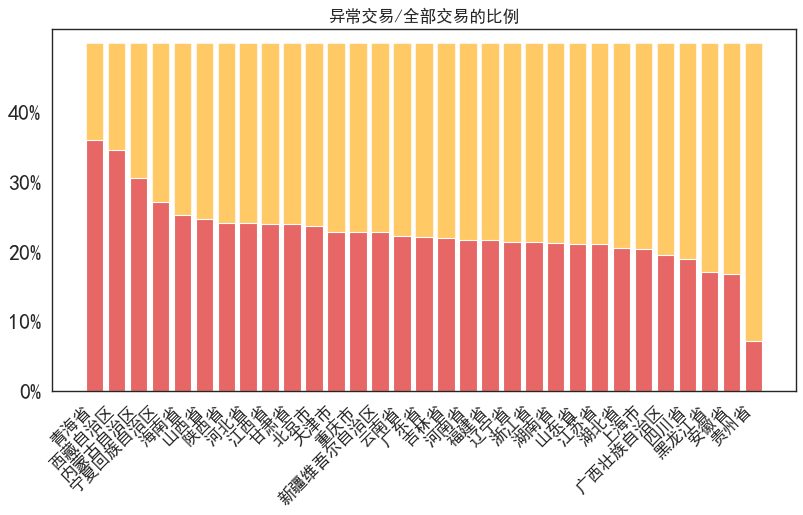

In [157]:
plt.figure(figsize=(12,6),dpi=80)
sns.set(style="white",font="Simhei", font_scale=1.1)

plt.bar(df.index,0.5,color="orange",alpha=0.6,)
plt.bar(df.index,df.values,color="#e66765",alpha=1)
plt.title("异常交易/全部交易的比例",fontsize=15)
plt.ylim(0, 0.52)
plt.yticks(ticks=np.arange(0,0.5,step=0.1),labels=["0%","10%","20%","30%","40%"],fontsize=20)
plt.xticks(range(len(df)),df.index,fontsize=15,rotation=45,ha='right')
plt.show()

<div class="alert alert-block alert-success">
    
- 异常率在省份上表现出较大的差异，其中青海、内蒙古自治区、以及西藏自治区的的异常率远高于其他城市，可能是由于物流发展程度较低导致。
- 同时异常订单较多的省市或多或少都有大量少数民族自治区。
- 同时安徽、黑龙江、四川、贵州异常率很低（低于20%），光从省份上来说很难看出实际原因，可能是订单本身较少的缘故。
- 其他大部分城市的异常率都在20~25%之间，说明这个异常率对各个省份来说都是正常的。
- 现在，我们可以**将依据省份进行聚合的异常率作为新的特征放入特征矩阵**。
</div>

In [158]:
# 对测试集也进行构造
test["省份"] = test["城市"].map(dict(ChinaCity["省份"]))

In [159]:
test["省份"].isnull().sum()

2

In [160]:
# 找出空值
test[test.isnull().T.any()]

,异常,订单ID,商品一级类别,商品所属渠道,商品ID,品牌,订单金额,商品销售数量,订单渠道,支付方式,下单用户ID,城市,下单分钟,下单小时,支付方式异常率,省份
9557,1,4282946649,手机摄影数码,GO,1000376628,斐讯,399.0,1,主站,0,aiai131452,山西省其他城市,1,7,0.272234,NaN
11851,0,3809475249,母婴用品玩具,POP,8001276188,大贸商,109.0,1,主站,0,guoqingas,山东省其他城市,1,10,0.272234,NaN


In [161]:
# 赋值
test.loc[9557,'省份'] = '山西省'
test.loc[11851,'省份'] = '山东省' 

In [162]:
test["省份"].isnull().sum()

0

In [163]:
# 检查是否需要在特征构建函数上稍作修改
def GroupByFeature(column,train,test,newcolumn):
    
    #使用训练集数据创建字典
    dic = dict(train.groupby(column)["异常"].mean())
    
    #建立新特征
    train[newcolumn] = train[column].map(dic)
    test[newcolumn] = test[column].map(dic)
    
    return train, test

In [164]:
train, test = GroupByFeature("省份",train,test,"省份异常率")

In [165]:
# 再次确认训练集、测试集中没有缺失值。
train.isnull().sum().sum()

0

In [166]:
test.isnull().sum().sum()

0

In [167]:
train.head()

,异常,订单ID,商品一级类别,商品所属渠道,商品ID,品牌,订单金额,商品销售数量,订单渠道,支付方式,下单用户ID,城市,下单分钟,下单小时,支付方式异常率,省份,省份异常率
0,1,4283851335,手机摄影数码,POP,8002042497,三星,766000.0,200,主站,0,dakehu_zy,上海市,0,14,0.272234,上海市,0.203057
1,1,4281111595,家具建材,POP,8002199518,纬度空间,100.0,100,主站,0,nonscorpio,广州市,1,10,0.272234,广东省,0.221112
2,0,4106833871,家居日用,POP,8002212182,品道天元,8800.0,100,主站,0,qq-edf69d7,深圳市,1,16,0.272234,广东省,0.221112
3,0,4245023523,家具建材,POP,8002199518,纬度空间,100.0,100,主站,0,nonscorpio,广州市,1,10,0.272234,广东省,0.221112
4,0,4253622967,电脑办公打印文仪,POP,8001748897,清华同方,880.0,100,主站,0,benson2570,宿迁市,0,21,0.272234,江苏省,0.210295


In [168]:
test.head()

,异常,订单ID,商品一级类别,商品所属渠道,商品ID,品牌,订单金额,商品销售数量,订单渠道,支付方式,下单用户ID,城市,下单分钟,下单小时,支付方式异常率,省份,省份异常率
0,1,4276537082,电视冰箱洗衣机空调,POP,8001992420,樱花,19900.0,100,主站,0,qq-3be293b,泉州市,0,14,0.272234,福建省,0.216120
1,0,3977175284,手机摄影数码,POP,8002237611,伊斯贝,990.0,100,主站,0,swt6263122,宁德市,0,23,0.272234,福建省,0.216120
2,0,4281111696,家具建材,POP,8002199518,纬度空间,100.0,100,主站,0,nonscorpio,广州市,1,10,0.272234,广东省,0.221112
3,0,4284735768,家居日用,POP,8002202146,奕辰,2028.0,52,主站,0,dsjalfdsaj,安庆市,1,17,0.272234,安徽省,0.168142
4,0,3675453285,家居日用,POP,8002202147,奕辰,1950.0,50,主站,0,xdlkliukai,绍兴市,0,17,0.272234,浙江省,0.213200


**5.2 特征编码**

In [169]:
# 本函数用于编码城市与省份
def encodeCityProvince(column,train,test):
    dic = {}
    feature = train.loc[:,column]
    unique_ = np.sort(feature.unique())
    for code, category in enumerate(unique_):
        dic[category] = code
        
    #如果需要，重建用于覆盖的特征
    train[column] = train[column].map(dic)
    
    #使用训练集上生成的字典转化测试集
    test[column] = test[column].map(dic)
    
    return train,test

In [170]:
for column in ["城市","省份"]:
    train,test = encodeCityProvince(column,train,test)

In [171]:
train.head()

,异常,订单ID,商品一级类别,商品所属渠道,商品ID,品牌,订单金额,商品销售数量,订单渠道,支付方式,下单用户ID,城市,下单分钟,下单小时,支付方式异常率,省份,省份异常率
0,1,4283851335,手机摄影数码,POP,8002042497,三星,766000.0,200,主站,0,dakehu_zy,5,0,14,0.272234,0,0.203057
1,1,4281111595,家具建材,POP,8002199518,纬度空间,100.0,100,主站,0,nonscorpio,131,1,10,0.272234,11,0.221112
2,0,4106833871,家居日用,POP,8002212182,品道天元,8800.0,100,主站,0,qq-edf69d7,220,1,16,0.272234,11,0.221112
3,0,4245023523,家具建材,POP,8002199518,纬度空间,100.0,100,主站,0,nonscorpio,131,1,10,0.272234,11,0.221112
4,0,4253622967,电脑办公打印文仪,POP,8001748897,清华同方,880.0,100,主站,0,benson2570,115,0,21,0.272234,14,0.210295


In [172]:
test.head()

,异常,订单ID,商品一级类别,商品所属渠道,商品ID,品牌,订单金额,商品销售数量,订单渠道,支付方式,下单用户ID,城市,下单分钟,下单小时,支付方式异常率,省份,省份异常率
0,1,4276537082,电视冰箱洗衣机空调,POP,8001992420,樱花,19900.0,100,主站,0,qq-3be293b,204.0,0,14,0.272234,23,0.216120
1,0,3977175284,手机摄影数码,POP,8002237611,伊斯贝,990.0,100,主站,0,swt6263122,101.0,0,23,0.272234,23,0.216120
2,0,4281111696,家具建材,POP,8002199518,纬度空间,100.0,100,主站,0,nonscorpio,131.0,1,10,0.272234,11,0.221112
3,0,4284735768,家居日用,POP,8002202146,奕辰,2028.0,52,主站,0,dsjalfdsaj,103.0,1,17,0.272234,8,0.168142
4,0,3675453285,家居日用,POP,8002202147,奕辰,1950.0,50,主站,0,xdlkliukai,264.0,0,17,0.272234,18,0.213200


In [173]:
train.isnull().sum()

异常         0
订单ID       0
商品一级类别     0
商品所属渠道     0
商品ID       0
品牌         0
订单金额       0
商品销售数量     0
订单渠道       0
支付方式       0
下单用户ID     0
城市         0
下单分钟       0
下单小时       0
支付方式异常率    0
省份         0
省份异常率      0
dtype: int64

In [174]:
# 有缺失值
# 是由于‘城市’特征中类别数量太多，
# 分割训练集测试集后，测试集中可能会出现训练集中从未见过的类别。
test.isnull().sum()

异常         0
订单ID       0
商品一级类别     0
商品所属渠道     0
商品ID       0
品牌         0
订单金额       0
商品销售数量     0
订单渠道       0
支付方式       0
下单用户ID     0
城市         3
下单分钟       0
下单小时       0
支付方式异常率    0
省份         0
省份异常率      0
dtype: int64

In [175]:
# 找出空值
test[test.isnull().T.any()]

,异常,订单ID,商品一级类别,商品所属渠道,商品ID,品牌,订单金额,商品销售数量,订单渠道,支付方式,下单用户ID,城市,下单分钟,下单小时,支付方式异常率,省份,省份异常率
9557,1,4282946649,手机摄影数码,GO,1000376628,斐讯,399.0,1,主站,0,aiai131452,NaN,1,7,0.272234,10,0.246785
11851,0,3809475249,母婴用品玩具,POP,8001276188,大贸商,109.0,1,主站,0,guoqingas,NaN,1,10,0.272234,9,0.211121
26641,0,4277131024,手机摄影数码,POP,8002275964,诺基亚,1539.0,1,主站,0,1123849787,NaN,1,18,0.272234,24,0.346154


In [176]:
test['城市'].max()

361.0

In [177]:
# 因为城市未知，赋一个未出现的值（主要是因为空值太少
# 也可以回到原本数据查看
test.loc[test["城市"].isnull(),"城市"] = 362

In [178]:
test.isnull().sum().sum()

0

In [179]:
# 将处理后的数据单独保存
train.to_csv(r'train.csv')
test.to_csv(r'test.csv')

### 6. 离散型变量：商品类别、订单渠道以及商品渠道

In [180]:
train = pd.read_csv(r'train.csv',index_col=0)
test = pd.read_csv(r'test.csv',index_col=0)

<div class="alert alert-block alert-warning">
 
**思考：**     
1. 如果某一类/某一件商品具有较高的退货、敲诈、纠纷风险，那这一类/一件商品的订单中、异常订单的比例应该很高。
</div>

<div class="alert alert-block alert-success">
    
- 如果存在这种**商品类别**，我们则可以在特征工程中单独标注高风险商品。
- 同理，对于**订单渠道**和**商品渠道**，我们也可以按异常率增加特征。
</div>

**6.1 商品类别**

In [181]:
train.groupby("商品一级类别")["异常"].mean()

商品一级类别
健康医疗         0.233232
图书音像         0.286517
家具建材         0.247814
家居日用         0.233941
家纺寝居         0.170344
手机摄影数码       0.258937
服饰鞋帽         0.281130
母婴用品玩具       0.181428
汽车用品         0.214174
生活电器厨卫电器     0.195460
电脑办公打印文仪     0.219469
电视冰箱洗衣机空调    0.198993
箱包奢品         0.341893
美妆个护         0.140461
运动户外         0.233177
钟表首饰         0.359322
食品酒水         0.196373
Name: 异常, dtype: float64

In [182]:
df = train.groupby("商品一级类别")["异常"].mean().sort_values()

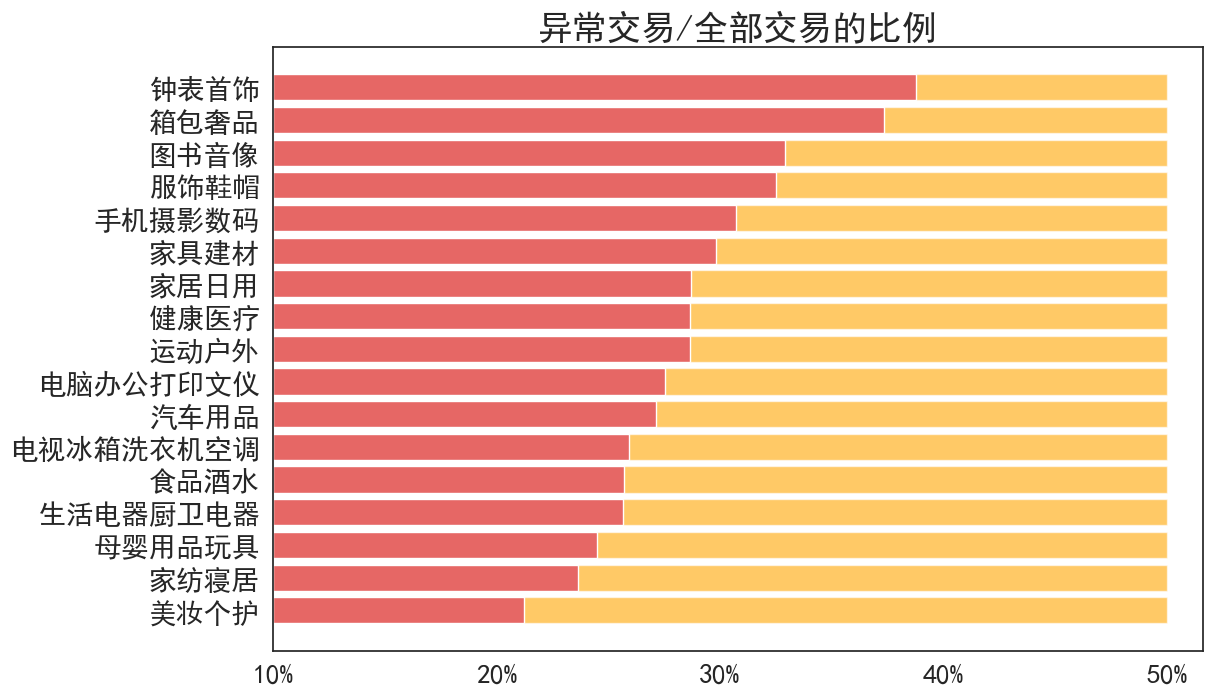

In [183]:
plt.figure(figsize=(12,8),dpi=100)
sns.set(style="white",font="Simhei", font_scale=1.1)

plt.barh(df.index,0.5,color="orange",alpha=0.6,)
plt.barh(df.index,df.values,color="#e66765",alpha=1)
plt.title("异常交易/全部交易的比例",fontsize=25)
plt.xlim(0, 0.52)
plt.xticks(ticks=np.linspace(0,0.5,num=5),labels=["10%","20%","30%","40%","50%"],fontsize=20)
plt.yticks(range(17),df.index,fontsize=20)
plt.show()

<div class="alert alert-block alert-success">
    
- 从结果来看，异常交易比例最高的是钟表首饰、箱包奢品、图书音像，最低的是家纺、母婴用品以及美妆产品，但并未出现某一品类的异常比例严重高于其他品类的情况。
- 异常率可以衡量一个品类的商品“可能是异常交易的风险”，因此在特征工程中，我们可以将**商品类别异常率**作为一个聚合特征，放入我们的特征矩阵。
</div>

**6.2 订单渠道**

In [184]:
train.groupby("订单渠道")["异常"].mean().sort_values(ascending=False)

订单渠道
手机团购          0.498670
抢购            0.393027
手机抢购          0.335967
团购            0.333333
手机站点          0.278989
当当            0.205426
主站            0.167217
do.site_id    0.096049
Name: 异常, dtype: float64

In [185]:
df2 = train.groupby("订单渠道")["异常"].mean().sort_values()

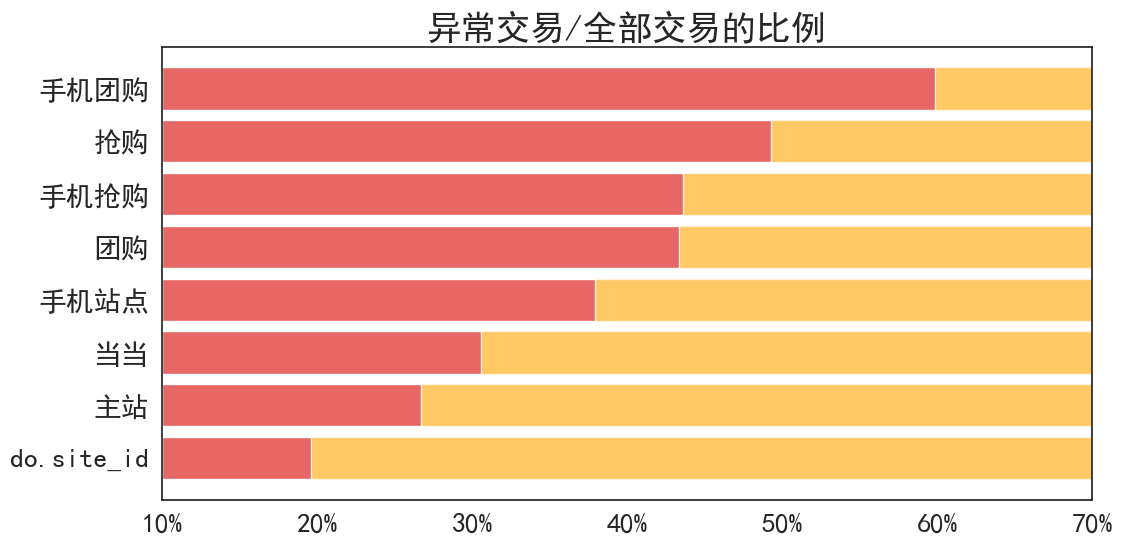

In [186]:
plt.figure(figsize=(12,6),dpi=100)
sns.set(style="white",font="Simhei", font_scale=1.1)

plt.barh(df2.index,1,color="orange",alpha=0.6,)
plt.barh(df2.index,df2.values,color="#e66765",alpha=1)
plt.title("异常交易/全部交易的比例",fontsize=25)
plt.xlim(0, 0.52)
plt.xticks(ticks=np.linspace(0,0.6,num=7),labels=["10%","20%","30%","40%","50%","60%","70%"],fontsize=20)
plt.yticks(range(len(df2)),df2.index,fontsize=20)
plt.show()

<div class="alert alert-block alert-success">
    
- 团购、抢购模式出现异常的可能性很高
- 移动端比PC端出现异常的可能性更高。
</div>

**6.3 商品渠道**

In [187]:
train.groupby("商品所属渠道")["异常"].mean().sort_values(ascending=False)

商品所属渠道
POP    0.292930
GO     0.176541
Name: 异常, dtype: float64

<div class="alert alert-block alert-success">
    
- 商品所属渠道中，POP店铺的异常率更高，而官方自营店铺的异常率较低。
</div>

**6.4 聚合特征 - 商品一级类别/商品所属渠道/订单渠道的异常率**

In [188]:
for i in ["商品一级类别","商品所属渠道","订单渠道"]:
    train, test = GroupByFeature(i,train,test,i+"异常率")

In [189]:
train.head()

,异常,订单ID,商品一级类别,商品所属渠道,商品ID,品牌,订单金额,商品销售数量,订单渠道,支付方式,下单用户ID,城市,下单分钟,下单小时,支付方式异常率,省份,省份异常率,商品一级类别异常率,商品所属渠道异常率,订单渠道异常率
0,1,4283851335,手机摄影数码,POP,8002042497,三星,766000.0,200,主站,0,dakehu_zy,5,0,14,0.272234,0,0.203057,0.258937,0.29293,0.167217
1,1,4281111595,家具建材,POP,8002199518,纬度空间,100.0,100,主站,0,nonscorpio,131,1,10,0.272234,11,0.221112,0.247814,0.29293,0.167217
2,0,4106833871,家居日用,POP,8002212182,品道天元,8800.0,100,主站,0,qq-edf69d7,220,1,16,0.272234,11,0.221112,0.233941,0.29293,0.167217
3,0,4245023523,家具建材,POP,8002199518,纬度空间,100.0,100,主站,0,nonscorpio,131,1,10,0.272234,11,0.221112,0.247814,0.29293,0.167217
4,0,4253622967,电脑办公打印文仪,POP,8001748897,清华同方,880.0,100,主站,0,benson2570,115,0,21,0.272234,14,0.210295,0.219469,0.29293,0.167217


**6.5 特征编码**

In [190]:
def EasyEncode(column,train,test):
    dic = {}
    feature = train.loc[:,column]
    unique_ = np.sort(feature.unique())
    for code, category in enumerate(unique_):
        dic[category] = code
        
    # 如果需要，重建用于覆盖的特征
    train[column] = train[column].map(dic)
    
    # 使用训练集上生成的字典转化测试集
    test[column] = test[column].map(dic)
    
    return train,test

In [191]:
for i in ["商品一级类别","商品所属渠道","订单渠道"]:
    train,test = EasyEncode(i,train,test)

In [192]:
train.isnull().sum().sum()

0

In [193]:
train.head()

,异常,订单ID,商品一级类别,商品所属渠道,商品ID,品牌,订单金额,商品销售数量,订单渠道,支付方式,下单用户ID,城市,下单分钟,下单小时,支付方式异常率,省份,省份异常率,商品一级类别异常率,商品所属渠道异常率,订单渠道异常率
0,1,4283851335,5,1,8002042497,三星,766000.0,200,1,0,dakehu_zy,5,0,14,0.272234,0,0.203057,0.258937,0.29293,0.167217
1,1,4281111595,2,1,8002199518,纬度空间,100.0,100,1,0,nonscorpio,131,1,10,0.272234,11,0.221112,0.247814,0.29293,0.167217
2,0,4106833871,3,1,8002212182,品道天元,8800.0,100,1,0,qq-edf69d7,220,1,16,0.272234,11,0.221112,0.233941,0.29293,0.167217
3,0,4245023523,2,1,8002199518,纬度空间,100.0,100,1,0,nonscorpio,131,1,10,0.272234,11,0.221112,0.247814,0.29293,0.167217
4,0,4253622967,10,1,8001748897,清华同方,880.0,100,1,0,benson2570,115,0,21,0.272234,14,0.210295,0.219469,0.29293,0.167217


In [194]:
test.isnull().sum().sum()

0

In [195]:
test.head()

,异常,订单ID,商品一级类别,商品所属渠道,商品ID,品牌,订单金额,商品销售数量,订单渠道,支付方式,下单用户ID,城市,下单分钟,下单小时,支付方式异常率,省份,省份异常率,商品一级类别异常率,商品所属渠道异常率,订单渠道异常率
0,1,4276537082,11,1,8001992420,樱花,19900.0,100,1,0,qq-3be293b,204.0,0,14,0.272234,23,0.216120,0.198993,0.29293,0.167217
1,0,3977175284,5,1,8002237611,伊斯贝,990.0,100,1,0,swt6263122,101.0,0,23,0.272234,23,0.216120,0.258937,0.29293,0.167217
2,0,4281111696,2,1,8002199518,纬度空间,100.0,100,1,0,nonscorpio,131.0,1,10,0.272234,11,0.221112,0.247814,0.29293,0.167217
3,0,4284735768,3,1,8002202146,奕辰,2028.0,52,1,0,dsjalfdsaj,103.0,1,17,0.272234,8,0.168142,0.233941,0.29293,0.167217
4,0,3675453285,3,1,8002202147,奕辰,1950.0,50,1,0,xdlkliukai,264.0,0,17,0.272234,18,0.213200,0.233941,0.29293,0.167217


In [196]:
# 将处理后的数据单独保存
train.to_csv(r'train.csv')
test.to_csv(r'test.csv')

### 7. 连续性变量：订单金额与销售数量

In [197]:
train = pd.read_csv(r'train.csv',index_col=0)
test = pd.read_csv(r'test.csv',index_col=0)

In [198]:
train.columns

Index(['异常', '订单ID', '商品一级类别', '商品所属渠道', '商品ID', '品牌', '订单金额', '商品销售数量',
       '订单渠道', '支付方式', '下单用户ID', '城市', '下单分钟', '下单小时', '支付方式异常率', '省份',
       '省份异常率', '商品一级类别异常率', '商品所属渠道异常率', '订单渠道异常率'],
      dtype='object')

<div class="alert alert-block alert-warning">
 
**思考：**     
1. 在B2C/PC2或者C2C电商环境中，大部分交易的对象都是个人用户，因此如果订单的金额过于巨大、或一次性售出的数量过于巨大，那订单存在异常的可能性就很高。
2. 在我们的标签中，或许高金额订单、高售卖量订单都也属于异常交易。如何判断呢？
</div>

<div class="alert alert-block alert-success">
    
- 我们可以比较异常交易与普通交易的订单金额分布，来判断高金额订单是否更容易被认为是异常。
</div>

#### 7.1 订单金额

In [199]:
# 粗略查看异常交易与正常交易的交易均值，异常订单表现出比正常订单更高的平均金额
train.groupby(["异常"])["订单金额"].mean()

异常
0    611.689811
1    906.986596
Name: 订单金额, dtype: float64

In [200]:
ab = train.loc[train["异常"] ==1,"订单金额"]
normal = train.loc[train["异常"] !=1,"订单金额"] 

In [201]:
ab.describe()

count     19710.000000
mean        906.986596
std        5815.397105
min           0.500000
25%          49.000000
50%         119.000000
75%         698.000000
max      766000.000000
Name: 订单金额, dtype: float64

In [202]:
normal.describe()

count     72121.000000
mean        611.689811
std        2219.896116
min           0.500000
25%          22.500000
50%          89.900000
75%         339.000000
max      383000.000000
Name: 订单金额, dtype: float64

<div class="alert alert-block alert-success">
    
- 异常交易的订单金额均值高、方差也高，从整体来说都表现出比普通交易更昂贵的属性。我们可以绘制分布图来仔细查看一下
</div>

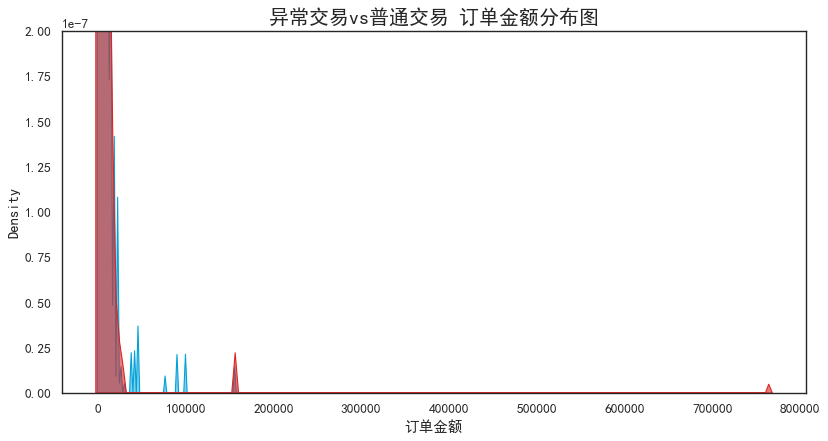

In [203]:
plt.figure(figsize=(12, 6), dpi=80)
sns.kdeplot(normal,
            shade=True,
            color="#01a2d9",
            label="普通交易",
            alpha=.5)
sns.kdeplot(ab,
            shade=True,
            color="#dc2624",
            label="异常交易",
            alpha=.6)

sns.set(style="whitegrid",font="simhei", font_scale=1.1)
plt.title("异常交易vs普通交易 订单金额分布图",fontsize=18)
# plt.yticks([])
plt.ylim((0,0.0000002))
plt.show()

<div class="alert alert-block alert-success">
    
- 异常交易在订单金额上的分布有很长的长尾，而普通交易却在38w左右的某个点上形成了小高峰。
- 不难发现订单金额大于40w的交易全部是异常交易。在38w之前，异常交易与普通交易的金额看不出显著的区别。
- 我们可以**对订单金额进行分箱，并将每个箱内异常交易的比例进行对比**。如果各箱之间差异巨大，则我们可以根据分箱后的结果创造新特征。
</div>

**对订单金额分箱 - 根据连续型特征构建分类型特征**

In [204]:
from sklearn.preprocessing import KBinsDiscretizer as KBD
enc = KBD(n_bins=10,encode="ordinal",strategy = 'kmeans')

In [205]:
enc = enc.fit(pd.DataFrame(train["订单金额"]))

In [206]:
train["金额分箱"] = enc.transform(pd.DataFrame(train["订单金额"]))

In [207]:
# 找出每个箱子的下界
train.groupby(["金额分箱"])["订单金额"].min()

金额分箱
0.0         0.5
1.0       966.0
2.0      2960.0
3.0      6438.0
4.0     12800.0
5.0     29380.0
6.0     71980.0
7.0    155999.0
8.0    383000.0
9.0    766000.0
Name: 订单金额, dtype: float64

In [208]:
# 找出每个箱子的上界
train.groupby(["金额分箱"])["订单金额"].max()

金额分箱
0.0       959.0
1.0      2948.0
2.0      6399.0
3.0     12598.0
4.0     26593.0
5.0     45490.0
6.0     99840.0
7.0    155999.0
8.0    383000.0
9.0    766000.0
Name: 订单金额, dtype: float64

In [209]:
# 将上界和下界统一到同一个dataframe中
df = pd.DataFrame(index=train.groupby(["金额分箱"])["订单金额"].max().index)
df["下界"] = train.groupby(["金额分箱"])["订单金额"].min()
df["上界"] = train.groupby(["金额分箱"])["订单金额"].max()

In [210]:
df

,下界,上界
金额分箱,,
0.0,0.5,959.0
1.0,966.0,2948.0
2.0,2960.0,6399.0
3.0,6438.0,12598.0
4.0,12800.0,26593.0
5.0,29380.0,45490.0
6.0,71980.0,99840.0
7.0,155999.0,155999.0
8.0,383000.0,383000.0


In [211]:
train.groupby(["金额分箱"])["订单金额"].mean()

金额分箱
0.0       136.920876
1.0      1781.498908
2.0      4131.459881
3.0      8688.444145
4.0     16749.875000
5.0     37241.857143
6.0     83976.000000
7.0    155999.000000
8.0    383000.000000
9.0    766000.000000
Name: 订单金额, dtype: float64

<div class="alert alert-block alert-success">
    
- 各箱子之间的上下界不是完全连在一起的，是因为金额本身虽然是连续性变量，但不是连在一起的。
- 在编号7、8、9的箱子中，上界和下界相同，箱子中只有唯一数值
</div>

**聚合特征 - 分享均值、分箱异常率**

In [212]:
train.groupby(["金额分箱"])["异常"].mean()

金额分箱
0.0    0.201748
1.0    0.244630
2.0    0.320885
3.0    0.281292
4.0    0.333333
5.0    0.142857
6.0    0.000000
7.0    0.500000
8.0    0.000000
9.0    1.000000
Name: 异常, dtype: float64

<div class="alert alert-block alert-success">
    
- 我们可以将:
    - **订单金额分箱结果（0-9）**
    - **分箱聚合后各箱的平均金额**
    - **各箱的异常率**
- 放到训练集和测试集中，构建新特征。

</div>

In [213]:
train["金额分箱"] = enc.transform(pd.DataFrame(train["订单金额"]))
test["金额分箱"] = enc.transform(pd.DataFrame(test["订单金额"]))

In [214]:
dic = dict(train.groupby(["金额分箱"])["订单金额"].mean())
train["分箱均值"] = train["金额分箱"].map(dic)
test["分箱均值"] = test["金额分箱"].map(dic)

In [215]:
dic = dict(train.groupby(["金额分箱"])["异常"].mean())
train["分箱异常率"] = train["金额分箱"].map(dic)
test["分箱异常率"] = test["金额分箱"].map(dic)

In [216]:
train.head()

,异常,订单ID,商品一级类别,商品所属渠道,商品ID,品牌,订单金额,商品销售数量,订单渠道,支付方式,...,下单小时,支付方式异常率,省份,省份异常率,商品一级类别异常率,商品所属渠道异常率,订单渠道异常率,金额分箱,分箱均值,分箱异常率
0,1,4283851335,5,1,8002042497,三星,766000.0,200,1,0,...,14,0.272234,0,0.203057,0.258937,0.29293,0.167217,9.0,766000.000000,1.000000
1,1,4281111595,2,1,8002199518,纬度空间,100.0,100,1,0,...,10,0.272234,11,0.221112,0.247814,0.29293,0.167217,0.0,136.920876,0.201748
2,0,4106833871,3,1,8002212182,品道天元,8800.0,100,1,0,...,16,0.272234,11,0.221112,0.233941,0.29293,0.167217,3.0,8688.444145,0.281292
3,0,4245023523,2,1,8002199518,纬度空间,100.0,100,1,0,...,10,0.272234,11,0.221112,0.247814,0.29293,0.167217,0.0,136.920876,0.201748
4,0,4253622967,10,1,8001748897,清华同方,880.0,100,1,0,...,21,0.272234,14,0.210295,0.219469,0.29293,0.167217,0.0,136.920876,0.201748


In [217]:
test.head()

,异常,订单ID,商品一级类别,商品所属渠道,商品ID,品牌,订单金额,商品销售数量,订单渠道,支付方式,...,下单小时,支付方式异常率,省份,省份异常率,商品一级类别异常率,商品所属渠道异常率,订单渠道异常率,金额分箱,分箱均值,分箱异常率
0,1,4276537082,11,1,8001992420,樱花,19900.0,100,1,0,...,14,0.272234,23,0.216120,0.198993,0.29293,0.167217,4.0,16749.875000,0.333333
1,0,3977175284,5,1,8002237611,伊斯贝,990.0,100,1,0,...,23,0.272234,23,0.216120,0.258937,0.29293,0.167217,1.0,1781.498908,0.244630
2,0,4281111696,2,1,8002199518,纬度空间,100.0,100,1,0,...,10,0.272234,11,0.221112,0.247814,0.29293,0.167217,0.0,136.920876,0.201748
3,0,4284735768,3,1,8002202146,奕辰,2028.0,52,1,0,...,17,0.272234,8,0.168142,0.233941,0.29293,0.167217,1.0,1781.498908,0.244630
4,0,3675453285,3,1,8002202147,奕辰,1950.0,50,1,0,...,17,0.272234,18,0.213200,0.233941,0.29293,0.167217,1.0,1781.498908,0.244630


#### 7.2 商品销售数量

In [218]:
# 粗略查看异常交易与正常交易的销量，异常订单和正常订单销售数量基本相同
train.groupby(["异常"])['商品销售数量'].mean()

异常
0    1.190028
1    1.189853
Name: 商品销售数量, dtype: float64

In [219]:
ab = train.loc[train["异常"] ==1,"商品销售数量"]
normal = train.loc[train["异常"] !=1,"商品销售数量"] 

In [220]:
ab.describe()

count    19710.000000
mean         1.189853
std          2.144290
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max        200.000000
Name: 商品销售数量, dtype: float64

In [221]:
normal.describe()

count    72121.000000
mean         1.190028
std          1.632937
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max        100.000000
Name: 商品销售数量, dtype: float64

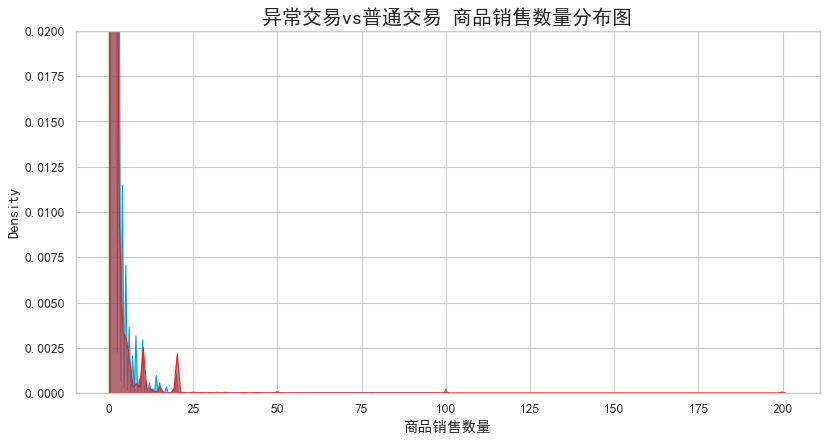

In [222]:
plt.figure(figsize=(12,6), dpi=80)
sns.kdeplot(normal,
            shade=True,
            color="#01a2d9",
            label="普通交易",
            alpha=.5)
sns.kdeplot(ab,
            shade=True,
            color="#dc2624",
            label="异常交易",
            alpha=.6)

sns.set(style="whitegrid",font="simhei", font_scale=1.1)
plt.title("异常交易vs普通交易 商品销售数量分布图",fontsize=18)
#plt.yticks([])
plt.ylim((0,0.02))
plt.show()

<div class="alert alert-block alert-success">
    
- 从分布图来看，一笔交易中下单25个以上商品的多是异常交易，但25个商品以下的交易中，普通交易与异常交易的差异并不明显。
- 从describe的结果来看也是如此，普通交易与异常交易中99%都是一次下单5个商品以下的订单。从这个角度来说，很可能“商品销售数量”这个特征对于模型的预测来说并无帮助。
- 因此，我们**对商品销量特征执行简单二值化操作——销售数量大于25的，是高风险交易，标注为1，反之则是低风险交易，标注为0**。

</div>

In [223]:
train["销量分箱"] = 0
test["销量分箱"] = 0
train.loc[train["商品销售数量"] > 25,"销量分箱"] = 1
test.loc[test["商品销售数量"] > 25,"销量分箱"] = 1

In [224]:
train.head()

,异常,订单ID,商品一级类别,商品所属渠道,商品ID,品牌,订单金额,商品销售数量,订单渠道,支付方式,...,支付方式异常率,省份,省份异常率,商品一级类别异常率,商品所属渠道异常率,订单渠道异常率,金额分箱,分箱均值,分箱异常率,销量分箱
0,1,4283851335,5,1,8002042497,三星,766000.0,200,1,0,...,0.272234,0,0.203057,0.258937,0.29293,0.167217,9.0,766000.000000,1.000000,1
1,1,4281111595,2,1,8002199518,纬度空间,100.0,100,1,0,...,0.272234,11,0.221112,0.247814,0.29293,0.167217,0.0,136.920876,0.201748,1
2,0,4106833871,3,1,8002212182,品道天元,8800.0,100,1,0,...,0.272234,11,0.221112,0.233941,0.29293,0.167217,3.0,8688.444145,0.281292,1
3,0,4245023523,2,1,8002199518,纬度空间,100.0,100,1,0,...,0.272234,11,0.221112,0.247814,0.29293,0.167217,0.0,136.920876,0.201748,1
4,0,4253622967,10,1,8001748897,清华同方,880.0,100,1,0,...,0.272234,14,0.210295,0.219469,0.29293,0.167217,0.0,136.920876,0.201748,1


In [225]:
test.head()

,异常,订单ID,商品一级类别,商品所属渠道,商品ID,品牌,订单金额,商品销售数量,订单渠道,支付方式,...,支付方式异常率,省份,省份异常率,商品一级类别异常率,商品所属渠道异常率,订单渠道异常率,金额分箱,分箱均值,分箱异常率,销量分箱
0,1,4276537082,11,1,8001992420,樱花,19900.0,100,1,0,...,0.272234,23,0.216120,0.198993,0.29293,0.167217,4.0,16749.875000,0.333333,1
1,0,3977175284,5,1,8002237611,伊斯贝,990.0,100,1,0,...,0.272234,23,0.216120,0.258937,0.29293,0.167217,1.0,1781.498908,0.244630,1
2,0,4281111696,2,1,8002199518,纬度空间,100.0,100,1,0,...,0.272234,11,0.221112,0.247814,0.29293,0.167217,0.0,136.920876,0.201748,1
3,0,4284735768,3,1,8002202146,奕辰,2028.0,52,1,0,...,0.272234,8,0.168142,0.233941,0.29293,0.167217,1.0,1781.498908,0.244630,1
4,0,3675453285,3,1,8002202147,奕辰,1950.0,50,1,0,...,0.272234,18,0.213200,0.233941,0.29293,0.167217,1.0,1781.498908,0.244630,1


In [226]:
# 将处理后的数据单独保存
train.to_csv(r'train.csv')
test.to_csv(r'test.csv')

### 8. 复杂离散型特征：用户ID&商品ID&商品品牌

In [227]:
train = pd.read_csv(r'train.csv',index_col=0)
test = pd.read_csv(r'test.csv',index_col=0)

In [228]:
# 各离散型特征的类别数量
for i in ["商品一级类别","城市","下单用户ID","商品ID","品牌"]:
    cate = len(train[i].unique())
    print(i,cate)

商品一级类别 17
城市 362
下单用户ID 58446
商品ID 17349
品牌 2520


<div class="alert alert-block alert-warning">
 
**思考：**     
1. 在我们的数据集中，**用户ID**、**商品ID**及**商品品牌**是非常特殊的三个离散型特征。在一般的数据中，ID这种带有一定唯一性的特征，都可以采取直接删除或无视的处理方法，但在我们现在特殊的预测场景下，订单可能因为涉及到异常用户、异常商品甚至异常品牌因此被判做“异常”，所以我们需要保留用户ID、商品ID、商品品牌这三个特征，还需要对这三个特征进行探索和处理。这三个类别在业务上看似关系不大，但在数据处理上却可以当做一类数据，他们两个共同点：
    - **1）可能出现一个ID/品牌只对应一个样本的情况**：
        - 在一个商品类别/一个收获城市下，最少也有几十上百次交易，因此交易中的异常率可以被认为是大量实验后的可信结果。
        - 但一个商品或一个品牌可能在全年之中只有寥寥几笔交易（甚至一笔），对于用户来说，全年可能只进行一次交易。
        - 这种情况下无论交易是异常还是正常，都无法被用来评估该商品/用户的风险。因此我们需要将样本分为两类：
            - 交易过少无法判断的类型
            - 交易量足够、可以衡量风险的类型
        - 对交易过少的类型我们进行特殊标记，对交易足够的类型使用异常率。
    - **2）对比其他离散型特征如商品类别、城市等，这三个特征中的类别数量尤其地多：**
        - 当我们在分割训练集与测试集时，一般默认离散字段中的所有类别都会同时出现在训练集和测试集中。
        - 例如城市、商品一级类别，train与test中应该都包含了所有的类别，这样我们才能使用相同的字典去对字段进行编码。
        - 但当一个离散字段中的类别数量非常多时，我们就无法保证所有的类别会同时出现在训练集和测试集中了。
        - 如此带来的问题是，测试集中出现了训练集中从未见过的分类或数据，不能再使用同样的字典进行编码，否则会留下空值。
</div>

<div class="alert alert-block alert-success">
    
- 从这两个角度来说，这三个特征的处理是比其他特征更难的。我们先来分析异常率。

</div>

#### 8.1 用户ID

<div class="alert alert-block alert-warning">
 
**思考：**     
1. 从业务上来说，用户订单的异常率分布应该不是正太的，而是低异常率的人非常非常多，高异常率的人占少数，异常率在中间的基本没有。
</div>

<div class="alert alert-block alert-success">
    
- 在这种分布下，高异常率的用户就是异常用户，只要是异常用户的订单，一律都可以归为异常。
- 根据前面的分析，交易过少的用户（**即用户ID只出现过很少次**）无法判断其异常的风险，又由于本身整体数据量很少，交易超过1单的人仅有五千多人，所以可以以1单作为分界点，交易超过1单的人则可以认为是可以衡量异常风险的。因此，
    - **对仅交易1单的用户给予-1的用户异常率**，向算法表明这类人与其他类型的不同。
    - **对交易超过1单的用户计算异常率**
</div>

In [229]:
# 下单用户有多少人？
len(train["下单用户ID"].unique())

58446

In [230]:
# 其中只下了一单的有多少人？—— 这些人理论上是不应该计算其异常率的
(train["下单用户ID"].value_counts()==1).sum()

44152

In [231]:
# 交易超过1单的人数
(train["下单用户ID"].value_counts()>1).sum()

14294

In [232]:
# 提取出下单次数超过1次的用户，计算异常率
MultipleBuyRatio = train.groupby(["下单用户ID"])["异常"].mean()[train.groupby(["下单用户ID"])["异常"].count() != 1].sort_values()

In [233]:
# 查看分布，50%以上的用户从未有过异常订单
MultipleBuyRatio.describe([0.6,0.7,0.8,0.9,0.99])

count    14294.000000
mean         0.259629
std          0.345909
min          0.000000
50%          0.000000
60%          0.250000
70%          0.500000
80%          0.500000
90%          1.000000
99%          1.000000
max          1.000000
Name: 异常, dtype: float64

#### 8.2 商品ID

<div class="alert alert-block alert-warning">
 
**思考：**     
1. 首先观察交易量。但一笔交易中可能售出多个相同商品，因此商品的交易量不能但从交易次数来判断，还需依赖于另一个特征：商品销售数量。
</div>

<div class="alert alert-block alert-success">
    
- 所以对于每个商品的交易数量应是**对应的商品ID下的商品销售数量加和**
</div>

In [234]:
train.groupby(["商品ID"])["商品销售数量"].sum().describe([0.6,0.7,0.8,0.9,0.99])

count    17349.000000
mean         6.298807
std         37.883227
min          1.000000
50%          1.000000
60%          2.000000
70%          3.000000
80%          4.000000
90%         10.000000
99%         84.000000
max       2564.000000
Name: 商品销售数量, dtype: float64

<div class="alert alert-block alert-success">
    
- 商品销售量均值才6.3,90%以下的商品其销售量不超过10。
- 因此可以规定（人为的，根据经验的）：
    - **销售数量小于10的商品，都是交易过少无法判断其异常风险的商品。**
    - **对销售数量大于等于10的商品计算异常率**
</div>

In [235]:
# 选出销售数量大于等于10的商品
ProductIDRatio = train.groupby(["商品ID"])["异常"].mean()[train.groupby(["商品ID"])["商品销售数量"].sum() >=10]

In [236]:
# 大部分商品的异常率都低于30%，符合业务逻辑
ProductIDRatio.describe() 

count    1756.000000
mean        0.226703
std         0.203520
min         0.000000
25%         0.083333
50%         0.181818
75%         0.327519
max         1.000000
Name: 异常, dtype: float64

#### 8.3 品牌

<div class="alert alert-block alert-warning">
 
**思考：**     
1. 与商品ID一样，我们也以来商品销售数量来帮助我们计算品牌交易量。
</div>

<div class="alert alert-block alert-success">
    
- 所以对于每个品牌的交易数量应是**对应的该品牌下的商品销售数量加和**
</div>

In [237]:
train.groupby(["品牌"])["商品销售数量"].sum().describe([0.6,0.7,0.8,0.9,0.99])

count    2520.000000
mean       43.364286
std       197.847947
min         1.000000
50%         4.000000
60%         7.000000
70%        13.000000
80%        26.000000
90%        69.000000
99%       611.390000
max      3959.000000
Name: 商品销售数量, dtype: float64

<div class="alert alert-block alert-success">
    
- 品牌销售量均值有43，说明大部分品牌在一年当中的销售量还是比较大的。
- 因此可以规定（自己定的）：
    - 销售数量少于10的品牌，都是交易过少无法判断其异常风险的商品
    - 对销售数量大于等于10的品牌计算异常率
</div>

In [238]:
# 选出销售数量大于等于10的品牌
BrandIDRatio = train.groupby(["品牌"])["异常"].mean()[train.groupby(["品牌"])["商品销售数量"].sum() >=10]

In [239]:
# 大部分品牌的异常率都低于30%，符合业务逻辑
BrandIDRatio.describe() 

count    884.000000
mean       0.240861
std        0.161425
min        0.000000
25%        0.133333
50%        0.212618
75%        0.333333
max        1.000000
Name: 异常, dtype: float64

#### 8.4 聚合特征 - 用户/商品/品牌的异常率

<div class="alert alert-block alert-warning">
 
**思考：**     
1. 此时就可以**将用户异常率、商品异常率、品牌异常率作为聚合特征**，放入我们的特征矩阵了。具体怎么做？
</div>

<div class="alert alert-block alert-success">
    
- 对训练集来说很简单，交易量不足的部分标注为-1，交易量足够的部分标注为异常率。
- 对测试集来说，我们则需要检查该测试样本的ID是否出现在训练集中，如果出现，则使用训练集中的标注，如果不出现，则标记为-1。
</div>

**用户异常率**

In [240]:
# 首先创造匹配特征类别的字典
df = pd.DataFrame(index=train["下单用户ID"].unique())
df["用户异常率"] = -1
df.loc[MultipleBuyRatio.index,"用户异常率"] = MultipleBuyRatio

In [241]:
# 将字典映射到新特征上
train["用户异常率"] = train["下单用户ID"].map(dict(df["用户异常率"]))
train["用户异常率"].head()

0    0.187500
1    0.333333
2    0.000000
3    0.333333
4   -1.000000
Name: 用户异常率, dtype: float64

In [242]:
# 对测试集，检查是否有训练集中出现过的用户，不出现的标为-1，出现的标为训练集中对应的值
dic = {}
for i in test["下单用户ID"]:
    if i in MultipleBuyRatio.index:
        dic[i] = MultipleBuyRatio[i]
    else:
        dic[i] = -1
test["用户异常率"] = test["下单用户ID"].map(dic)

In [243]:
train.head()

,异常,订单ID,商品一级类别,商品所属渠道,商品ID,品牌,订单金额,商品销售数量,订单渠道,支付方式,...,省份,省份异常率,商品一级类别异常率,商品所属渠道异常率,订单渠道异常率,金额分箱,分箱均值,分箱异常率,销量分箱,用户异常率
0,1,4283851335,5,1,8002042497,三星,766000.0,200,1,0,...,0,0.203057,0.258937,0.29293,0.167217,9.0,766000.000000,1.000000,1,0.187500
1,1,4281111595,2,1,8002199518,纬度空间,100.0,100,1,0,...,11,0.221112,0.247814,0.29293,0.167217,0.0,136.920876,0.201748,1,0.333333
2,0,4106833871,3,1,8002212182,品道天元,8800.0,100,1,0,...,11,0.221112,0.233941,0.29293,0.167217,3.0,8688.444145,0.281292,1,0.000000
3,0,4245023523,2,1,8002199518,纬度空间,100.0,100,1,0,...,11,0.221112,0.247814,0.29293,0.167217,0.0,136.920876,0.201748,1,0.333333
4,0,4253622967,10,1,8001748897,清华同方,880.0,100,1,0,...,14,0.210295,0.219469,0.29293,0.167217,0.0,136.920876,0.201748,1,-1.000000


In [244]:
test.head()

,异常,订单ID,商品一级类别,商品所属渠道,商品ID,品牌,订单金额,商品销售数量,订单渠道,支付方式,...,省份,省份异常率,商品一级类别异常率,商品所属渠道异常率,订单渠道异常率,金额分箱,分箱均值,分箱异常率,销量分箱,用户异常率
0,1,4276537082,11,1,8001992420,樱花,19900.0,100,1,0,...,23,0.216120,0.198993,0.29293,0.167217,4.0,16749.875000,0.333333,1,-1.000000
1,0,3977175284,5,1,8002237611,伊斯贝,990.0,100,1,0,...,23,0.216120,0.258937,0.29293,0.167217,1.0,1781.498908,0.244630,1,-1.000000
2,0,4281111696,2,1,8002199518,纬度空间,100.0,100,1,0,...,11,0.221112,0.247814,0.29293,0.167217,0.0,136.920876,0.201748,1,0.333333
3,0,4284735768,3,1,8002202146,奕辰,2028.0,52,1,0,...,8,0.168142,0.233941,0.29293,0.167217,1.0,1781.498908,0.244630,1,0.000000
4,0,3675453285,3,1,8002202147,奕辰,1950.0,50,1,0,...,18,0.213200,0.233941,0.29293,0.167217,1.0,1781.498908,0.244630,1,-1.000000


In [245]:
# 检查有无空值
train.isnull().sum().sum()

0

In [246]:
# 检查有无空值
test.isnull().sum().sum()

0

In [247]:
# 将以上过程整合成函数
def GroupByFeature2(column,train,test,newcolumn,ratio):
    
    # 创造字典
    df = pd.DataFrame(index=train[column].unique())
    df[newcolumn] = -1
    df.loc[ratio.index,newcolumn] = ratio
    
    # 映射到训练集
    train[newcolumn] = train[column].map(dict(df[newcolumn]))
    
    # 检查测试集中的样本是否出现在训练集中
    dic = {}
    for i in test[column]:
        if i in ratio.index:
            dic[i] = ratio[i]
        else:
            dic[i] = -1
            
    # 映射到测试集
    test[newcolumn] = test[column].map(dic)
    
    return train,test

**商品异常率**

In [248]:
# 调用GroupByFeature2函数
train,test = GroupByFeature2("商品ID",train,test,"商品异常率",ProductIDRatio)

In [249]:
train.head()

,异常,订单ID,商品一级类别,商品所属渠道,商品ID,品牌,订单金额,商品销售数量,订单渠道,支付方式,...,省份异常率,商品一级类别异常率,商品所属渠道异常率,订单渠道异常率,金额分箱,分箱均值,分箱异常率,销量分箱,用户异常率,商品异常率
0,1,4283851335,5,1,8002042497,三星,766000.0,200,1,0,...,0.203057,0.258937,0.29293,0.167217,9.0,766000.000000,1.000000,1,0.187500,1.000000
1,1,4281111595,2,1,8002199518,纬度空间,100.0,100,1,0,...,0.221112,0.247814,0.29293,0.167217,0.0,136.920876,0.201748,1,0.333333,0.333333
2,0,4106833871,3,1,8002212182,品道天元,8800.0,100,1,0,...,0.221112,0.233941,0.29293,0.167217,3.0,8688.444145,0.281292,1,0.000000,0.228346
3,0,4245023523,2,1,8002199518,纬度空间,100.0,100,1,0,...,0.221112,0.247814,0.29293,0.167217,0.0,136.920876,0.201748,1,0.333333,0.333333
4,0,4253622967,10,1,8001748897,清华同方,880.0,100,1,0,...,0.210295,0.219469,0.29293,0.167217,0.0,136.920876,0.201748,1,-1.000000,0.363636


In [250]:
test.head()

,异常,订单ID,商品一级类别,商品所属渠道,商品ID,品牌,订单金额,商品销售数量,订单渠道,支付方式,...,省份异常率,商品一级类别异常率,商品所属渠道异常率,订单渠道异常率,金额分箱,分箱均值,分箱异常率,销量分箱,用户异常率,商品异常率
0,1,4276537082,11,1,8001992420,樱花,19900.0,100,1,0,...,0.216120,0.198993,0.29293,0.167217,4.0,16749.875000,0.333333,1,-1.000000,0.000000
1,0,3977175284,5,1,8002237611,伊斯贝,990.0,100,1,0,...,0.216120,0.258937,0.29293,0.167217,1.0,1781.498908,0.244630,1,-1.000000,0.083333
2,0,4281111696,2,1,8002199518,纬度空间,100.0,100,1,0,...,0.221112,0.247814,0.29293,0.167217,0.0,136.920876,0.201748,1,0.333333,0.333333
3,0,4284735768,3,1,8002202146,奕辰,2028.0,52,1,0,...,0.168142,0.233941,0.29293,0.167217,1.0,1781.498908,0.244630,1,0.000000,0.186170
4,0,3675453285,3,1,8002202147,奕辰,1950.0,50,1,0,...,0.213200,0.233941,0.29293,0.167217,1.0,1781.498908,0.244630,1,-1.000000,0.400000


In [251]:
# 检查有无空值
train.isnull().sum().sum()

0

In [252]:
# 检查有无空值
test.isnull().sum().sum()

0

**品牌异常率**

In [253]:
train,test = GroupByFeature2("品牌",train,test,"品牌异常率",BrandIDRatio)

In [254]:
train.head()

,异常,订单ID,商品一级类别,商品所属渠道,商品ID,品牌,订单金额,商品销售数量,订单渠道,支付方式,...,商品一级类别异常率,商品所属渠道异常率,订单渠道异常率,金额分箱,分箱均值,分箱异常率,销量分箱,用户异常率,商品异常率,品牌异常率
0,1,4283851335,5,1,8002042497,三星,766000.0,200,1,0,...,0.258937,0.29293,0.167217,9.0,766000.000000,1.000000,1,0.187500,1.000000,0.334871
1,1,4281111595,2,1,8002199518,纬度空间,100.0,100,1,0,...,0.247814,0.29293,0.167217,0.0,136.920876,0.201748,1,0.333333,0.333333,0.333333
2,0,4106833871,3,1,8002212182,品道天元,8800.0,100,1,0,...,0.233941,0.29293,0.167217,3.0,8688.444145,0.281292,1,0.000000,0.228346,0.250681
3,0,4245023523,2,1,8002199518,纬度空间,100.0,100,1,0,...,0.247814,0.29293,0.167217,0.0,136.920876,0.201748,1,0.333333,0.333333,0.333333
4,0,4253622967,10,1,8001748897,清华同方,880.0,100,1,0,...,0.219469,0.29293,0.167217,0.0,136.920876,0.201748,1,-1.000000,0.363636,0.271654


In [255]:
test.head()

,异常,订单ID,商品一级类别,商品所属渠道,商品ID,品牌,订单金额,商品销售数量,订单渠道,支付方式,...,商品一级类别异常率,商品所属渠道异常率,订单渠道异常率,金额分箱,分箱均值,分箱异常率,销量分箱,用户异常率,商品异常率,品牌异常率
0,1,4276537082,11,1,8001992420,樱花,19900.0,100,1,0,...,0.198993,0.29293,0.167217,4.0,16749.875000,0.333333,1,-1.000000,0.000000,0.000000
1,0,3977175284,5,1,8002237611,伊斯贝,990.0,100,1,0,...,0.258937,0.29293,0.167217,1.0,1781.498908,0.244630,1,-1.000000,0.083333,0.393939
2,0,4281111696,2,1,8002199518,纬度空间,100.0,100,1,0,...,0.247814,0.29293,0.167217,0.0,136.920876,0.201748,1,0.333333,0.333333,0.333333
3,0,4284735768,3,1,8002202146,奕辰,2028.0,52,1,0,...,0.233941,0.29293,0.167217,1.0,1781.498908,0.244630,1,0.000000,0.186170,0.184000
4,0,3675453285,3,1,8002202147,奕辰,1950.0,50,1,0,...,0.233941,0.29293,0.167217,1.0,1781.498908,0.244630,1,-1.000000,0.400000,0.184000


In [256]:
# 检查有无空值
train.isnull().sum().sum()

0

In [257]:
# 检查有无空值
test.isnull().sum().sum()

0

#### 8.5 特征编码

<div class="alert alert-block alert-warning">
 
**思考：**     
1. 依据与创造新特征时一致的思路，在进行特征编码时，我们也需要对测试集和训练集分开处理。
</div>

<div class="alert alert-block alert-success">
    
- 我们需要判断测试集中出现的类型是否曾出现在训练集中：
    - 如果出现在训练集中，则按训练集中的编号进行编码；
    - 如果没有出现在训练集中，则跟随训练集编码后继续编码
</div>

In [258]:
# 根据以上思路编写函数
def ComplexEncode(column,train,test):
    
    # 找出训练集上的字典
    dic = {}
    feature = train.loc[:,column]
    unique_ = np.sort(feature.unique())
    for code, category in enumerate(unique_):
        dic[category] = code
        
    # 使用字典映射到原始特征
    train[column] = train[column].map(dic)
    
    # 转化测试集
    nullcheck = test[column].map(dic)
    # 找出在测试集中出现但训练集中未出现的类别
    while nullcheck.isnull().sum() > 0:
        print("测试集中出现训练集中未出现的类别")
        newcategory = test.loc[nullcheck.isnull(),column].unique()
        # 接着训练集的编号之后继续编码
        for i in newcategory:
            dic[i] = len(dic)
        nullcheck = test[column].map(dic)
    test[column] = nullcheck
    
    return train,test

In [259]:
# 调用ComplexEncode函数
for column in ["下单用户ID","商品ID","品牌"]:
    train,test = ComplexEncode(column,train,test)

测试集中出现训练集中未出现的类别
测试集中出现训练集中未出现的类别
测试集中出现训练集中未出现的类别


In [260]:
train.head()

,异常,订单ID,商品一级类别,商品所属渠道,商品ID,品牌,订单金额,商品销售数量,订单渠道,支付方式,...,商品一级类别异常率,商品所属渠道异常率,订单渠道异常率,金额分箱,分箱均值,分箱异常率,销量分箱,用户异常率,商品异常率,品牌异常率
0,1,4283851335,5,1,13203,205,766000.0,200,1,0,...,0.258937,0.29293,0.167217,9.0,766000.000000,1.000000,1,0.187500,1.000000,0.334871
1,1,4281111595,2,1,15169,1857,100.0,100,1,0,...,0.247814,0.29293,0.167217,0.0,136.920876,0.201748,1,0.333333,0.333333,0.333333
2,0,4106833871,3,1,15299,679,8800.0,100,1,0,...,0.233941,0.29293,0.167217,3.0,8688.444145,0.281292,1,0.000000,0.228346,0.250681
3,0,4245023523,2,1,15169,1857,100.0,100,1,0,...,0.247814,0.29293,0.167217,0.0,136.920876,0.201748,1,0.333333,0.333333,0.333333
4,0,4253622967,10,1,11549,1575,880.0,100,1,0,...,0.219469,0.29293,0.167217,0.0,136.920876,0.201748,1,-1.000000,0.363636,0.271654


In [261]:
test.head()

,异常,订单ID,商品一级类别,商品所属渠道,商品ID,品牌,订单金额,商品销售数量,订单渠道,支付方式,...,商品一级类别异常率,商品所属渠道异常率,订单渠道异常率,金额分箱,分箱均值,分箱异常率,销量分箱,用户异常率,商品异常率,品牌异常率
0,1,4276537082,11,1,12814,1408,19900.0,100,1,0,...,0.198993,0.29293,0.167217,4.0,16749.875000,0.333333,1,-1.000000,0.000000,0.000000
1,0,3977175284,5,1,15699,338,990.0,100,1,0,...,0.258937,0.29293,0.167217,1.0,1781.498908,0.244630,1,-1.000000,0.083333,0.393939
2,0,4281111696,2,1,15169,1857,100.0,100,1,0,...,0.247814,0.29293,0.167217,0.0,136.920876,0.201748,1,0.333333,0.333333,0.333333
3,0,4284735768,3,1,15209,801,2028.0,52,1,0,...,0.233941,0.29293,0.167217,1.0,1781.498908,0.244630,1,0.000000,0.186170,0.184000
4,0,3675453285,3,1,15210,801,1950.0,50,1,0,...,0.233941,0.29293,0.167217,1.0,1781.498908,0.244630,1,-1.000000,0.400000,0.184000


In [262]:
# 检查有无空值
train.isnull().sum().sum()

0

In [263]:
# 检查有无空值
test.isnull().sum().sum()

0

In [264]:
# 将处理后的数据单独保存
train.to_csv(r'train.csv')
test.to_csv(r'test.csv')

## 三、模型构筑：使用融合模型进行预测

### 1.导入数据，按特征工程后数据进行基础建模

In [265]:
import sklearn
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.ensemble import RandomForestClassifier as RFC
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [266]:
train = pd.read_csv(r'train.csv',index_col=0)
test = pd.read_csv(r'test.csv',index_col=0)

In [267]:
train.head()

,异常,订单ID,商品一级类别,商品所属渠道,商品ID,品牌,订单金额,商品销售数量,订单渠道,支付方式,...,商品一级类别异常率,商品所属渠道异常率,订单渠道异常率,金额分箱,分箱均值,分箱异常率,销量分箱,用户异常率,商品异常率,品牌异常率
0,1,4283851335,5,1,13203,205,766000.0,200,1,0,...,0.258937,0.29293,0.167217,9.0,766000.000000,1.000000,1,0.187500,1.000000,0.334871
1,1,4281111595,2,1,15169,1857,100.0,100,1,0,...,0.247814,0.29293,0.167217,0.0,136.920876,0.201748,1,0.333333,0.333333,0.333333
2,0,4106833871,3,1,15299,679,8800.0,100,1,0,...,0.233941,0.29293,0.167217,3.0,8688.444145,0.281292,1,0.000000,0.228346,0.250681
3,0,4245023523,2,1,15169,1857,100.0,100,1,0,...,0.247814,0.29293,0.167217,0.0,136.920876,0.201748,1,0.333333,0.333333,0.333333
4,0,4253622967,10,1,11549,1575,880.0,100,1,0,...,0.219469,0.29293,0.167217,0.0,136.920876,0.201748,1,-1.000000,0.363636,0.271654


In [268]:
test.head()

,异常,订单ID,商品一级类别,商品所属渠道,商品ID,品牌,订单金额,商品销售数量,订单渠道,支付方式,...,商品一级类别异常率,商品所属渠道异常率,订单渠道异常率,金额分箱,分箱均值,分箱异常率,销量分箱,用户异常率,商品异常率,品牌异常率
0,1,4276537082,11,1,12814,1408,19900.0,100,1,0,...,0.198993,0.29293,0.167217,4.0,16749.875000,0.333333,1,-1.000000,0.000000,0.000000
1,0,3977175284,5,1,15699,338,990.0,100,1,0,...,0.258937,0.29293,0.167217,1.0,1781.498908,0.244630,1,-1.000000,0.083333,0.393939
2,0,4281111696,2,1,15169,1857,100.0,100,1,0,...,0.247814,0.29293,0.167217,0.0,136.920876,0.201748,1,0.333333,0.333333,0.333333
3,0,4284735768,3,1,15209,801,2028.0,52,1,0,...,0.233941,0.29293,0.167217,1.0,1781.498908,0.244630,1,0.000000,0.186170,0.184000
4,0,3675453285,3,1,15210,801,1950.0,50,1,0,...,0.233941,0.29293,0.167217,1.0,1781.498908,0.244630,1,-1.000000,0.400000,0.184000


In [269]:
# 划分特征和标签
Xtrain = train.iloc[:,1:]
Xtest = test.iloc[:,1:]
Ytrain = train.iloc[:,0]
Ytest = test.iloc[:,0]

In [270]:
# 生成xgb所需特定的数据集
dtrain = xgb.DMatrix(Xtrain,Ytrain)
dtest = xgb.DMatrix(Xtest,Ytest)

#### 1.1 gbdt、rf、xgb下的准确率(acc)

In [271]:
# 使用随机森林与GBDC分别进行预测观察结果
rf = RFC(n_estimators=200,random_state=0)
gbdt = GBC(n_estimators=200,random_state=0)

In [272]:
# 依然使用和建立benchmark时一模一样的最简单的KFold交叉验证，随机数种子也保持一致
cv = KFold(n_splits=5,shuffle=True,random_state=0)

In [273]:
%%time
# gbdc -acc
result_gbdt_cv = cross_val_score(gbdt,Xtrain,Ytrain,cv=cv)
print(result_gbdt_cv.mean())
print(result_gbdt_cv.var())

0.8802473947028971
6.2077572312023965e-06
Wall time: 2min 18s


In [274]:
%%time
# rf -acc
result_rf_cv = cross_val_score(rf,Xtrain,Ytrain,cv=cv)
print(result_rf_cv.mean())
print(result_rf_cv.var())

0.8748243991205695
2.1160080918081245e-06
Wall time: 1min 29s


In [275]:
%%time
# 使用xgb观察结果
param = {"objective":'binary:logistic'
         ,"eval_metric": "error" # xgb不支持准确率，只有错误率error
         ,"seed":0}

xgbcv = xgb.cv(param, dtrain
                  , num_boost_round=200 # xgboost中的树
                  , nfold=5, seed=0, shuffle=True) 
# xgb使用的随机性系统与sklearn中的不同，
# 在相同随机数种子seed下，交叉验证所划分的数据集不同

1 - xgbcv.loc[199,"test-error-mean"]

Wall time: 22.1 s


0.8757935996847606

<div class="alert alert-block alert-success">
    
- 可以看到，比起benchmark的平均准确率81%，方差3.9*10^6，现在模型的平均准确率达到87%，方差2.1×10^6,无论是准确率均值还是方差都得到了较大提升。
</div>

#### 1.2 gbdt、rf、xgb下的auc

In [276]:
# 注意，每次训练完毕之后需要重新设置类，否则会在原来的基础上继续训练
rf = RFC(n_estimators=200,random_state=0)
gbdt = GBC(n_estimators=200,random_state=0)
cv = KFold(n_splits=5,shuffle=True,random_state=0)

In [277]:
%%time
# gbdc -auc
result_gbdt_cv = cross_val_score(gbdt,Xtrain,Ytrain,cv=cv,scoring="roc_auc")
print(result_gbdt_cv.mean())
print(result_gbdt_cv.var())

0.9346153616536934
1.1027015396240691e-06
Wall time: 2min 20s


In [278]:
%%time
# rf -auc
result_rf_cv = cross_val_score(rf,Xtrain,Ytrain,cv=cv,scoring="roc_auc")
print(result_rf_cv.mean())
print(result_rf_cv.var())

0.9266009581365736
1.0737276278847375e-06
Wall time: 1min 27s


In [279]:
%%time
# xgb -auc
param2 = {"objective":'binary:logistic'
         ,"eval_metric": "auc"
         ,"seed":0}

xgbcv = xgb.cv(param2, dtrain
                  , num_boost_round=200 #xgboost中的树
                  , nfold=5, seed=0, shuffle=True)

print(xgbcv.loc[199,"test-auc-mean"])
print(xgbcv.loc[199,"test-auc-std"]**2)

0.932439798256155
6.16438095741068e-07
Wall time: 27.9 s


<div class="alert alert-block alert-success">
    
- 同样，benchmark的平均AUC为0.83，方差7.5×10^6，而现在三个模型的AUC分数也得到了大幅提升，方差也变小了8~10倍，可见特征工程是成功的。
- 基于目前的水平，我们可以在此基础上继续调参，来观察模型的结果。
</div>

|算法|benchmark（默认参数）|特征工程后（默认参数）|
|----|--------|-------|
|rf|0.82822|0.92660(<font color=green>**+**</font>)|
|gbdt|-|0.93462(<font color=green>**+**</font>)|
|xgb|-|0.93244(<font color=green>**+**</font>)|

### 2.基于AUC，使用学习曲线进行调参

<div class="alert alert-block alert-warning">
 
**思考：**     
1. 当我们使用集成模型进行建模时，我们必须知道调参的空间是比较有限的。
2. 集成模型的默认参数都是基于经验精心设计的，当我们使用默认参数时，模型就已经达到了某种上限，因此调参在集成模型上基本是对结果进行“微调”，集成模型调参之后的表现不会与默认参数的表现差距太大。
</div>

<div class="alert alert-block alert-success">
    
- 因此，为了大幅度提升模型的效果，我们需要先考虑一些激进的方案。
</div>

#### 2.1 处理样本不均衡

<div class="alert alert-block alert-warning">
 
**思考：**     
1. 对于一个不均衡的样本来说，处理样本不均衡问题往往能够大幅度提升模型auc和准确率。
    - 但现在的状况是，随机森林、GBDT和XGBoost的结果看起来高度相似，这暗示样本不均衡的处理可能对模型效果不佳。理由是因为，XGBoost的默认参数中默认会将正负样本比例修正为1:1，而随机森林和GBDT则不会做出这样的修正，在这种情况下，**三个模型在AUC上的表现看起来高度相似，就说明样本不均衡对于现在的数据集来说可能不是问题**。

2. 然而还是可以尝试一下处理样本不均衡的。为了业务上能够有所解释，我们尽量避免使用smote方法（过采样）。
3. 但遗憾的是，GBDT没有修复样本不均衡的参数，因此GBDT无法在这个点上进行调整，我们先来看看**随机森林**和**XGBoost**的效果。
</div>

In [280]:
# 样本不均衡的现状：不算严重
(Ytrain==1).sum()/Ytrain.shape[0]

0.21463340266358855

**RamdomForest：class_weight**

<div class="alert alert-block alert-success">
   
- 对随机森林来说，我们可以试着调用参数**class_weight**。
    - 在class_weight中输入{类别1:占比，类别2:占比}就可以设定训练中**两个标签类别之间的比例（相加可以不为1）**，或者使用"balanced"模式。默认参数中，class_weight是None，也就是完全不理会样本不均衡情况。
    - 在"balanced"模式下:
        - 0的比例为全部样本量/(类别量\*标签中为0的样本量)
        - 1的比例为全部样本量/(类别量\*标签中为1的样本量)。
</div>

In [281]:
# balanced模式下 - 0类比1类是0.63：2.3（约等于1：3）
Xtrain.shape[0]/(2*np.bincount(Ytrain))

array([0.63664536, 2.32955353])

In [282]:
%%time
# 使用学习曲线对class_weight在1：1到1：5间循环
for weights in [{0:0.5,1:0.5},{0:0.5,1:1},"balanced",{0:0.5,1:2},{0:0.5,1:2.5}]:
    cv = KFold(n_splits=5,shuffle=True,random_state=0)
    rf = RFC(n_estimators=200,random_state=0,class_weight=weights)
    rfcv = cross_val_score(rf,Xtrain,Ytrain,cv=cv,scoring="roc_auc")
    
    print(weights)
    print("\t rf_mean:{:.5f}".format(rfcv.mean()))
    print("\t rf_var:{}".format(rfcv.var()))

{0: 0.5, 1: 0.5}
	 rf_mean:0.92660
	 rf_var:1.0737276278847375e-06
{0: 0.5, 1: 1}
	 rf_mean:0.92759
	 rf_var:8.471083428610295e-07
balanced
	 rf_mean:0.92804
	 rf_var:8.253770655300982e-07
{0: 0.5, 1: 2}
	 rf_mean:0.92785
	 rf_var:4.849771495755266e-07
{0: 0.5, 1: 2.5}
	 rf_mean:0.92791
	 rf_var:1.0860393214215385e-06
Wall time: 7min 10s


<div class="alert alert-block alert-success">
   
- 可以看到，class_weight的调整只是对随机森林的结果造成了微弱的影响。
    - 随着少数类比例的增加，AUC分数先有一个上升，后有所下降，这说明使auc最高的balanced的比例（0.63：2.3）大约就是最好的比例。
- 我们暂定**对随机森林的class_weight使用balanced模式下的比例0.63：2.3（约1：3）**，也可以针对这个比例进行更细致的调参。
</div>

**XGBoost: scale_pos_wieght**

<div class="alert alert-block alert-success">
   
- 对XGBoost来说，我们可以使用参数**scale_pos_weight**：
    - 在这个参数中我们需要输入**多数类比少数类的比例**（sum(negative instances) / sum(positive instances)）。默认的参数值是1，因此XGBoost默认就对不均衡样本做出了处理。
- 我们可以先尝试scale_pos_weight等于0.5,0.3,0.1三种选项。
</div>

In [283]:
%%time
for weights in [0.5,0.3,0.1]:
    num_round=200
    param = {"objective":'binary:logistic',"eval_metric": "auc","scale_pos_weight": weights}
    xgbcv = xgb.cv(param, dtrain, num_boost_round=num_round, nfold=5, seed=0, shuffle=True)
    
    print(weights)
    print("\t xgb_mean:{:.5f}".format(xgbcv.loc[num_round-1,"test-auc-mean"]))
    print("\t xgb_std:{}".format((xgbcv.loc[num_round-1,"test-auc-std"])**2))

0.5
	 xgb_mean:0.93268
	 xgb_std:2.239395784886742e-07
0.3
	 xgb_mean:0.93316
	 xgb_std:1.565397372779626e-07
0.1
	 xgb_mean:0.93410
	 xgb_std:5.517119126776098e-07
Wall time: 1min 24s


<div class="alert alert-block alert-success">
   
- 从结果来看，调整scale_pos_weight参数是有效的：
    - 随着正样本比例越来越大、负样本比例越来越小，模型的auc是上升的
- 我们可以尝试更激进的方案：使scale_pos_weight等于0.01，0.03，0.05。
</div>

In [284]:
%%time
for weights in [0.01,0.03,0.05]:
    num_round=200
    param = {"objective":'binary:logistic',"eval_metric": "auc","scale_pos_weight": weights}
    xgbcv = xgb.cv(param, dtrain, num_boost_round=num_round, nfold=5, seed=0, shuffle=True)
    
    print(weights)
    print("\t xgb_mean:{:.5f}".format(xgbcv.loc[num_round-1,"test-auc-mean"]))
    print("\t xgb_std:{}".format((xgbcv.loc[num_round-1,"test-auc-std"])**2))

0.01
	 xgb_mean:0.93475
	 xgb_std:2.426889938875226e-07
0.03
	 xgb_mean:0.93474
	 xgb_std:7.790686259590122e-07
0.05
	 xgb_mean:0.93450
	 xgb_std:3.6766917750928395e-07
Wall time: 1min 21s


<div class="alert alert-block alert-success">
   
- 再进一步细化，调整scale_pos_weight等于在0.01和0.03之间。
</div>

In [285]:
%%time
for weights in [0.005,0.015,0.02,0.025]:
    num_round=200
    param = {"objective":'binary:logistic',"eval_metric": "auc","scale_pos_weight": weights}
    xgbcv = xgb.cv(param, dtrain, num_boost_round=num_round, nfold=5, seed=0, shuffle=True)
    
    print(weights)
    print("\t xgb_mean:{:.5f}".format(xgbcv.loc[num_round-1,"test-auc-mean"]))
    print("\t xgb_std:{}".format((xgbcv.loc[num_round-1,"test-auc-std"])**2))

0.005
	 xgb_mean:0.93418
	 xgb_std:1.800852598100672e-07
0.015
	 xgb_mean:0.93515
	 xgb_std:2.6697721879720766e-07
0.02
	 xgb_mean:0.93476
	 xgb_std:5.762733906957383e-07
0.025
	 xgb_mean:0.93481
	 xgb_std:7.20242952812729e-07
Wall time: 1min 46s


<div class="alert alert-block alert-success">
   
- 可以看到，均值最高的大约是0.015，也就是负样本：正样本比例为1.5:100时，xgboost的auc是最高的。
- 因此**暂定scale_pos_weight的比例为0.015**。
- 现在模型参数如下：
    - **随机森林**：
        - rf = RFC(n_estimators=200,random_state=0,class_weight="balanced")
    - **GBDT**:
        - gbdt = GBC(n_estimators=200,random_state=0)
    - **XGBoost**:
        - param = {"objective":'binary:logistic',"eval_metric": "auc","scale_pos_weight": 0.015}
        - xgbcv = xgb.cv(param, dtrain, num_boost_round=200, nfold=5, seed=0, shuffle=True)
</div>

|算法|benchmark（默认参数）|特征工程后（默认参数）|样本均衡后(调参1)|
|----|--------|-------|----------------|
|rf|0.82822|0.92660(<font color=green>**+**</font>)|0.92804(<font color=green>**+**</font>)|
|gbdt|-|0.93462(<font color=green>**+**</font>)|-|
|xgb|-|0.93244(<font color=green>**+**</font>)|0.93515(<font color=green>**+**</font>)|

#### 2.2 调整树的数量

<div class="alert alert-block alert-warning">
 
**思考：**     
1. 如果class_weight不能够帮助我们大幅度提升模型的效果，那我们接下来能够依赖的就是**树的数量**与**学习率**了
    - 树的数量往往可以提升模型的上限；
    - 而学习率是为数不多的、可能实现模型效果大幅度提升的参数之一。
</div>

<div class="alert alert-block alert-success">
   
- 为此，我们可以先在三个算法上尝试不同的**树的数量**，来观察模型的变化。
    - 如果树的数量越多，模型效果越好，则说明模型还有提升的空间；
    - 如果树的数量变多，模型效果却没有明显提升，则说明模型已经达到了上限，我们或许可以以更少的数来达到和现在一样的效果
</div>

In [286]:
%%time
for num_round in [25,50,100,200]:
    cv = KFold(n_splits=5,shuffle=True,random_state=0)
    
    rf = RFC(n_estimators=num_round,random_state=0,class_weight="balanced")
    gbdc = GBC(n_estimators=num_round,random_state=0)
    param = {"objective":'binary:logistic',"eval_metric": "auc","scale_pos_weight": 0.015}
    
    rfcv = cross_val_score(rf,Xtrain,Ytrain,cv=cv,scoring="roc_auc")
    gbdcv = cross_val_score(gbdc,Xtrain,Ytrain,cv=cv,scoring="roc_auc")
    xgbcv = xgb.cv(param, dtrain, num_boost_round=num_round, nfold=5, seed=0, shuffle=True)
    
    print(num_round)
    print("\t rf:{:.5f}".format(rfcv.mean()))
    print("\t gbd:{:.5f}".format(gbdcv.mean()))
    print("\t xgb:{:.5f}".format(xgbcv.loc[num_round-1,"test-auc-mean"]))

25
	 rf:0.91876
	 gbd:0.92209
	 xgb:0.93299
50
	 rf:0.92451
	 gbd:0.92919
	 xgb:0.93560
100
	 rf:0.92681
	 gbd:0.93294
	 xgb:0.93620
200
	 rf:0.92804
	 gbd:0.93462
	 xgb:0.93515
Wall time: 7min 56s


<div class="alert alert-block alert-success">
   
- 对xgboost来说，大约100棵树的状态是最理想的。
    - 可以**对xgboost进行50-150之间的精密调参**
- 而对随机森林和GBDT来说，随着树的数量增长，交叉验证中的auc分数还在增长。
    - 可以**对随机森林和gbdt再增加树的数量**

</div>

**XGBoost: num_boost_round**

In [287]:
%%time
for num_round in range(50,150,10):
    param = {"objective":'binary:logistic',"eval_metric": "auc","scale_pos_weight": 0.015}
    xgbcv = xgb.cv(param, dtrain, num_boost_round=num_round, nfold=5, seed=0, shuffle=True)
    test_auc = xgbcv.loc[num_round-1,"test-auc-mean"]
    print(num_round,"xgb:{:.5f}".format(test_auc))

50 xgb:0.93560
60 xgb:0.93584
70 xgb:0.93594
80 xgb:0.93605
90 xgb:0.93618
100 xgb:0.93620
110 xgb:0.93606
120 xgb:0.93595
130 xgb:0.93587
140 xgb:0.93582
Wall time: 2min 12s


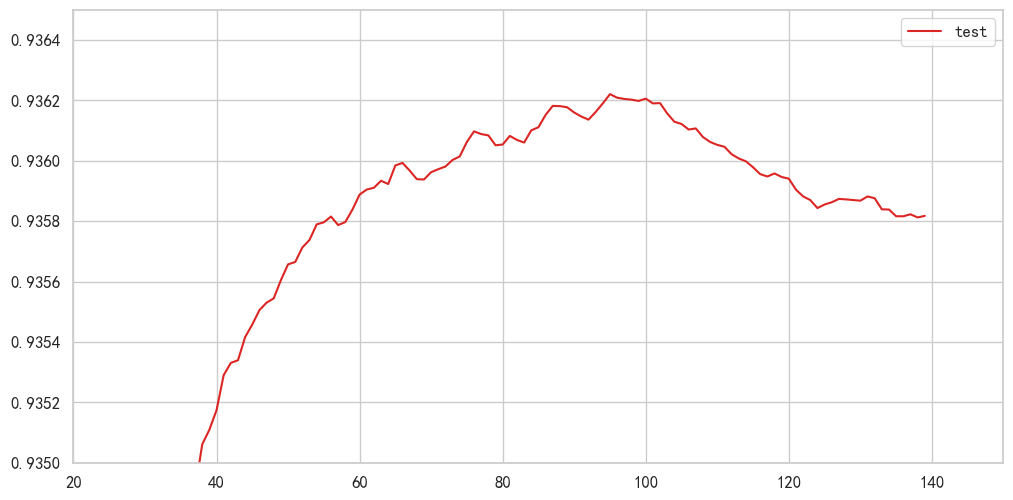

In [288]:
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(xgbcv.index,xgbcv["test-auc-mean"],c="#dc2624",label="test")
sns.set(style="whitegrid",font="simhei", font_scale=1.1)
plt.legend()
plt.ylim((0.935,0.9365))
plt.xlim((20,150))
plt.show()

In [289]:
%%time
for num_round in range(90,110,2):
    param = {"objective":'binary:logistic',"eval_metric": "auc","scale_pos_weight": 0.015}
    xgbcv = xgb.cv(param, dtrain, num_boost_round=num_round, nfold=5, seed=0, shuffle=True)
    test_auc = xgbcv.loc[num_round-1,"test-auc-mean"]
    print(num_round,"xgb:{:.5f}".format(test_auc))

90 xgb:0.93618
92 xgb:0.93615
94 xgb:0.93616
96 xgb:0.93622
98 xgb:0.93620
100 xgb:0.93620
102 xgb:0.93619
104 xgb:0.93616
106 xgb:0.93612
108 xgb:0.93611
Wall time: 2min 18s


<div class="alert alert-block alert-success">
   
- 由结果，XGBoost最高的AUC出现在96棵树时，AUC达到了0.93622。因此我们设定参数**num_boost_round=96**。
</div>

**RandomForest/GBDT: n_estimators**

In [290]:
%%time
for num_round in [400,700,1000]:
    cv = KFold(n_splits=5,shuffle=True,random_state=0)
    
    rf = RFC(n_estimators=num_round,random_state=0,class_weight="balanced")
    gbdc = GBC(n_estimators=num_round,random_state=0)
    
    rfcv = cross_val_score(rf,Xtrain,Ytrain,cv=cv,scoring="roc_auc")
    gbdcv = cross_val_score(gbdc,Xtrain,Ytrain,cv=cv,scoring="roc_auc")
    
    print(num_round)
    print("\t rf:{:.5f}".format(rfcv.mean()))
    print("\t gbd:{:.5f}".format(gbdcv.mean()))

400
	 rf:0.92851
	 gbd:0.93586
700
	 rf:0.92868
	 gbd:0.93592
1000
	 rf:0.92870
	 gbd:0.93560
Wall time: 39min 6s


<div class="alert alert-block alert-success">
   
- 随机森林与GBDT的结果随着树的数量上升、持续增长中，经测试，如果有足够的算力支持更多的树，那两个算法的AUC还可以上升。但在PC上运行时，1000棵树已经非常非常多了，再增加树的数量会增加太多运算时间和运算成本，因此我们可以考虑换一种思路来让模型更快地提升分数。
    - **对于GBDT来说，我们可以调整学习率**，让树迭代得更快，以此来尝试减少树的数量
    - **对于随机森林来说，我们可以从对抗过拟合的角度来考虑**，降低每棵树的复杂度，虽然树的数量很多，但是尽量加快建树的速度
- 基于这样的结论，**GBDT的树数量暂定为200，随机森林的树数量暂定为1000。**
</div>

|算法|benchmark（默认参数）|特征工程后（默认参数）|样本均衡后(调参1)|树的数量（调参2）|
|----|--------|-------|----------------|----------------|
|rf|0.82822|0.92660(<font color=green>**+**</font>)|0.92804(<font color=green>**+**</font>)|0.92870(<font color=green>**+**</font>)|
|gbdt|-|0.93462(<font color=green>**+**</font>)|-|-|
|xgb|-|0.93244(<font color=green>**+**</font>)|0.93515(<font color=green>**+**</font>)|0.93622(<font color=green>**+**</font>)|

#### 2.3 调整学习率

<div class="alert alert-block alert-warning">
 
**思考：**     
1. 当处理样本均衡问题与调整树数量的参数都不管用时，**学习率**是最后一个有可能大幅度提升模型表现的参数。
</div>

<div class="alert alert-block alert-success">
  
- **随机森林没有学习率**调整的参数，因此只能另想办法；
- XGBoost与GBDT的学习率都是可以调整的：
    - GBDT的参数是learning_rate（默认0.1），
    - XGBoost的参数是eta（默认0.3）
- **对XGBoost与GBDT**这两个算法，我们可以尝试**将默认学习率为中心向两边拓展**。
</div>

**XGBoost: eta**

In [291]:
%%time
for lr in [0.1,0.2,0.3,0.4,0.5]:
    cv = KFold(n_splits=5,shuffle=True,random_state=0)
    param = {"objective":'binary:logistic',"eval_metric": "auc"
             ,"scale_pos_weight": 0.015
             ,"eta":lr}
    xgbcv = xgb.cv(param, dtrain, num_boost_round=96, nfold=5, seed=0, shuffle=True)
    test_auc = xgbcv.loc[95,"test-auc-mean"]
    
    print(lr)
    print("\t xgb:{:.5f}".format(test_auc))

0.1
	 xgb:0.93462
0.2
	 xgb:0.93593
0.3
	 xgb:0.93622
0.4
	 xgb:0.93491
0.5
	 xgb:0.93389
Wall time: 1min 2s


<div class="alert alert-block alert-success">
  
- XGBoost在eta=0.3（默认值）时的效果最好，可以在0.3周围小范围精细调整。
</div>

In [292]:
%%time
xgb_result = []
for lr in np.linspace(0.25,0.34,10):
    cv = KFold(n_splits=5,shuffle=True,random_state=0)
    param = {"objective":'binary:logistic',"eval_metric": "auc"
             ,"scale_pos_weight": 0.015
             ,"eta":lr}
    xgbcv = xgb.cv(param, dtrain, num_boost_round=96, nfold=5, seed=0, shuffle=True)
    test_auc = xgbcv.loc[95,"test-auc-mean"]
    xgb_result.append(test_auc)
    print(lr)
    print("\t xgb:{:.5f}".format(test_auc))

0.25
	 xgb:0.93609
0.26
	 xgb:0.93597
0.27
	 xgb:0.93614
0.28
	 xgb:0.93598
0.29000000000000004
	 xgb:0.93582
0.3
	 xgb:0.93622
0.31
	 xgb:0.93595
0.32
	 xgb:0.93579
0.33
	 xgb:0.93551
0.34
	 xgb:0.93551
Wall time: 2min 6s


XGB最高分是0.93622，最高分对应的学习率是0.3


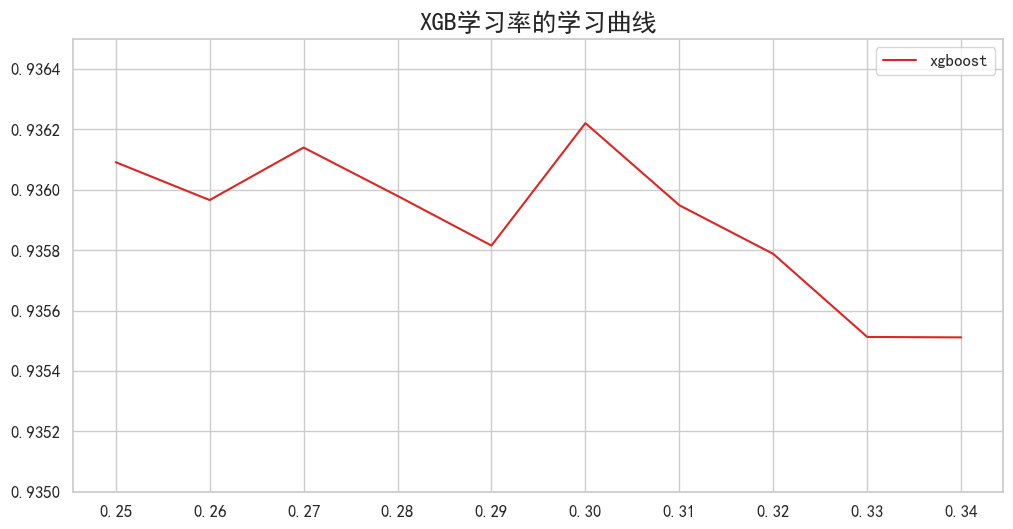

In [293]:
lr_range = np.linspace(0.25,0.34,10)
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(lr_range,xgb_result,c="#dc2624",label="xgboost")
print("XGB最高分是{:.5f}，最高分对应的学习率是{}".format(max(xgb_result),lr_range[xgb_result.index(max(xgb_result))]))
sns.set(style="whitegrid",font="simhei", font_scale=1.1)
plt.title("XGB学习率的学习曲线",fontsize=18)
plt.legend()
plt.xticks(lr_range)
plt.ylim((0.935,0.9365))
plt.show()

<div class="alert alert-block alert-success">
  
- 由结果，**XGBoost还是在eta=0.3（默认值）时的效果最好**，AUC为0.93622。
    - 注：此时的学习率可能不是最好的学习率，而是在树的数量为96时最好的学习率。
</div>

**GBDT: learning_rate**

In [294]:
%%time
for lr in [0.05,0.1,0.2,0.3]:
    cv = KFold(n_splits=5,shuffle=True,random_state=0)
    gbdc = GBC(n_estimators=200
               ,learning_rate=lr
               ,random_state=0)
    gbdcv = cross_val_score(gbdc,Xtrain,Ytrain,cv=cv,scoring="roc_auc")
    print(lr)
    print("\t gbd:{:.5f}".format(gbdcv.mean()))

0.05
	 gbd:0.93290
0.1
	 gbd:0.93462
0.2
	 gbd:0.93576
0.3
	 gbd:0.93538
Wall time: 9min 10s


<div class="alert alert-block alert-success">
  
- GBDT学习率从0.1增加到0.2，能够一定程度上提升模型的效果，可以继续精细调整。
</div>

In [295]:
%%time
gbdc_result = []
for lr in np.linspace(0.15,0.24,10):
    cv = KFold(n_splits=5,shuffle=True,random_state=0)
    gbdc = GBC(n_estimators=200
               ,learning_rate=lr
               ,random_state=0)
    gbdcv = cross_val_score(gbdc,Xtrain,Ytrain,cv=cv,scoring="roc_auc")
    gbdc_result.append(gbdcv.mean())
    print(lr)
    print("\t gbd:{:.5f}".format(gbdcv.mean()))

0.15
	 gbd:0.93535
0.16
	 gbd:0.93533
0.16999999999999998
	 gbd:0.93556
0.18
	 gbd:0.93561
0.19
	 gbd:0.93550
0.2
	 gbd:0.93576
0.21
	 gbd:0.93559
0.22
	 gbd:0.93549
0.22999999999999998
	 gbd:0.93584
0.24
	 gbd:0.93549
Wall time: 23min 4s


GBDT最高分是0.93584，最高分对应的学习率是0.22999999999999998


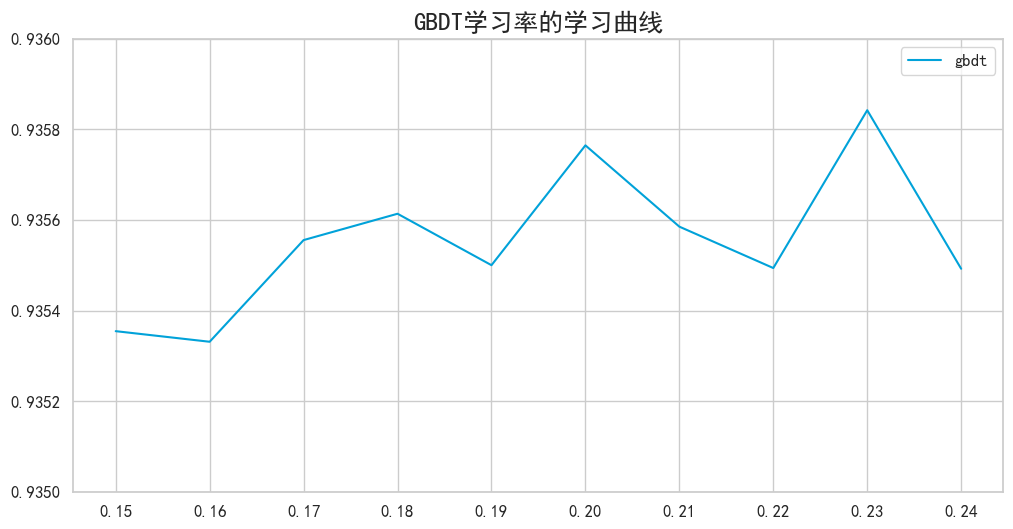

In [296]:
lr_range = np.linspace(0.15,0.24,10)
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(lr_range,gbdc_result,c="#01a2d9",label="gbdt")
print("GBDT最高分是{:.5f}，最高分对应的学习率是{}".format(max(gbdc_result),lr_range[gbdc_result.index(max(gbdc_result))]))
sns.set(style="whitegrid",font="simhei", font_scale=1.1)
plt.title("GBDT学习率的学习曲线",fontsize=18)
plt.legend()
plt.xticks(lr_range)
plt.ylim((0.935,0.936))
plt.show()

<div class="alert alert-block alert-success">
  
- 由结果，**GBDT在learning_rate=0.23时的效果最好**，AUC为0.93584。
- 基于学习率的结果，再次尝试GBDT的树的数量，看看能否保证较高的AUC。
</div>

In [297]:
%%time
gbdc_result = []
for num_round in [50,100,150,200,250]:
    cv = KFold(n_splits=5,shuffle=True,random_state=0)
    gbdc = GBC(n_estimators=num_round,learning_rate=0.23,random_state=0)
    gbdcv = cross_val_score(gbdc,Xtrain,Ytrain,cv=cv,scoring="roc_auc")
    gbdc_result.append(gbdcv.mean())

Wall time: 8min 52s


GBDT最高分是0.93585，最高分对应的树数量是200


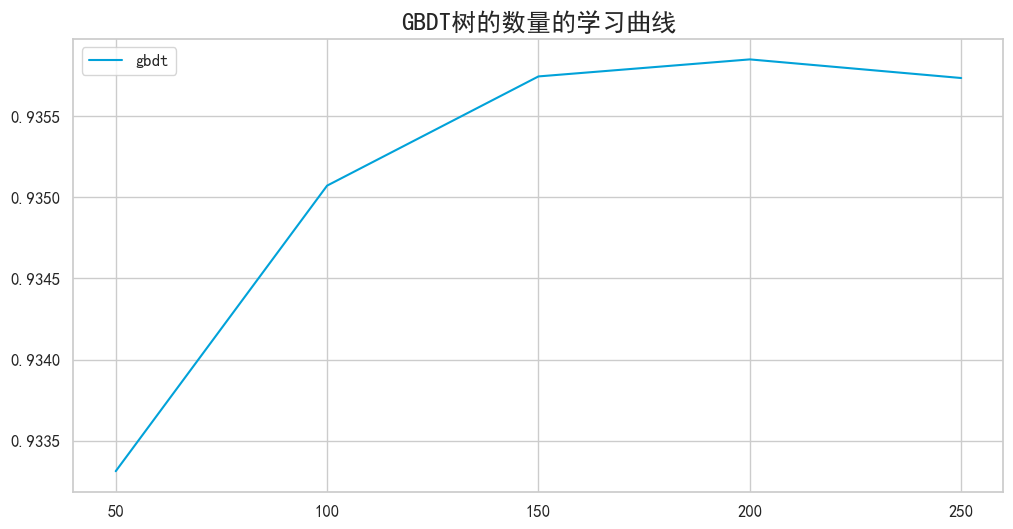

In [298]:
num_round = [50,100,150,200,250]
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(num_round,gbdc_result,c="#01a2d9",label="gbdt")
print("GBDT最高分是{:.5f}，最高分对应的树数量是{}".format(max(gbdc_result),num_round[gbdc_result.index(max(gbdc_result))]))

sns.set(style="whitegrid",font="simhei", font_scale=1.1)
plt.title("GBDT树的数量的学习曲线",fontsize=18)
plt.legend()
plt.xticks(num_round)
plt.show()

<div class="alert alert-block alert-success">
  
- 由结果，一旦减少树的数量，GBDT的结果就会下降，且增加树的数量又会增加计算量。
- 因此还是**设定GBDT的树的数量为200**，不再变化。
</div>

|算法|benchmark（默认参数）|特征工程后（默认参数）|样本均衡后(调参1)|树的数量（调参2）|学习率（调参3）
|----|--------|-------|------------|--------------|--------------|
|rf|0.82822|0.92660(<font color=green>**+**</font>)|0.92804(<font color=green>**+**</font>)|0.92870(<font color=green>**+**</font>)|-|
|gbdt|-|0.93462(<font color=green>**+**</font>)|-|-|0.93584(<font color=green>**+**</font>)|
|xgb|-|0.93244(<font color=green>**+**</font>)|0.93515(<font color=green>**+**</font>)|0.93622(<font color=green>**+**</font>)|-|

#### 2.4 控制过拟合

<div class="alert alert-block alert-warning">
 
**思考：**     
1. 经过三次调参，确定了三个模型的参数。但一直使用的是交叉验证中验证集的AUC结果，因此不知道各模型是否存在过拟合的情况。
</div>

<div class="alert alert-block alert-success">

- sklearn中的交叉验证不能调出训练集的结果，因此我们无法判断随机森林与GBDT是否处于过拟合的状态，但从树的数量来看，应该是比xgboost有更大的空间的。我们可以尝试控制过拟合来提升模型的泛化能力。
- 而XGBoost（不是sklearn中的）的交叉验证功能是支持提取训练集和测试集的AUC结果的，因此对其绘图。
</div>

<div class="alert alert-block alert-success">

- 在**对抗过拟合的参数中，最有效的是max_depth**，如果max_depth展现出一定的效果，我们可以继续调节其他控制过拟合的参数，如果max_depth完全无效、甚至让模型效果变弱，那说明现在调整过拟合可能不是一个很好的选择。
</div>

In [299]:
# 此时调完参数的三个模型
rf = RFC(n_estimators=1000
         ,random_state=0
         ,class_weight="balanced")
gbdc = GBC(n_estimators=200
           ,learning_rate=0.23
           ,random_state=0)

param = {"objective":'binary:logistic'
         ,"eval_metric": "auc"
         ,"scale_pos_weight": 0.015}
xgbcv = xgb.cv(param, dtrain, num_boost_round=96, nfold=5, seed=0, shuffle=True)

**XGBoost**

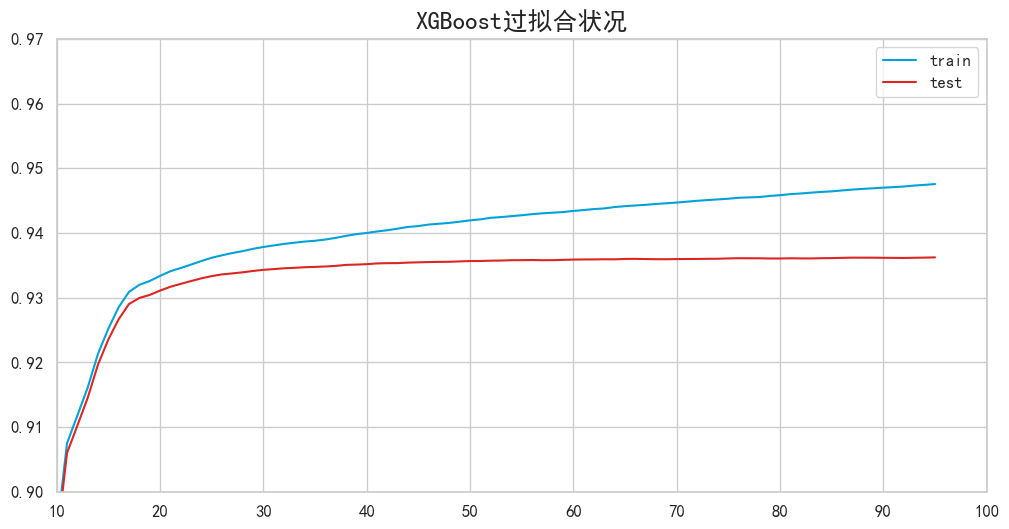

In [300]:
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(xgbcv.index,xgbcv["train-auc-mean"],c="#01a2d9",label="train")
plt.plot(xgbcv.index,xgbcv["test-auc-mean"],c="#dc2624",label="test")

sns.set(style="whitegrid",font="simhei", font_scale=1.1)
plt.title("XGBoost过拟合状况",fontsize=18)
plt.legend()
plt.xlim(10,100)
plt.ylim((0.9,0.97))
plt.show()

<div class="alert alert-block alert-success">

- 从结果来看，xgboost上的过拟合不是特别严重，这与我们将xgboost的树数量调整为96有很大的关系，同时xgboost的默认参数本身就一定程度上控制了过拟合（例如，max_depth=6），因此xgboost在抑制过拟合后得到好结果的可能性就非常小了。
- 接下来对XGBoost尝试一下改变max_depth看下效果。
</div>

In [301]:
%%time
for max_depth in [5,10,15,20]:
    cv = KFold(n_splits=5,shuffle=True,random_state=0)
    param = {"objective":'binary:logistic',"eval_metric": "auc","max_depth" : max_depth
             ,"scale_pos_weight": 0.015}
    xgbcv = xgb.cv(param, dtrain, num_boost_round=96, nfold=5, seed=0, shuffle=True)
    test_auc = xgbcv.loc[95,"test-auc-mean"]
    print(max_depth)
    print("\t xgb:{:.5f}".format(test_auc))

5
	 xgb:0.93547
10
	 xgb:0.93517
15
	 xgb:0.93406
20
	 xgb:0.93395
Wall time: 1min 21s


<div class="alert alert-block alert-success">

- 随着max_depth增加，XGBoost并没有取得更好的AUC结果
- 经测试，当max_depth等于3~9时，还是6可以获得最好的AUC
    - 因此还是**保持XGBoost的max_depth默认值不变（max_depth=6）**
</div>

**RandomForest/GBDT**

<div class="alert alert-block alert-warning">
 
**思考：**     
1. 在树模型的参数中，大量的参数都是用来对抗过拟合的，这与树模型天生学习能力较强、很容易过拟合的性质有关。
</div>

<div class="alert alert-block alert-success">

- 接下来对GBDT和RandomForest尝试一下改变max_depth看下效果。
    - **GBDT的max_depth默认值为3**，因此GBDT本身应该就带有一些抗过拟合的性质。
    - **随机森林的max_depth默认值为None**，因此理论上来说森林的树应该比GBDT的树要深很多。我们可以尝试调小max_depth，来观察模型的效果：
</div>

In [302]:
%%time
for max_depth in [5,10,15,20]:
    cv = KFold(n_splits=5,shuffle=True,random_state=0)
    rf = RFC(n_estimators=1000,max_depth=max_depth,random_state=0,class_weight="balanced")
    gbdc = GBC(n_estimators=200,max_depth=max_depth,learning_rate=0.23,random_state=0)
    rfcv = cross_val_score(rf,Xtrain,Ytrain,cv=cv,scoring="roc_auc")
    gbdcv = cross_val_score(gbdc,Xtrain,Ytrain,cv=cv,scoring="roc_auc")
    print(max_depth)
    print("\t rf:{:.5f}".format(rfcv.mean()))
    print("\t gbd:{:.5f}".format(gbdcv.mean()))

5
	 rf:0.90748
	 gbd:0.93526
10
	 rf:0.92971
	 gbd:0.92861
15
	 rf:0.93216
	 gbd:0.92646
20
	 rf:0.93019
	 gbd:0.92650
Wall time: 1h 7min 35s


<div class="alert alert-block alert-success">

- 对于随机森林，
    - 在max_depth很小（=5）的时候，AUC从0.92下降了很多接近0.9，但当max_depth达到15时，AUC突破了0.93，且是目前的一个高峰，这说明随机森林的确存在过拟合的情况，而通过调整max_depth可以很好地控制过拟合情况，提升模型效果。
    - 此时**设定随机森林的max_depth=15，AUC达到了0.93216**，可以进一步精细调参
- 对于GBDT，
    - 在max_depth从默认值3增加后并没有取得更好的AUC结果，可以进一步在3周围进行调参
</div>

In [303]:
%%time
for max_depth in [2,4,6]:
    cv = KFold(n_splits=5,shuffle=True,random_state=0)
    gbdc = GBC(n_estimators=200,max_depth=max_depth,learning_rate=0.23,random_state=0)
    gbdcv = cross_val_score(gbdc,Xtrain,Ytrain,cv=cv,scoring="roc_auc")
    print(max_depth)
    print("\t gbd:{:.5f}".format(gbdcv.mean()))

2
	 gbd:0.93382
4
	 gbd:0.93565
6
	 gbd:0.93407
Wall time: 9min 19s


<div class="alert alert-block alert-success">

- 对GBDT的max_depth在3周围精密调参后，AUC并没有提升。
    - 因此还是**保持GBDT的max_depth默认值不变（max_depth=3）**
</div>

<div class="alert alert-block alert-warning">
 
**思考：**     
1. 在XGBoost和GBDT两个算法的效果都高于随机森林的情况下，我们可以以提升随机森林的效果为主，这样之后在进行模型融合时才能够提升融合模型的综合水平。
</div>

<div class="alert alert-block alert-success">

- 因此，对随机森林的max_depth在11-19进行更加精细的调整，看看能否得到更好的结果。
</div>

In [304]:
%%time
result = []
for max_depth in range(11,20):
    cv = KFold(n_splits=5,shuffle=True,random_state=0)
    rf = RFC(n_estimators=1000,max_depth=max_depth,random_state=0,class_weight="balanced")
    rfcv = cross_val_score(rf,Xtrain,Ytrain,cv=cv,scoring="roc_auc")
    result.append(rfcv.mean())
    print(max_depth)
    print("\t rf:{:.5f}".format(rfcv.mean()))

11
	 rf:0.93132
12
	 rf:0.93219
13
	 rf:0.93251
14
	 rf:0.93244
15
	 rf:0.93216
16
	 rf:0.93168
17
	 rf:0.93117
18
	 rf:0.93076
19
	 rf:0.93042
Wall time: 53min 58s


RF最高分是0.93251，最高分对应的max_depth是13


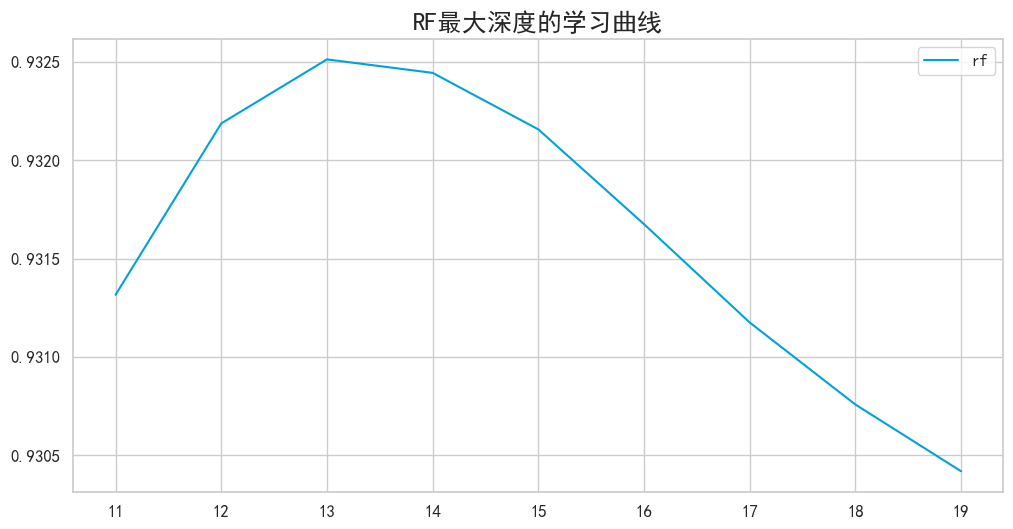

In [305]:
max_depth = range(11,20)
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(max_depth,result,c="#01a2d9",label="rf")
print("RF最高分是{:.5f}，最高分对应的max_depth是{}".format(max(result),max_depth[result.index(max(result))]))
sns.set(style="whitegrid",font="simhei", font_scale=1.1)
plt.title("RF最大深度的学习曲线",fontsize=18)
plt.legend()
plt.xticks(max_depth)
plt.show()

<div class="alert alert-block alert-success">

- 可见**对于随机森林，设定max_depth=13时效果最好，AUC达到了0.93251。**
- 在新参数下，尝试能否降低随机森林树的数量（为了减少计算量）且能保持模型效果。
    - 此时树的数量是1000，因此尝试100~500。
</div>

In [306]:
%%time
rf_result = []
for num_round in [100,200,300,400,500]:
    cv = KFold(n_splits=5,shuffle=True,random_state=0)
    rf = RFC(n_estimators=num_round,max_depth=13,random_state=0,class_weight="balanced")
    rfcv = cross_val_score(rf,Xtrain,Ytrain,cv=cv,scoring="roc_auc")
    rf_result.append(rfcv.mean())
    print(num_round)
    print("\t rf:{:.5f}".format(rfcv.mean()))

100
	 rf:0.93199
200
	 rf:0.93237
300
	 rf:0.93241
400
	 rf:0.93246
500
	 rf:0.93247
Wall time: 8min 12s


随机森林最高分是0.93247，最高分对应的树数量是500


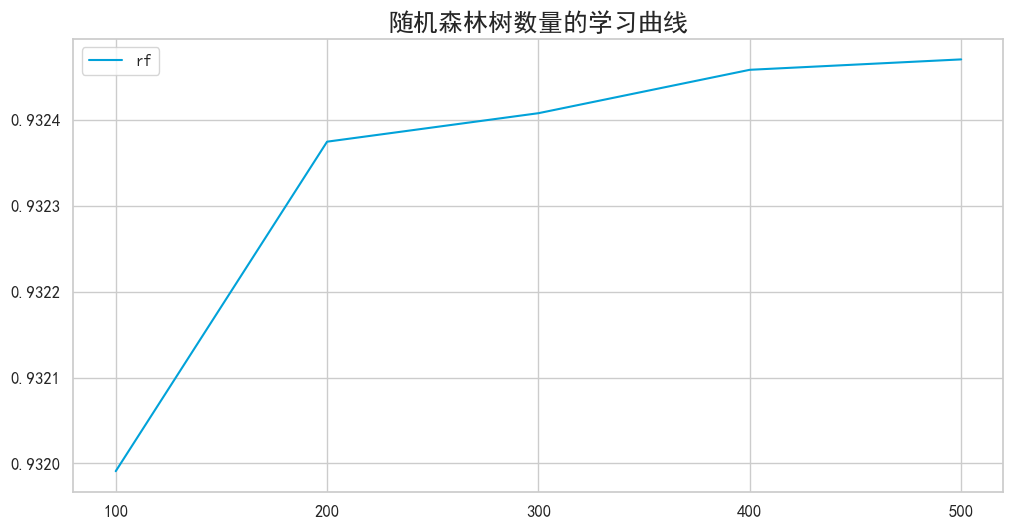

In [307]:
num_round = [100,200,300,400,500]
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(num_round,rf_result,c="#01a2d9",label="rf")
print("随机森林最高分是{:.5f}，最高分对应的树数量是{}".format(max(rf_result),num_round[rf_result.index(max(rf_result))]))
sns.set(style="whitegrid",font="simhei", font_scale=1.1)
plt.title("随机森林树数量的学习曲线",fontsize=18)
plt.legend()
plt.xticks(num_round)
plt.show()

<div class="alert alert-block alert-success">

- 可见，虽然我们限制了过拟合，但并没有改变随机森林的结果随着树的数量增多持续上升的情况。
- 不过随机森林在500棵树时的AUC已经达到了0.93247，即便我们将树的数量增加到1000，也只是提升了0.0004。
- 因此，从计算效率和模型效果综合角度来考虑，我们选择更少的树的数量。决定**将随机森林的树数量降低至500棵树（n_estimators=500）,此时的AUC为0.93247。**
</div>

<div class="alert alert-block alert-warning">
 
**思考：**     
1. 对随机森林而言，我们可以持续调整更多关于控制过拟合的参数，例如max_features、min_samples_split，但考虑到之后需要对模型进行融合，因此不再进行更精密的调参。
</div>

<div class="alert alert-block alert-success">
    
- 现在模型参数如下：
    - **随机森林**：
        - rf = RFC(n_estimators=500,random_state=0,class_weight="balanced")
    - **GBDT**:
        - gbdt = GBC(n_estimators=200,learning_rate=0.23,random_state=0)
    - **XGBoost**:
        - param = {"objective":'binary:logistic',"eval_metric": "auc","scale_pos_weight": 0.015}
        - xgbcv = xgb.cv(param, dtrain, num_boost_round=96, nfold=5, seed=0, shuffle=True)
</div>

|算法|benchmark|特征工程|样本均衡|树的数量|学习率|控制过拟合|
|----|-------- |--------|--------|---- ---|------|----------|
|rf|0.82822|0.92660(<font color=green>**+**</font>)|0.92804(<font color=green>**+**</font>)|0.92870(<font color=green>**+**</font>)|-|0.93247(<font color=green>**+**</font>)|
|gbdt|-|0.93462(<font color=green>**+**</font>)|-|-|0.93584(<font color=green>**+**</font>)|-|
|xgb|-|0.93244(<font color=green>**+**</font>)|0.93515(<font color=green>**+**</font>)|0.93622(<font color=green>**+**</font>)|-|-|

### 3.使用Voting法则进行模型融合

<div class="alert alert-block alert-warning">
 
**思考：**     
1. 根据调参结果，我们已经得到了理论上泛化能力较强的三个模型，现在我们需要对三个模型进行融合。
</div>

<div class="alert alert-block alert-success">
    
- 对于sklearn中的RandomForest和GBDT模型来说，我们可以直接使用VotingClassifier进行融合，但涉及到不在sklearn中的XGBoost模型，我们就无法直接使用VotingClassifier了。
- **因此，在模型融合时需要手动进行投票。在这里选择简化流程，不再使用交叉验证，只使用训练与预测了。**
</div>

<div class="alert alert-block alert-warning">
 
**思考：**     
1. 在使用投票法融合模型时，可以选择软投票和硬投票：
    - **软投票：对各标签类别下的预测概率进行加和，选出最大概率总和对应的预测标签。**
    - **硬投票：按各模型得出的预测标签少数服从多数选择最终的预测标签。**
</div>

<div class="alert alert-block alert-success">
    
- 软投票适用于精调过的模型，而硬投票适用于使用默认参数的模型。
- 因此，我们**选择软投票**规则。
</div>

#### 3.1 训练模型并输出预测概率

In [308]:
train = pd.read_csv(r'train.csv',index_col=0)
test = pd.read_csv(r'test.csv',index_col=0)

In [309]:
# 划分特征和标签
Xtrain = train.iloc[:,1:]
Xtest = test.iloc[:,1:]
Ytrain = train.iloc[:,0]
Ytest = test.iloc[:,0]

In [310]:
# 生成xgb所需特定的数据集
dtrain = xgb.DMatrix(Xtrain,Ytrain)
dtest = xgb.DMatrix(Xtest,Ytest)

In [311]:
# 此时的三个模型实例化
rf = RFC(n_estimators=500,max_depth=13,class_weight="balanced",random_state=0)
gbdt = GBC(n_estimators=200,learning_rate=0.23,random_state=0)
param = {"objective":'binary:logistic'
         ,"eval_metric": "auc"
         ,"scale_pos_weight": 0.015
         ,"seed":0}

In [312]:
# 在训练集上进行训练
rf = rf.fit(Xtrain,Ytrain)
gbdt = gbdt.fit(Xtrain,Ytrain)
xgb = xgb.train(param,dtrain,num_boost_round=96)

In [313]:
# 在训练集上输出预测概率
rf_prob_train = rf.predict_proba(Xtrain)
gbdt_prob_train = gbdt.predict_proba(Xtrain)
xgb_prob_train = xgb.predict(dtrain)

In [314]:
# 在测试集上输出预测概率
rf_prob_test = rf.predict_proba(Xtest)
gbdt_prob_test = gbdt.predict_proba(Xtest)
xgb_prob_test = xgb.predict(dtest)

<div class="alert alert-block alert-success">
    
- sklearn下的随机森林和GBDT模型的预测概率结果是两列，第一列是0类概率，第二列是1类概率
- XGBoost模型的训练概率结果是一列，代表1类概率，0类概率可以通过1减去得到
</div>

#### 3.2 基于模型效果（AUC）的软投票

<div class="alert alert-block alert-warning">
 
**思考：**     
1. 由于三个模型预测效果有差异， 因此，可以根据AUC在软投票的基础上，对预测概率加权求和，更高的AUC设置更高的权重。
</div>

<div class="alert alert-block alert-success">
    
- 最终目的是希望在测试集上有更高的AUC
</div>

In [315]:
from sklearn.metrics import roc_auc_score, accuracy_score

In [316]:
# rf - train - auc
roc_auc_score(Ytrain,rf_prob_train[:,1])

0.9630791433565995

In [317]:
# gbdt - train - auc
roc_auc_score(Ytrain,gbdt_prob_train[:,1])

0.943682826252074

In [318]:
# xgb - train - auc
roc_auc_score(Ytrain,xgb_prob_train)

0.9466731187724142

In [319]:
# rf - test - auc
roc_auc_score(Ytest,rf_prob_test[:,1])

0.8299232590987459

In [320]:
# gbdt - test - auc
roc_auc_score(Ytest,gbdt_prob_test[:,1])

0.7958953733059406

In [321]:
# xgb - test - auc
roc_auc_score(Ytest,xgb_prob_test)

0.8176773050605788

<div class="alert alert-block alert-success">
    
- 从训练集和测试集上的AUC结果来看，RandomForest的分数最高，XGBoost居中，而GBDT最低。
    
</div>

**训练集**

In [322]:
# 合并三个模型的在训练集上的预测概率
prob_train = pd.concat([pd.DataFrame(rf_prob_train,columns=["rf0","rf1"])
                        ,pd.DataFrame(gbdt_prob_train,columns=["gbdt0","gbdt1"])
                        ,pd.DataFrame(1-xgb_prob_train,columns=["xgb0"])
                        ,pd.DataFrame(xgb_prob_train,columns=["xgb1"])]
                                      ,axis=1)

In [323]:
prob_train.head()

,rf0,rf1,gbdt0,gbdt1,xgb0,xgb1
0,0.261431,0.738569,0.032940,0.967060,0.639492,0.360508
1,0.401421,0.598579,0.780111,0.219889,0.993481,0.006519
2,0.853966,0.146034,0.988101,0.011899,0.999707,0.000293
3,0.434060,0.565940,0.665437,0.334563,0.991017,0.008983
4,0.595031,0.404969,0.572452,0.427548,0.992394,0.007606


In [324]:
# 将所有样本为0的概率按权重加和
prob_train.loc[:,"0"] = prob_train.loc[:,"rf0"] + 0.2*prob_train.loc[:,"gbdt0"] + 0.8*prob_train.loc[:,"xgb0"]

In [325]:
# 将所有样本为1的概率按权重加和
prob_train.loc[:,"1"] = prob_train.loc[:,"rf1"] + 0.2*prob_train.loc[:,"gbdt1"] + 0.8*prob_train.loc[:,"xgb1"]

In [326]:
prob_train.head()

,rf0,rf1,gbdt0,gbdt1,xgb0,xgb1,0,1
0,0.261431,0.738569,0.032940,0.967060,0.639492,0.360508,0.779613,1.220387
1,0.401421,0.598579,0.780111,0.219889,0.993481,0.006519,1.352228,0.647772
2,0.853966,0.146034,0.988101,0.011899,0.999707,0.000293,1.851351,0.148649
3,0.434060,0.565940,0.665437,0.334563,0.991017,0.008983,1.359961,0.640039
4,0.595031,0.404969,0.572452,0.427548,0.992394,0.007606,1.503436,0.496564


In [327]:
# 将为1的概率压缩到[0,1]之间，当做最终的概率来输入auc计算函数
prob_train["adjusted1"] = prob_train["1"]/(prob_train["0"] + prob_train["1"])

In [328]:
prob_train.head()

,rf0,rf1,gbdt0,gbdt1,xgb0,xgb1,0,1,adjusted1
0,0.261431,0.738569,0.032940,0.967060,0.639492,0.360508,0.779613,1.220387,0.610194
1,0.401421,0.598579,0.780111,0.219889,0.993481,0.006519,1.352228,0.647772,0.323886
2,0.853966,0.146034,0.988101,0.011899,0.999707,0.000293,1.851351,0.148649,0.074324
3,0.434060,0.565940,0.665437,0.334563,0.991017,0.008983,1.359961,0.640039,0.320019
4,0.595031,0.404969,0.572452,0.427548,0.992394,0.007606,1.503436,0.496564,0.248282


In [329]:
# 计算AUC
roc_auc_score(Ytrain,prob_train["adjusted1"])

0.960552368756855

In [330]:
# 调节阈值来找到最佳准确率
Ytrain_pred = ((prob_train["adjusted1"]) > 0.5).astype("int")
accuracy_score(Ytrain,Ytrain_pred)

0.8878701092223759

|算法|benchmark|特征工程|样本均衡|树的数量|学习率|控制过拟合|软投票(加权)|
|----|-------- |--------|--------|---- ---|------|----------|------|
|rf|0.82822|0.92660(<font color=green>**+**</font>)|0.92804(<font color=green>**+**</font>)|0.92870(<font color=green>**+**</font>)|-|0.93247(<font color=green>**+**</font>)|-|
|gbdt|-|0.93462(<font color=green>**+**</font>)|-|-|0.93584(<font color=green>**+**</font>)|-|-|
|xgb|-|0.93244(<font color=green>**+**</font>)|0.93515(<font color=green>**+**</font>)|0.93622(<font color=green>**+**</font>)|-|-|-|    
|融合模型|-|-|-|-|-|-|**0.96055**(<font color=green>**+**</font>)|

**测试集**

In [331]:
# 合并三个模型的在测试集上的预测概率
prob_test = pd.concat([pd.DataFrame(rf_prob_test,columns=["rf0","rf1"])
                        ,pd.DataFrame(gbdt_prob_test,columns=["gbdt0","gbdt1"])
                        ,pd.DataFrame(1-xgb_prob_test,columns=["xgb0"])
                        ,pd.DataFrame(xgb_prob_test,columns=["xgb1"])]
                                      ,axis=1)

In [332]:
prob_test.head()

,rf0,rf1,gbdt0,gbdt1,xgb0,xgb1
0,0.685773,0.314227,0.978954,0.021046,0.998729,0.001271
1,0.568665,0.431335,0.907014,0.092986,0.993397,0.006603
2,0.401421,0.598579,0.780111,0.219889,0.993481,0.006519
3,0.953350,0.046650,0.998489,0.001511,0.999873,0.000127
4,0.610276,0.389724,0.625891,0.374109,0.996067,0.003933


In [333]:
# 将所有样本为0的概率按权重加和
prob_test.loc[:,"0"] = prob_test.loc[:,"rf0"] + 0.2*prob_test.loc[:,"gbdt0"] + 0.8*prob_test.loc[:,"xgb0"]

In [334]:
# 将所有样本为1的概率按权重加和
prob_test.loc[:,"1"] = prob_test.loc[:,"rf1"] + 0.2*prob_test.loc[:,"gbdt1"] + 0.8*prob_test.loc[:,"xgb1"]

In [335]:
prob_test.head()

,rf0,rf1,gbdt0,gbdt1,xgb0,xgb1,0,1
0,0.685773,0.314227,0.978954,0.021046,0.998729,0.001271,1.680547,0.319453
1,0.568665,0.431335,0.907014,0.092986,0.993397,0.006603,1.544786,0.455214
2,0.401421,0.598579,0.780111,0.219889,0.993481,0.006519,1.352228,0.647772
3,0.953350,0.046650,0.998489,0.001511,0.999873,0.000127,1.952947,0.047053
4,0.610276,0.389724,0.625891,0.374109,0.996067,0.003933,1.532308,0.467692


In [336]:
# 将为1的概率压缩到[0,1]之间，当做最终的概率来输入auc计算函数
prob_test["adjusted1"] = prob_test["1"]/(prob_test["0"] + prob_test["1"])

In [337]:
prob_test.head()

,rf0,rf1,gbdt0,gbdt1,xgb0,xgb1,0,1,adjusted1
0,0.685773,0.314227,0.978954,0.021046,0.998729,0.001271,1.680547,0.319453,0.159727
1,0.568665,0.431335,0.907014,0.092986,0.993397,0.006603,1.544786,0.455214,0.227607
2,0.401421,0.598579,0.780111,0.219889,0.993481,0.006519,1.352228,0.647772,0.323886
3,0.953350,0.046650,0.998489,0.001511,0.999873,0.000127,1.952947,0.047053,0.023527
4,0.610276,0.389724,0.625891,0.374109,0.996067,0.003933,1.532308,0.467692,0.233846


In [338]:
# 计算AUC
roc_auc_score(Ytest,prob_test["adjusted1"])

0.829931253753172

In [339]:
# 计算准确率
Ytest_pred = ((prob_test["adjusted1"]) > 0.4).astype("int")
accuracy_score(Ytest,Ytest_pred)

0.8199031710222808

<div class="alert alert-block alert-success">
    
- 从结果来看，模型**在测试集上的AUC=0.82993**,虽然远远低于训练集的0.96055（即存在过拟合），但是这个分数在业务上已经可以起到“预警”作用了。
    
</div>

<div class="alert alert-block alert-warning">
 
**思考：**     
1. 在训练集的交叉验证中，模型已经展现出了很好的泛化能力，但鉴于数据本身的属性，测试集与训练集的数据属性/分布可能差异太大（例如，新订单与过去的订单没有丝毫的联系，或新订单包含了太多过去的订单没有的信息），导致测试集上的结果不是那么尽如人意。对训练集相似的数据，模型可以给出很好的泛化结果。
2. 此时，我们还可以做以下的操作来调整模型：
    - 使用业务中获得的标签相关的规则，例如，相同订单号的交易必然有相同的标签，来修正最终的预测结果
    - 继续进行更精细的调参，提升模型的泛化能力
    - 利用特征合成方法，形成更多聚合特征，来提升数据的质量
    - 建立更多的集成模型，增加融合模型中的模型数量
</div>